In [5]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x



Running...


In [6]:
print(len(u_x))

9310


In [7]:
def AoI(plane, event_number, thresholding=False, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

In [8]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


In [9]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [10]:
def line_finder(point1, point2):
    slope = (point1[1] - point2[1])/(point1[0] - point2[0])
    intercept = point1[1] - slope * point1[0]
    return slope, intercept

In [11]:
def line_intersect(slope1, intercept1, slope2, intercept2):
    x_point = (intercept2 - intercept1)/(slope1 - slope2)
    z_point = slope1 * x_point + intercept1
    return x_point, z_point

In [32]:
def check_valid_intersection(point1, point2, point3, point4, range_x, range_z):
    slope1, intercept1 = line_finder(point1, point2)
    slope2, intercept2 = line_finder(point3, point4)
    x_point, z_point = line_intersect(slope1, intercept1, slope2, intercept2)
    x_vertices = [point1[0], point2[0], point3[0], point4[0]]
    z_vertices = [point1[1], point2[1], point3[1], point4[1]]
    x_max, x_min = max(x_vertices), min(x_vertices)
    z_max, z_min = max(z_vertices), min(z_vertices)
    angle1, angle2 = np.arctan(slope1), np.arctan(slope2)
    if x_point > x_min and x_point < x_max:
        if z_point > z_min and z_point < z_max:
            if x_point > (range_x[0] - 100) and x_point < range_x[1]:
                if z_point > (range_z[0] - 100) and z_point < range_z[1]:
                    if angle1 < 0.8*angle2 or angle1 > 1.25*angle2: 
                        return x_point, z_point
                    else:
                        return print("fail 1"), angle1, angle2
                else:
                    return print("fail 2")
            else:
                return print("fail 3")
        else:
            return print("fail 4")
    else:
        return print("fail 5")

In [33]:
def get_valid_points(point1, point2, point3, point4, range_x, range_z):
    initial_vertices = [0, 0]
    try:
        initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point2, point3, point4, range_x, range_z)
        #print("V1")
        return initial_vertices
    except:
        try:
            initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point3, point2, point4, range_x, range_z)
            #print("V2")
            return initial_vertices
        except:
            try:
                initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point4, point2, point3, range_x, range_z)
                #print("V3")
                return initial_vertices
            except:
                return print("Fail")

In [51]:
def select_random_points(AoI_x, AoI_z, AoI_adc, iterations="scaled", no_std=thr_std):
    if iterations == "scaled":
        iterations = int((len(AoI_x))*4)
        initial_vertex_points = np.zeros((iterations*3, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                initial_vertex_points[i, 0], initial_vertex_points[i, 1] = check_valid_intersection(point1, point2, point3, point4, range_x, range_z)
                initial_vertex_points[i+1, 0], initial_vertex_points[i+1, 1] = check_valid_intersection(point1, point3, point2, point4, range_x, range_z)
                initial_vertex_points[i+2, 0], initial_vertex_points[i+2, 1] = check_valid_intersection(point1, point4, point2, point3, range_x, range_z)
                
                '''
                print("Sample: ", sample)
                print("Slope 1: ", slope1)
                print("Slope 2: ", slope2)
                print("Intercept 1: ", intercept1)
                print("Intercept 2: ", intercept2)
                print("$$$$$$$$    X-point, Z-point    $$$$$$$$: ", x_point, y_point)
                '''
    else:
        initial_vertex_points = np.zeros((iterations*3, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                initial_vertex_points[3*i, 0], initial_vertex_points[3*i, 1] = check_valid_intersection(point1, point2, point3, point4, range_x, range_z)
                initial_vertex_points[3*i+1, 0], initial_vertex_points[3*i+1, 1] = check_valid_intersection(point1, point3, point2, point4, range_x, range_z)
                initial_vertex_points[3*i+2, 0], initial_vertex_points[3*i+2, 1] = check_valid_intersection(point1, point4, point2, point3, range_x, range_z)
    return initial_vertex_points

IndentationError: unexpected unindent (3819781754.py, line 32)

In [45]:
def plotter_4_line(plane, event_number, thresholding=True, no_std=thr_std, iterations="scaled"):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.scatter(vertex_points[:,1], vertex_points[:,0], color="red")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")
    plt.show()

    return 0

In [41]:
def heatmap4points(plane, event_number, thresholding=False, no_std=thr_std, iterations=10000, bins=200):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    #print(vertex_points)
    vertex_points = vertex_points[~np.all(vertex_points == 0, axis=1)]
    #print(vertex_points)
    histvertex = plt.hist2d(vertex_points[:,1], vertex_points[:,0], bins=(bins, bins), cmap=plt.cm.jet)
    plt.title(str(plane) + str(event_number))
    #stringy = str(plane) + str(event_number) + ".png"
    #plt.savefig(stringy)
    plt.show()
    
    histogram_array = histvertex[0]
    #print(histogram_array)
    max_value = np.amax(histogram_array)
    indices = np.where(histogram_array == max_value)
    #print("Indices: ", indices)
    z_value = histvertex[1][indices[0]]
    x_value = histvertex[2][indices[1]]
    #print("Z_value: ", z_value)
    #print("X_value: ", x_value)

    return z_value[0], x_value[0], histogram_array, histvertex[1], histvertex[2]

In [42]:
def accuracy(plane, function, no_events, thresholding=False, no_std=thr_std, ifrandom=True):
    Zvert = [None] * no_events
    Zvert_true = [None] * no_events
    Xvert = [None] * no_events
    Xvert_true = [None] * no_events #avoid appends to lists; if you know how long the outputs are going to be, then assign the arrays to
                    #that length beforehand
    if ifrandom:
        sample = random.sample(range(0, len(u_x)), no_events)
        for i in tqdm(range(no_events)):   
            print("Random Number: ", sample[i])
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, sample[i], thresholding, no_std)
            
            Zvert_place, Xvert_place = function(plane, sample[i])
            
            Zvert[i] = Zvert_place
            Xvert[i] = Xvert_place
            Zvert_true[i] = Zvert_true_place
            Xvert_true[i] = Xvert_true_place
    else:
        for i in tqdm(range(no_events)):
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
            Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
            Zvert[i] = Zvert_place
            Xvert[i] = Xvert_place
            Zvert_true[i] = Zvert_true_place
            Xvert_true[i] = Xvert_true_place
    
    
    #print("Zverttrue: ", Zvert_true)
    #print("Zvert: ", Zvert)
    #print("Xvert_true: ",Xvert_true)
    #print("Xvert", Xvert)
    
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2

    #print(len(delta_r2))
    delta_r2 = [item for item in delta_r2 if item != np.inf]
    
    delta_r2 = np.sqrt(delta_r2)
    #plt.hist(delta_r2, bins='auto')
    #plt.show()

    return delta_r2, np.percentile(delta_r2, 68)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Random Number:  5213
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 1
fail 1
fail 1
Fail
fail 5
fail 5
fail 5
fail 5
fail 1
fail 1
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 1
fail 5
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 4
fail 5
fail 4
fail 4
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 4
fail 5
fail 4
fail 5
fail 4
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 4
fail 5
fail 4
fail 1
fail 1
fail 1
Fail
fail 4
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 1
fail 1
fail 1
Fail
fail 5
fail 5
fail 5
fail 1
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 4
fail 4
fail 5
fail 5
fail 

fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 1
Fail
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 1
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 1
fail 1
fail 1
Fail
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 1
fail 5
fail 1
Fail
fail 5
fail 5
fail 4
fail 4
fail 5
fail 4
fail 5
fail 4
fail 4
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 1
Fail
fail 1
fail 5
fail 5
Fail
fail 5
fail 5
fail 5
fail 5
fail 4
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fail 5
fa

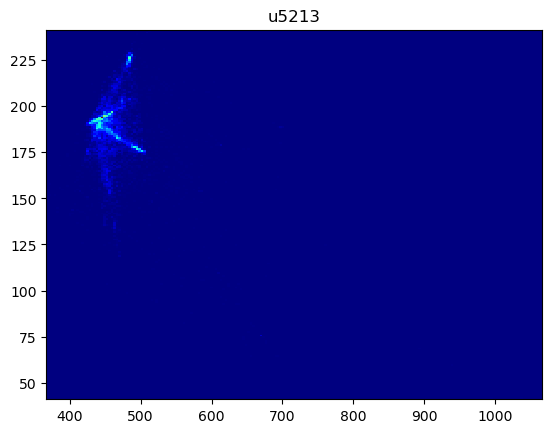

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [43]:

data1, data2 = accuracy("u", heatmap4points, 100, ifrandom=True)
print("Percentile: ", data2)


In [51]:

def findfourpointscores(plane, event_number):
    AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, event_number)
    score_array, z_array, x_array = heatmap4points(plane, event_number)[2], heatmap4points(plane, event_number)[3], heatmap4points(plane, event_number)[4]
    
    score_max = np.amax(score_array)
    #print("\nscore_max: ", score_max)
    score_min = np.min(score_array)
    #print("\nscore_min: ", score_min)
    normalised_scores = (score_array - score_min) / (score_max - score_min)
    #print("\nmax normal score: ", np.max(normalised_scores))
    
    return normalised_scores, z_array, x_array

def find_heatmap_bins(AoI_x, AoI_z, x_array, z_array, normalised_score):
    #z index
    new_normalised_score = [None] * len(AoI_z)
    for i in range(len(AoI_z)):
        for j in range(len(z_array)-1):
            if (AoI_z[i] > z_array[j]) and (AoI_z[i] < z_array[j+1]):
                z_index = j
                break
            else:
                z_index = j
        for t in range(len(x_array)-1):
            if (AoI_x[i] > x_array[t]) and (AoI_x[i] < x_array[t+1]):
                x_index = t
                break
            else:
                x_index = t
        new_normalised_score[i] = normalised_score[x_index][z_index]
    
    return new_normalised_score
    

In [52]:
def findfourpointpdf(plane, events, plot=True):
    
    total_signal = []
    total_back = []
    total_r_sig = []
    total_r_back = []
    
    for ev in tqdm(events):
        signal = []
        back = []
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, ev)
        
        normalised_score, z_array, x_array = findfourpointscores(plane, ev)
        z_array, x_array = z_array[:len(z_array)-1], x_array[:len(x_array)-1]
        #print("normalised_score size: ", normalised_score.size)
        #print("z array len: ", len(z_array))
        #print("x array len: ", len(x_array))
        #print("z array: ", z_array)
        #print("x array: ", x_array)
        
        r = [None] * len(AoI_z)
        #print("\nmax normal score: ", np.max(normalised_score))
        new_normalised_score = find_heatmap_bins(AoI_x, AoI_z, x_array, z_array, normalised_score)

        
        for i in range(len(new_normalised_score)):
            r[i] = ( (AoI_z[i]-Zvert_true_place)**2 + (AoI_x[i]-Xvert_true_place)**2 )**0.5
            #print("R value: ", r[i][j])
            if r[i] < 10:
                signal.append(new_normalised_score[i])
            else:
                back.append(new_normalised_score[i])
                
        total_signal.extend(signal)
        total_back.extend(back)
        
    if plot:
        
        
        weights_signal = np.ones(len(total_signal))
        weights_signal /= np.sum(weights_signal)
    
        weights_back = np.ones(len(total_back))
        weights_back /= np.sum(weights_back)
        
        plt.clf()
        x = plt.hist(total_signal,20, color='b', alpha=0.5, weights=weights_signal)
        title = plt.title("Signal")
        plt.show()
        
        plt.clf()
        y = plt.hist(total_back,20, color='r', alpha=0.5, weights=weights_back)
        title = plt.title("Background")
        plt.show()
        
    return total_signal, total_back, x, y

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

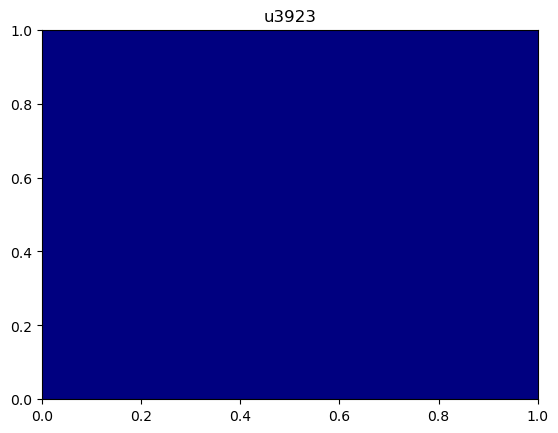

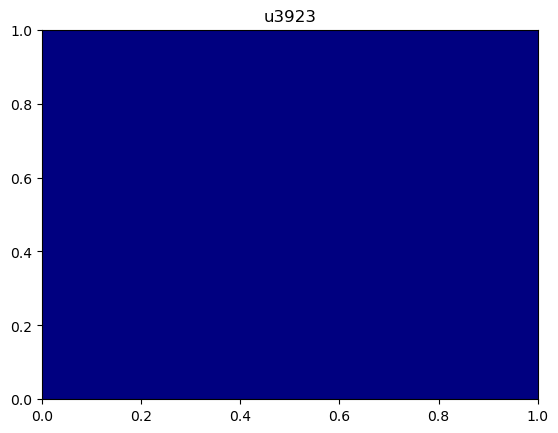

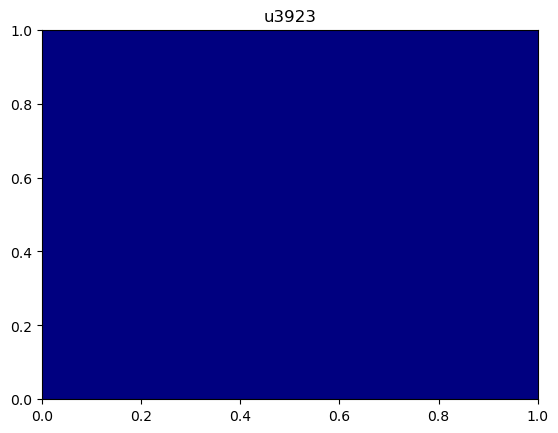

C:\Users\alexg\AppData\Local\Temp\ipykernel_2188\1879549959.py:9: RuntimeWarning: invalid value encountered in divide
  normalised_scores = (score_array - score_min) / (score_max - score_min)
  1%|▊                                                                                 | 1/100 [00:01<02:30,  1.52s/it]

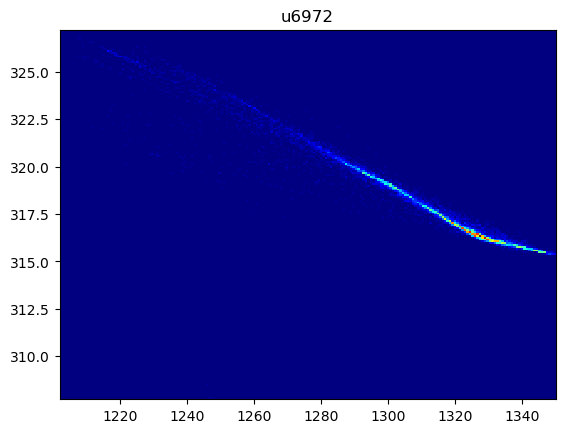

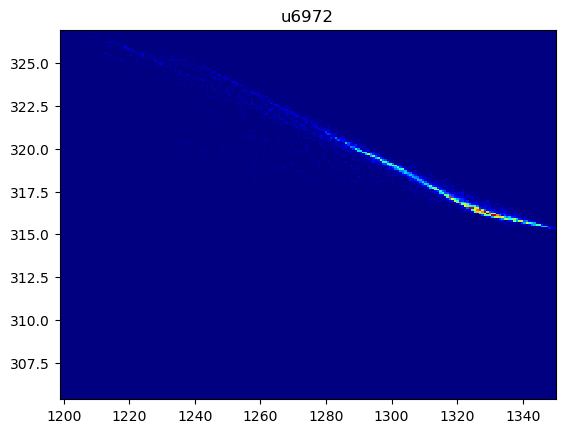

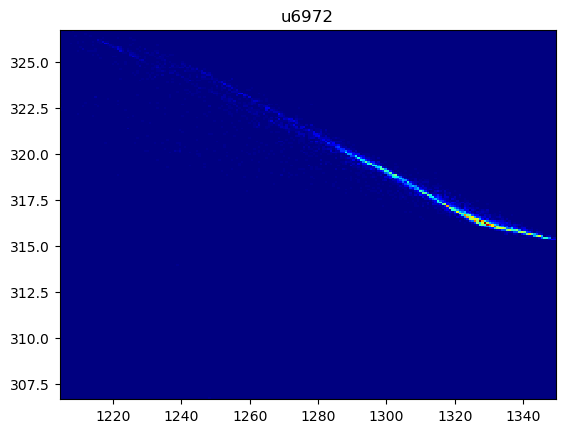

  2%|█▋                                                                                | 2/100 [00:03<02:38,  1.62s/it]

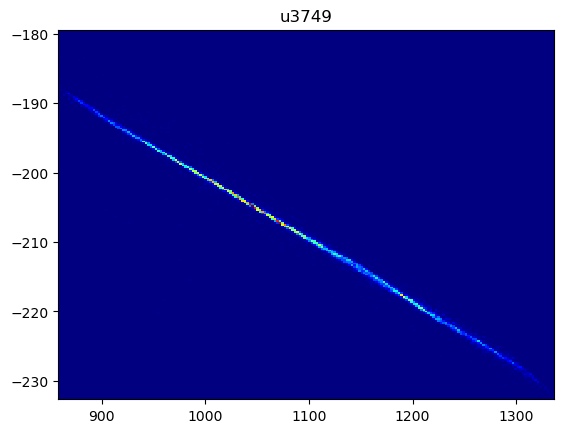

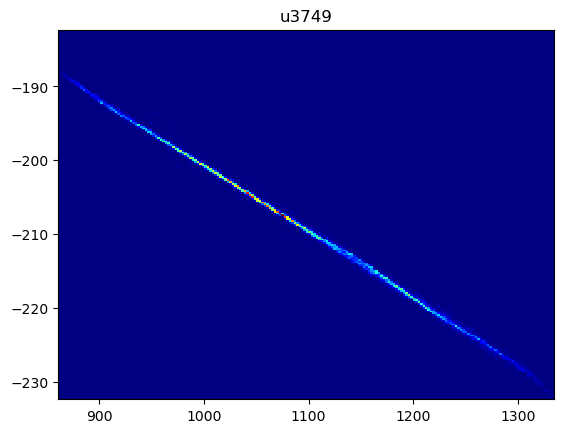

C:\Users\alexg\AppData\Local\Temp\ipykernel_2188\1175323999.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_2188\1175323999.py:3: RuntimeWarning: invalid value encountered in float_scalars
  y_point = slope1 * x_point + intercept1


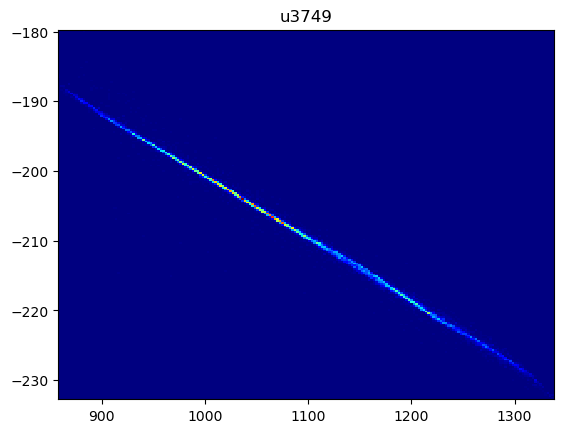

  3%|██▍                                                                               | 3/100 [00:04<02:42,  1.68s/it]

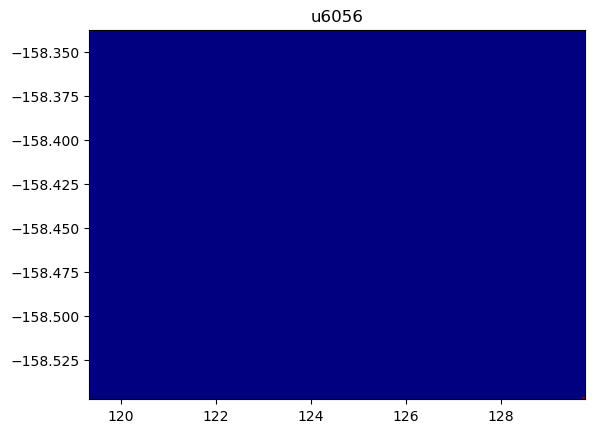

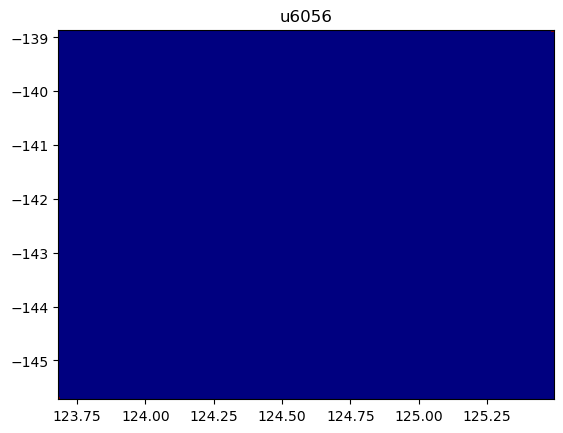

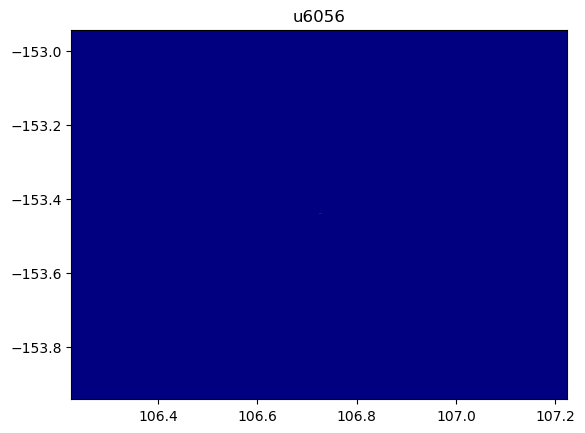

  4%|███▎                                                                              | 4/100 [00:06<02:45,  1.73s/it]

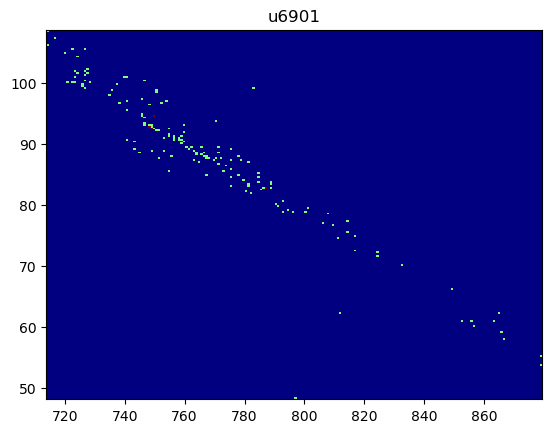

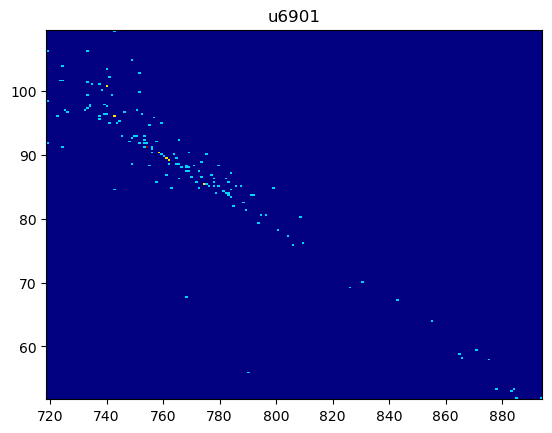

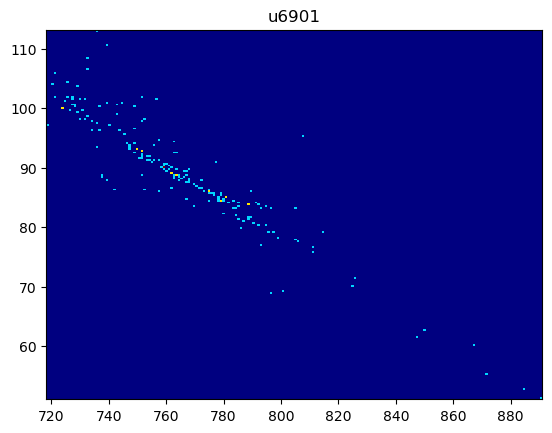

  5%|████                                                                              | 5/100 [00:08<02:45,  1.74s/it]

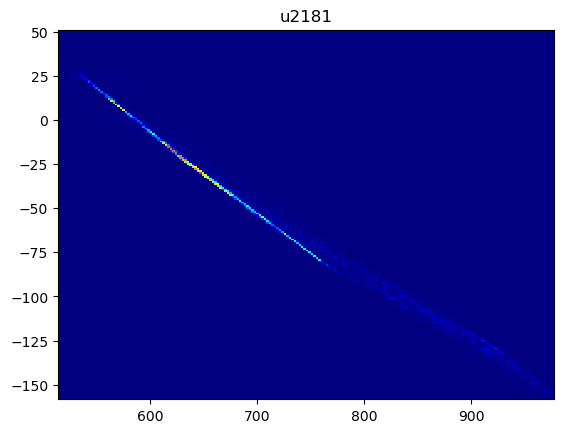

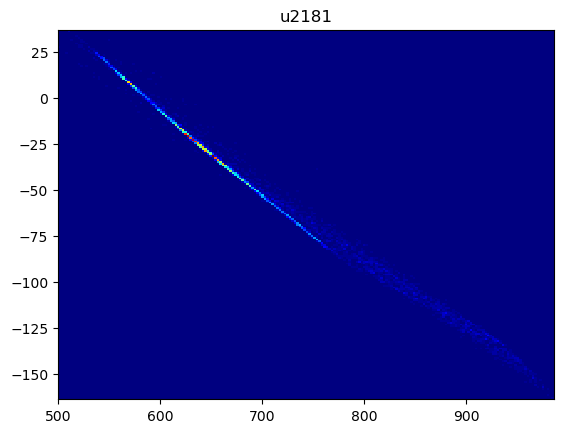

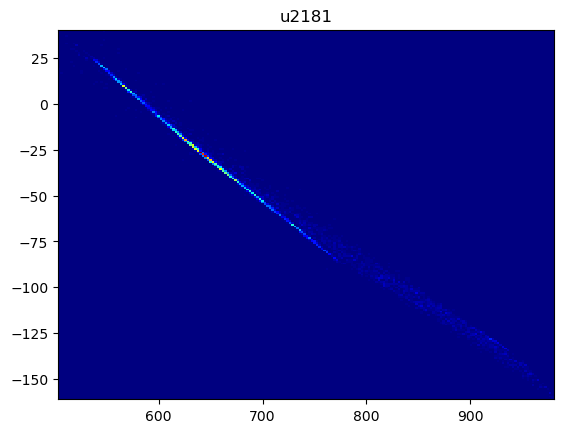

  6%|████▉                                                                             | 6/100 [00:10<02:41,  1.72s/it]

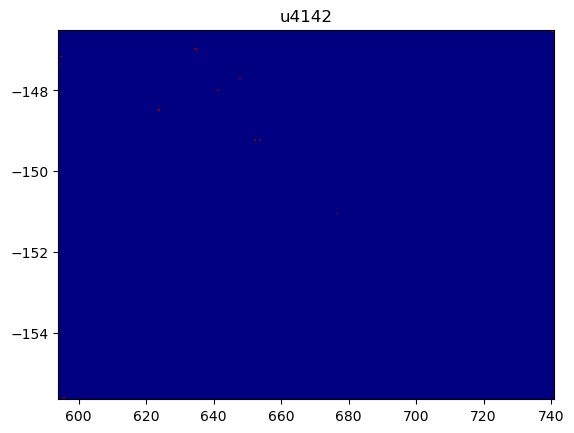

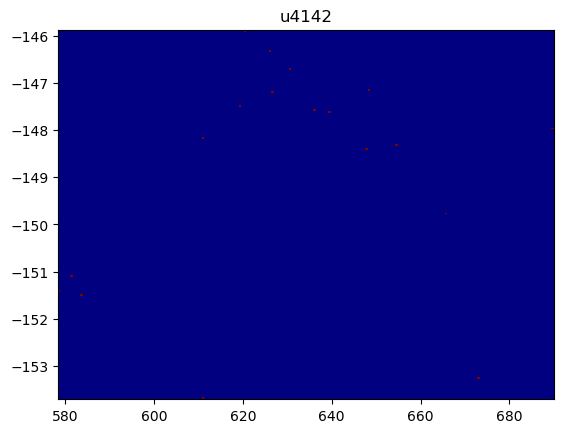

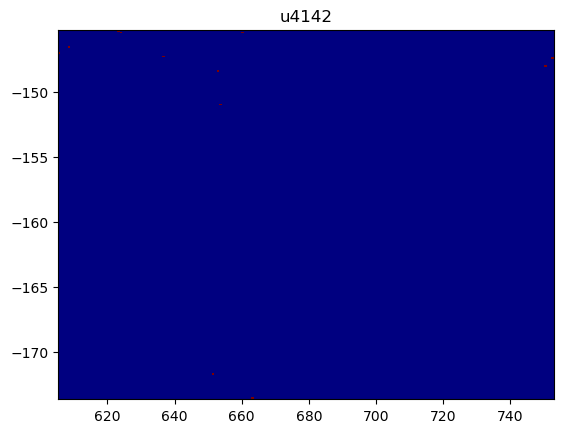

  7%|█████▋                                                                            | 7/100 [00:11<02:36,  1.69s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_2188\1175323999.py:2: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)


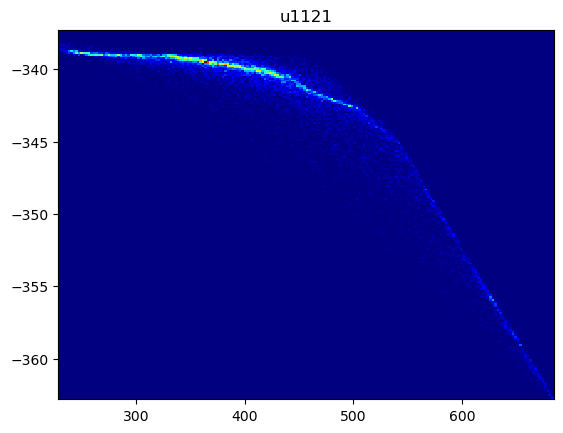

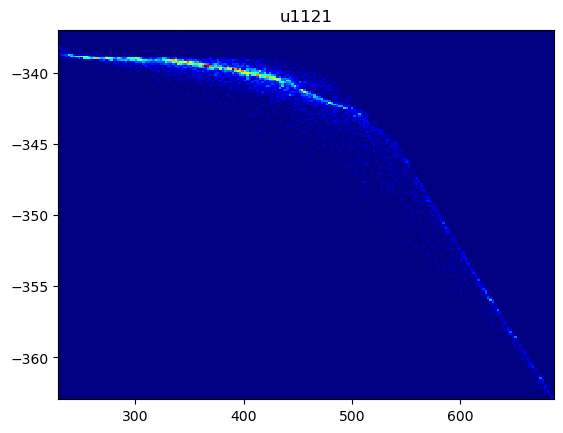

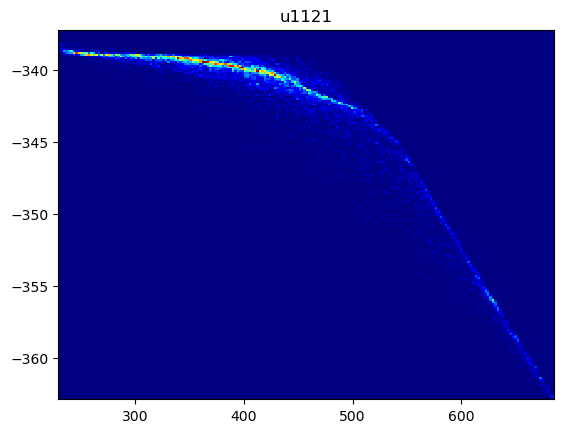

  8%|██████▌                                                                           | 8/100 [00:13<02:31,  1.65s/it]

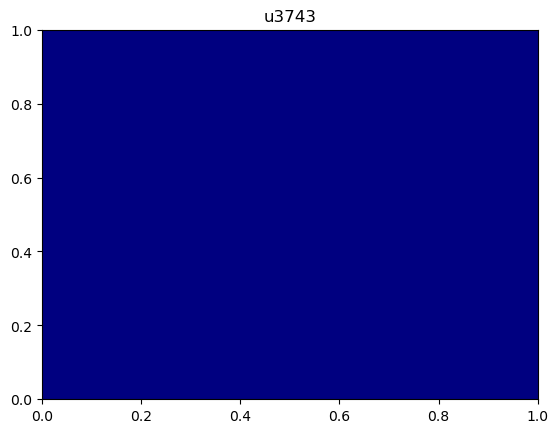

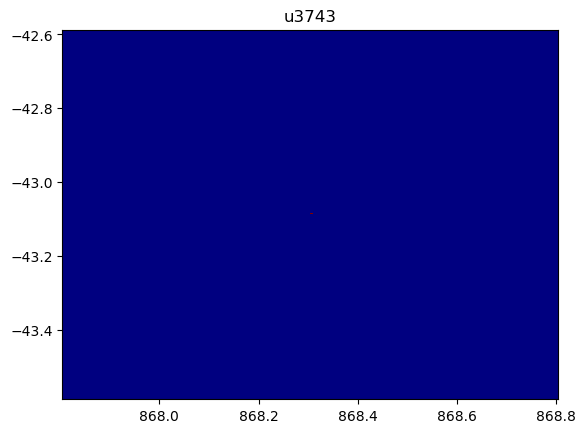

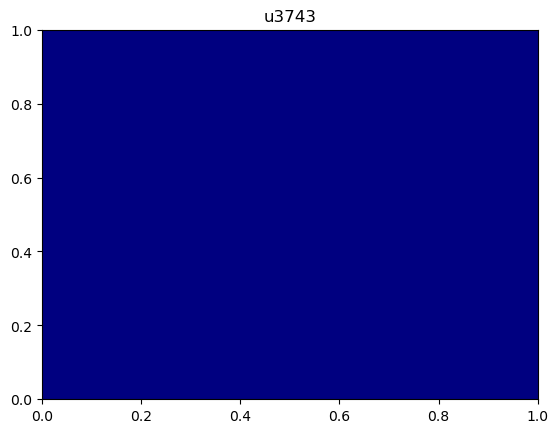

  9%|███████▍                                                                          | 9/100 [00:14<02:20,  1.55s/it]

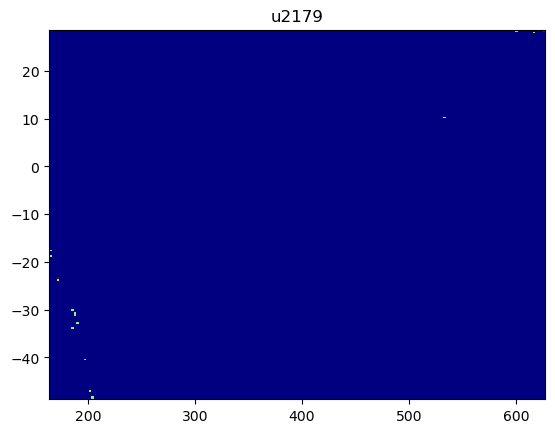

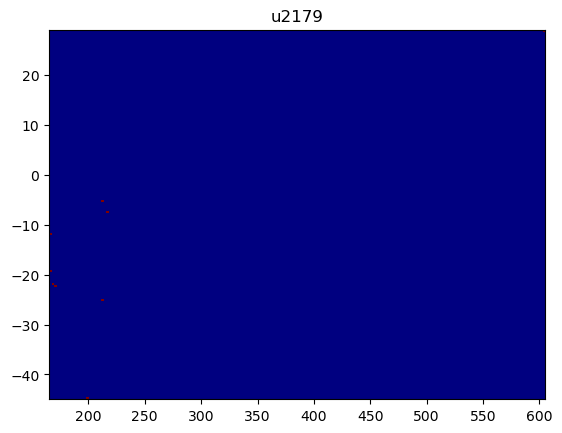

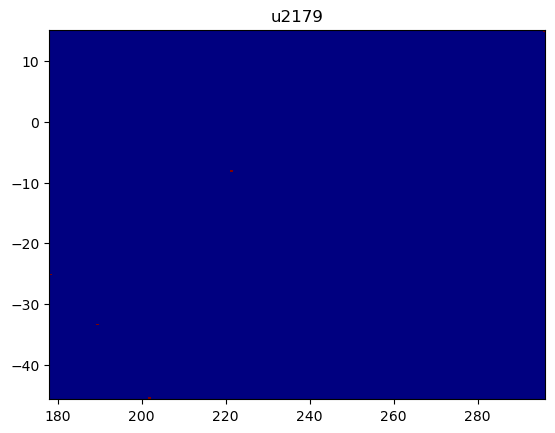

 10%|████████                                                                         | 10/100 [00:16<02:21,  1.57s/it]

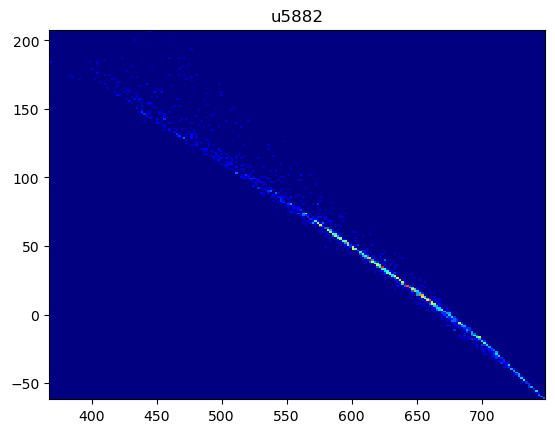

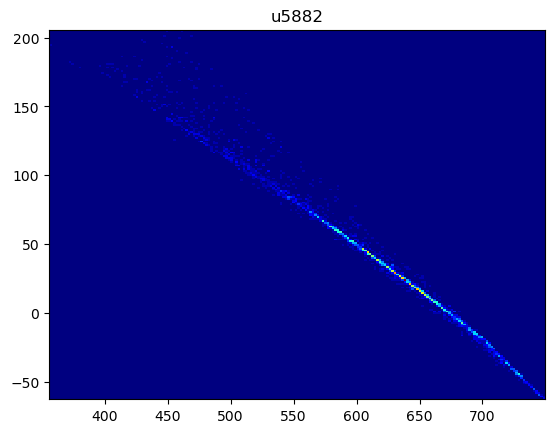

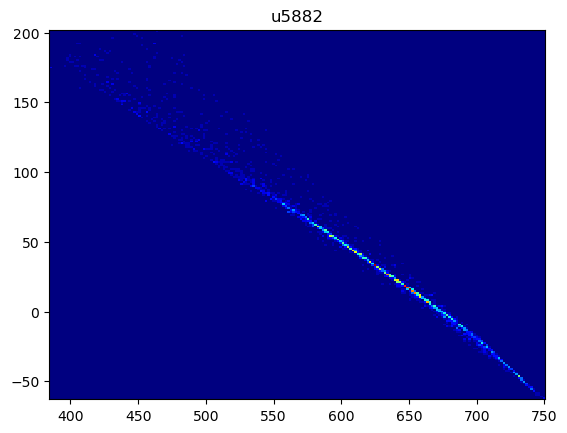

 11%|████████▉                                                                        | 11/100 [00:17<02:19,  1.57s/it]

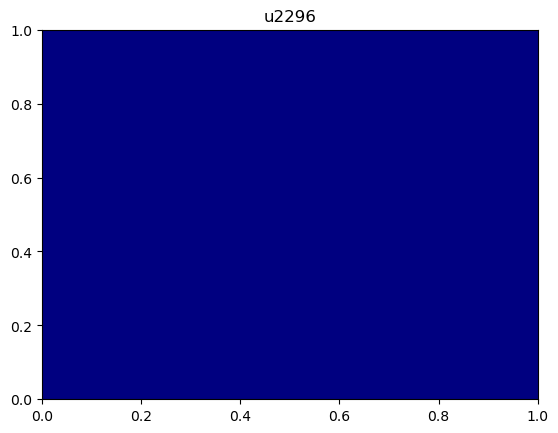

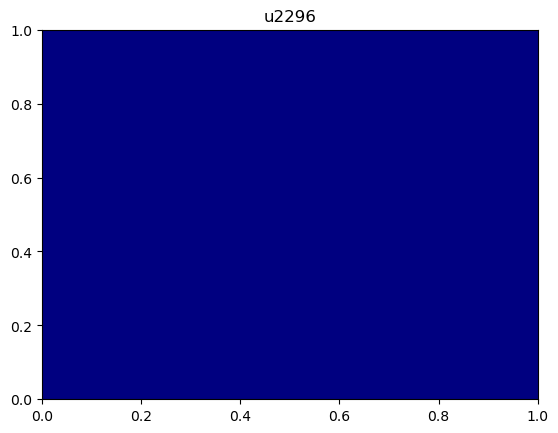

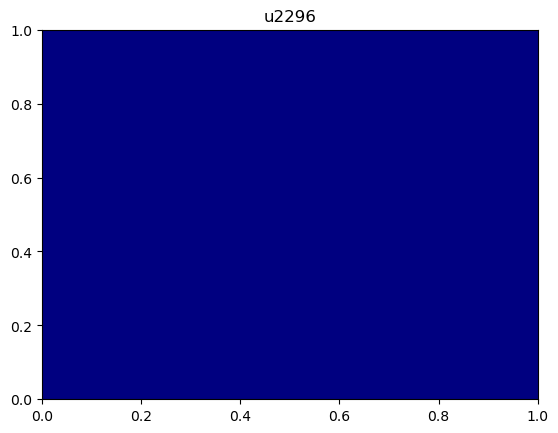

 12%|█████████▋                                                                       | 12/100 [00:19<02:16,  1.55s/it]

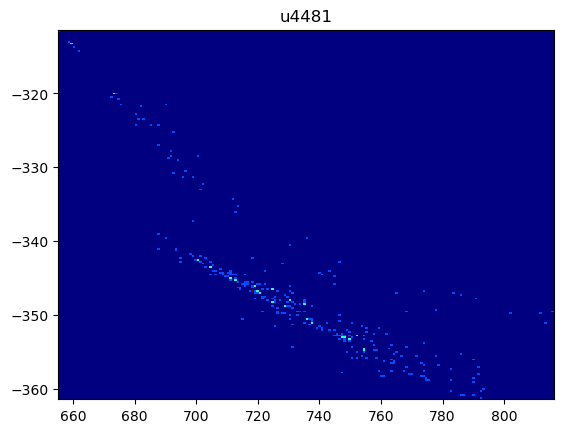

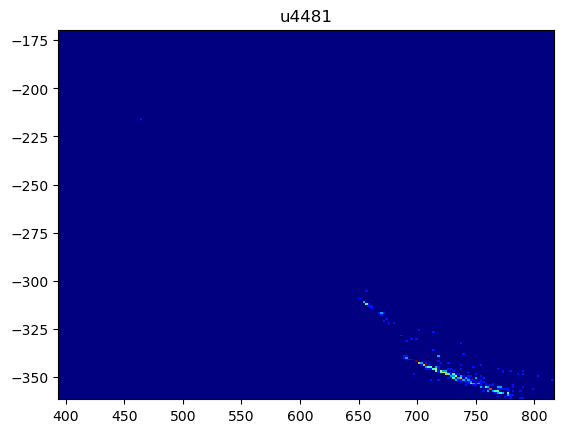

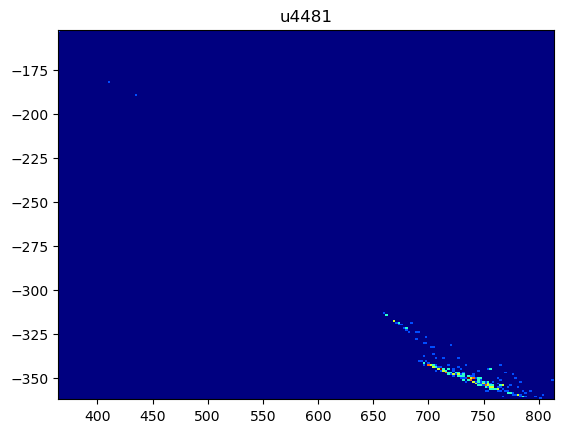

 13%|██████████▌                                                                      | 13/100 [00:21<02:16,  1.57s/it]

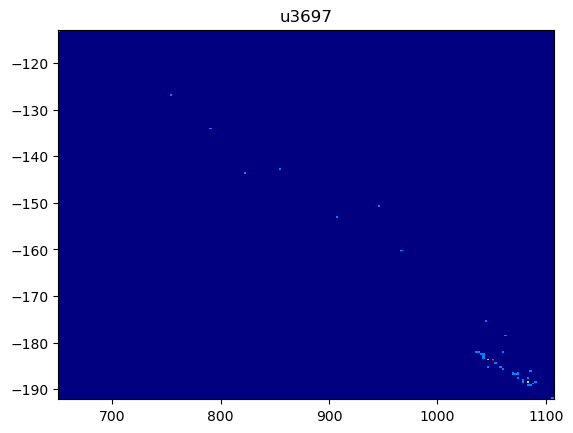

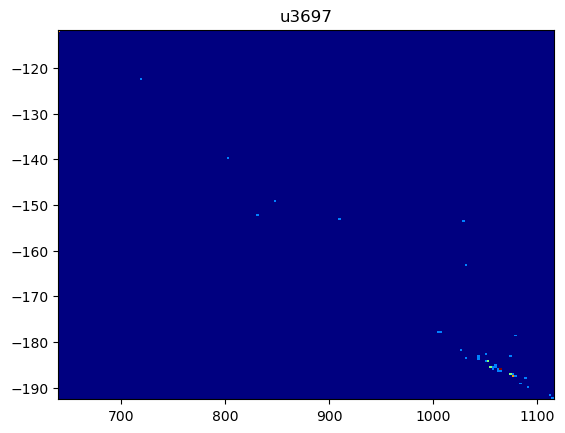

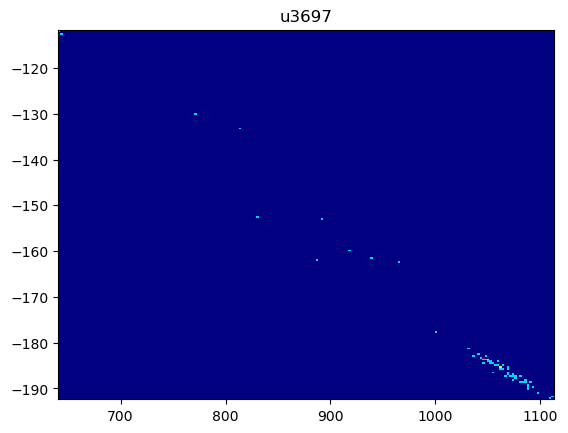

 14%|███████████▎                                                                     | 14/100 [00:22<02:13,  1.55s/it]

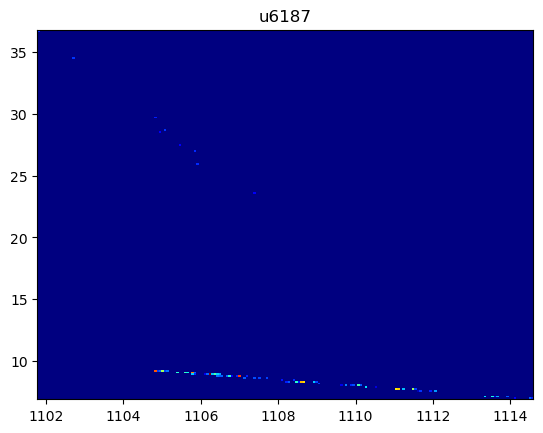

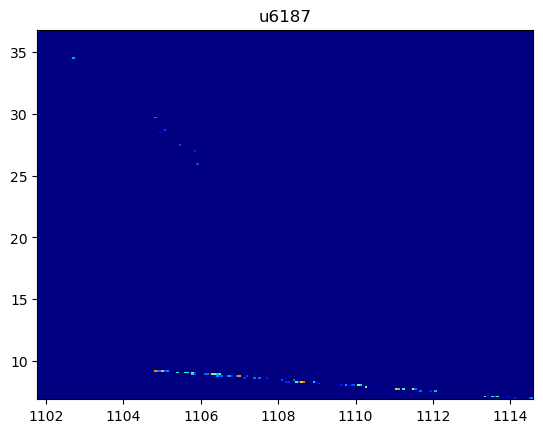

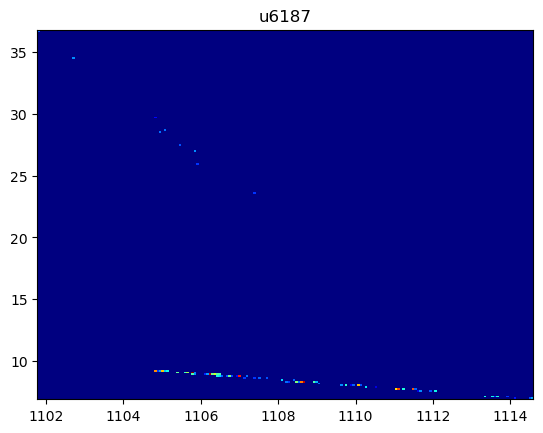

 15%|████████████▏                                                                    | 15/100 [00:23<02:08,  1.51s/it]

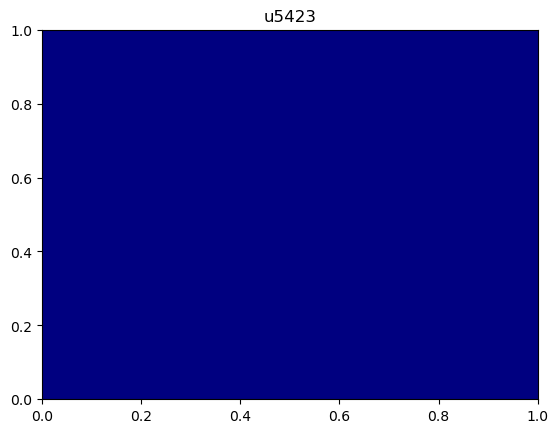

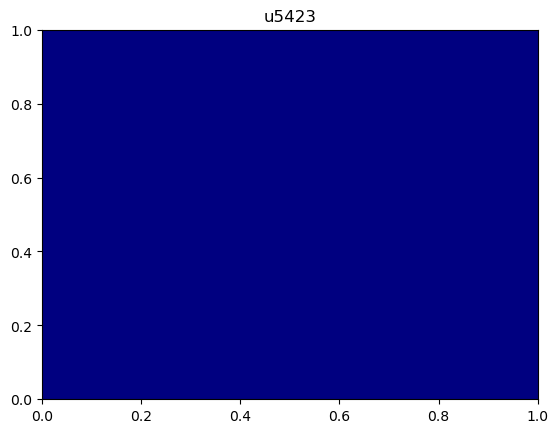

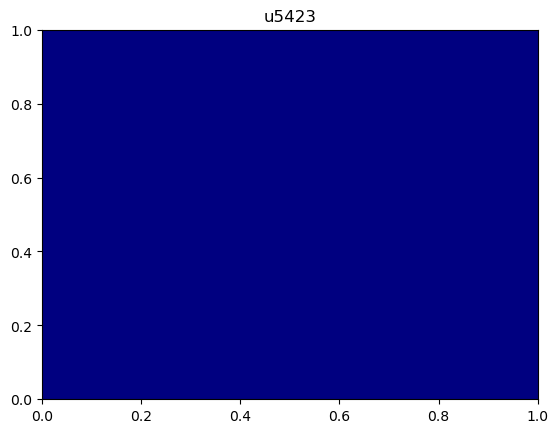

 16%|████████████▉                                                                    | 16/100 [00:25<02:06,  1.51s/it]

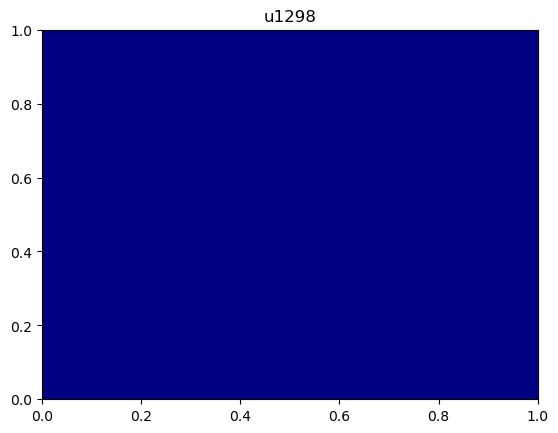

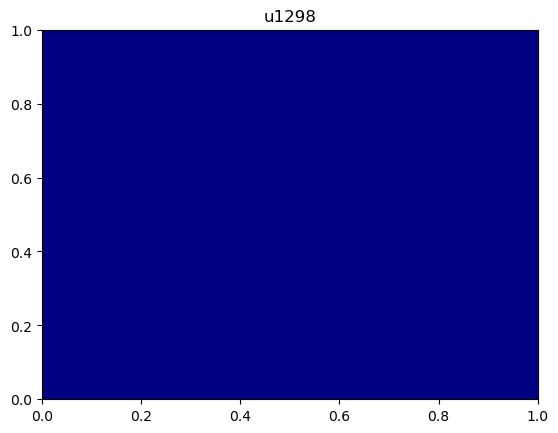

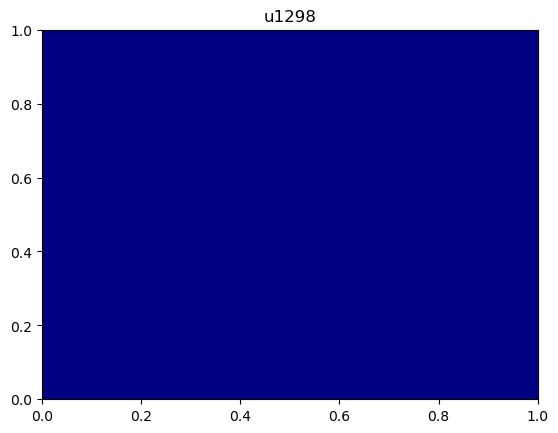

 17%|█████████████▊                                                                   | 17/100 [00:26<02:04,  1.51s/it]

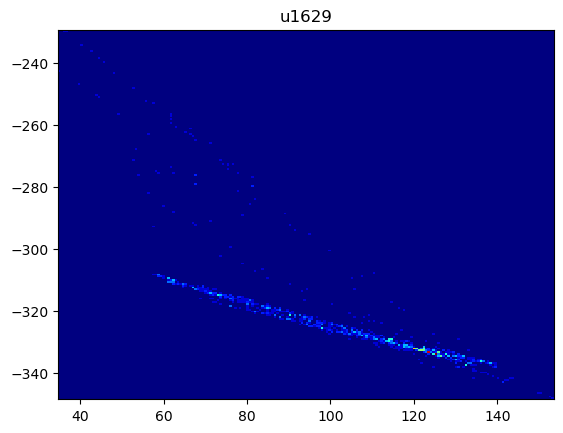

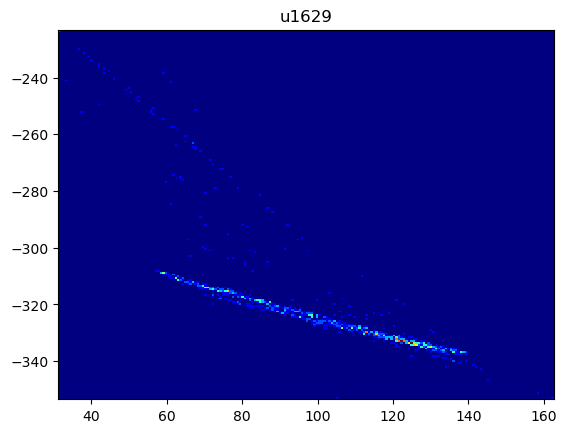

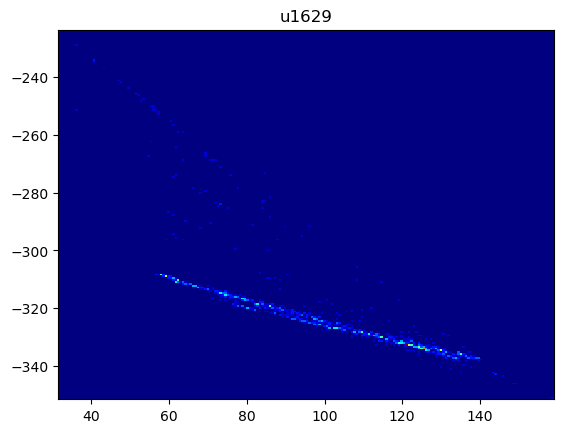

 18%|██████████████▌                                                                  | 18/100 [00:28<02:00,  1.48s/it]

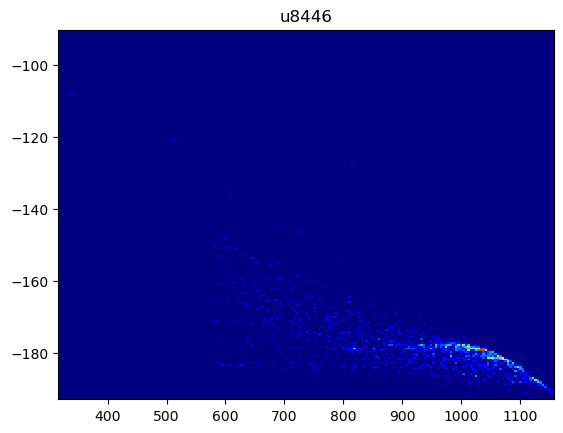

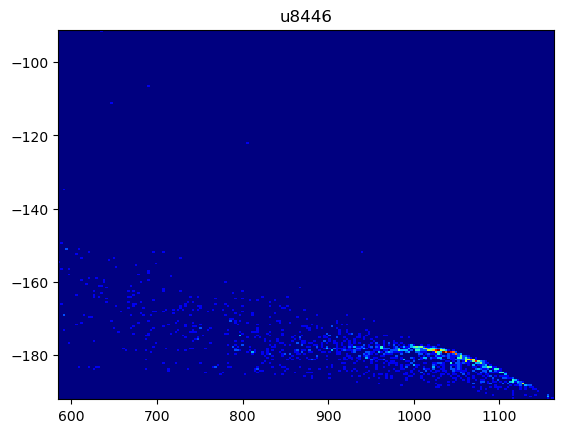

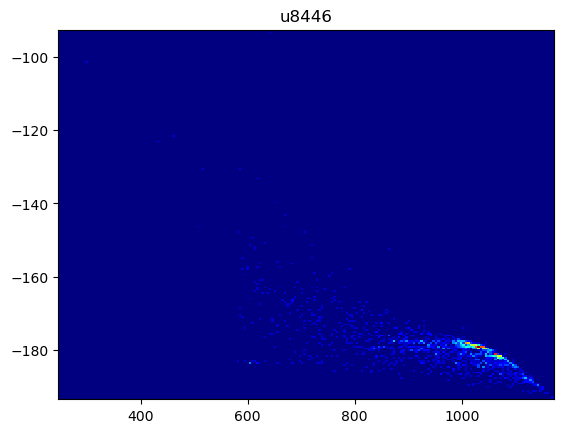

 19%|███████████████▍                                                                 | 19/100 [00:29<01:58,  1.46s/it]

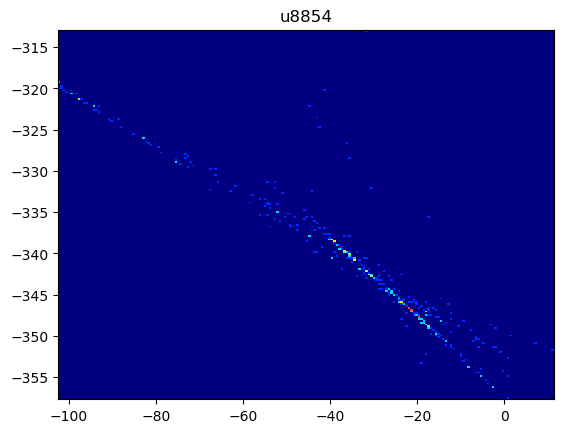

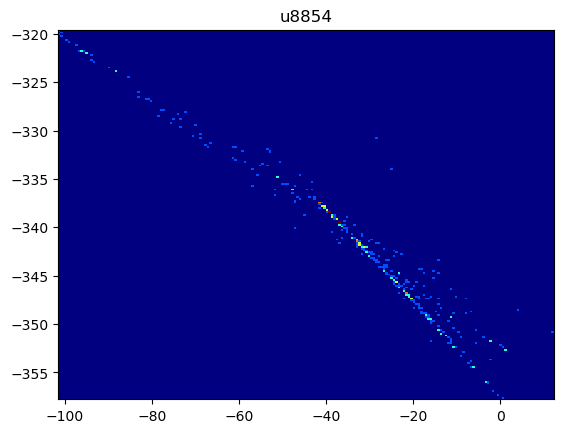

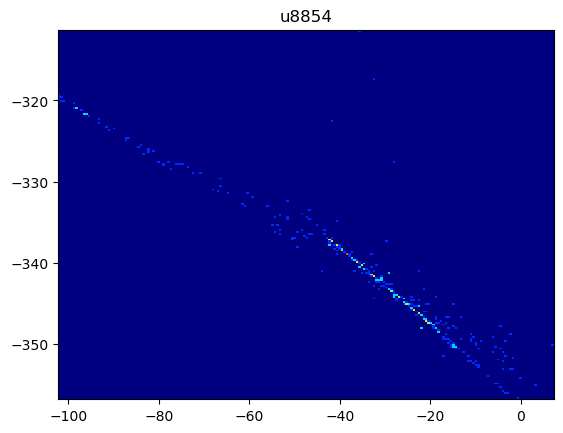

 20%|████████████████▏                                                                | 20/100 [00:31<01:56,  1.46s/it]

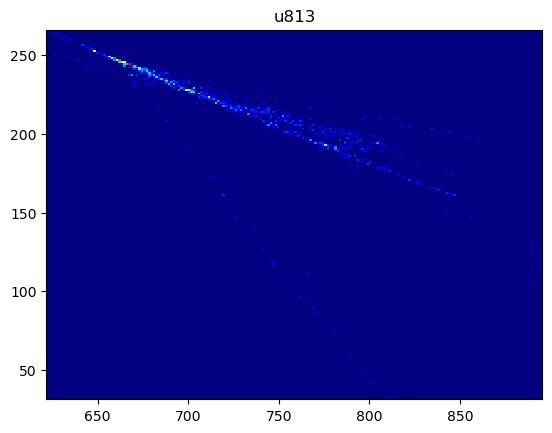

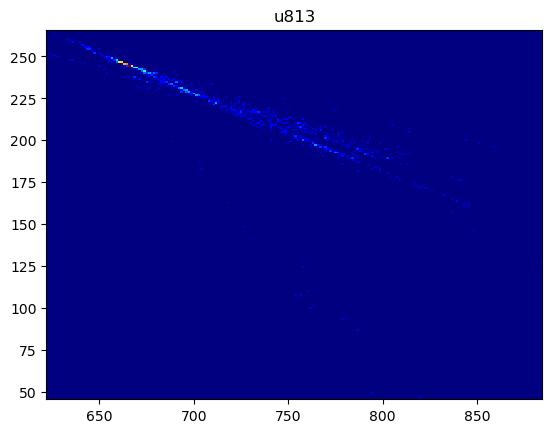

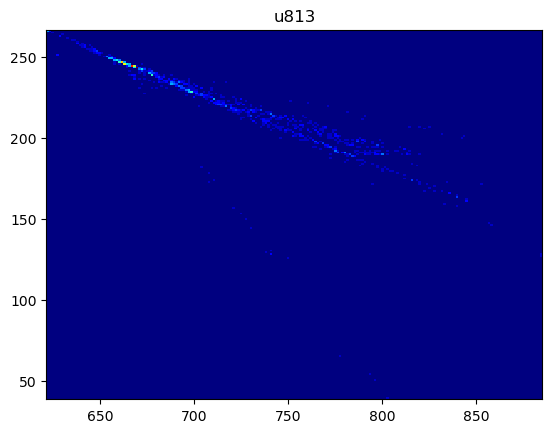

 21%|█████████████████                                                                | 21/100 [00:32<01:54,  1.45s/it]

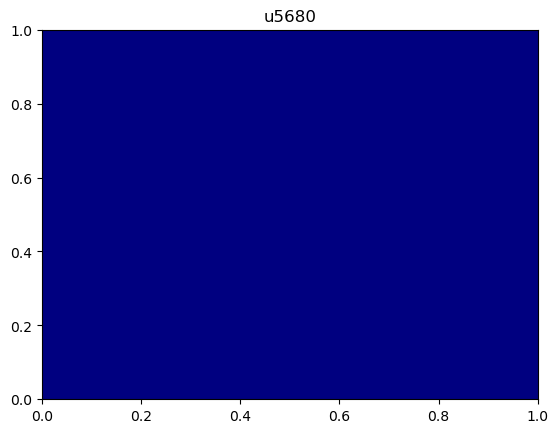

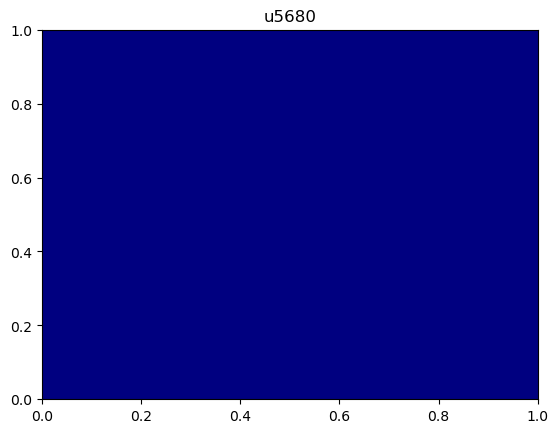

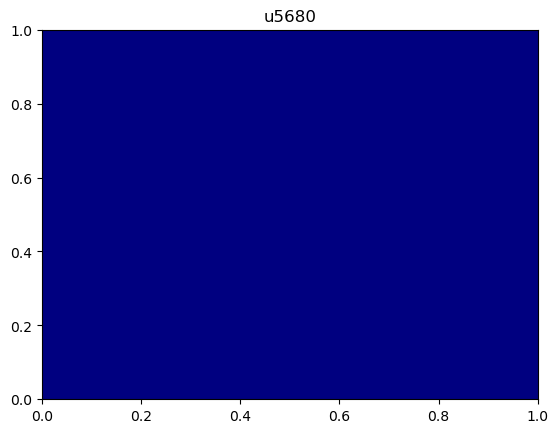

 22%|█████████████████▊                                                               | 22/100 [00:34<01:53,  1.45s/it]

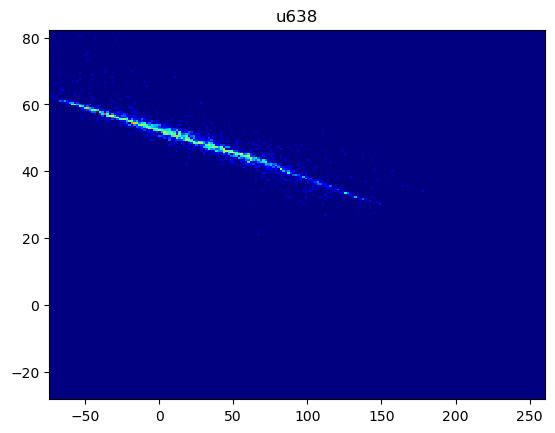

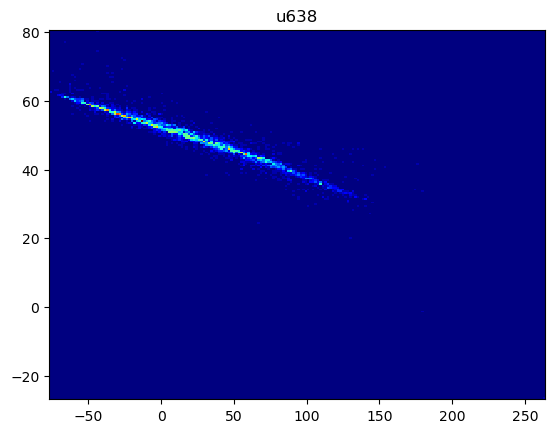

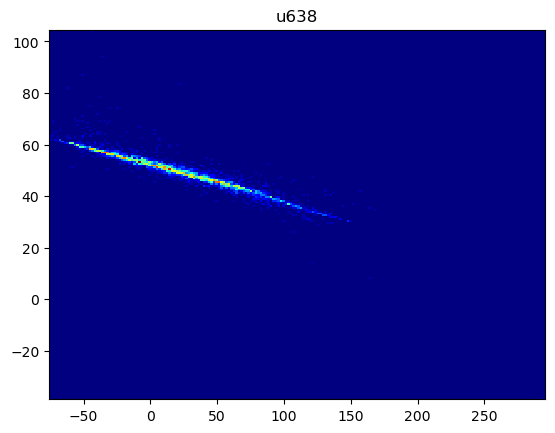

 23%|██████████████████▋                                                              | 23/100 [00:35<01:57,  1.52s/it]

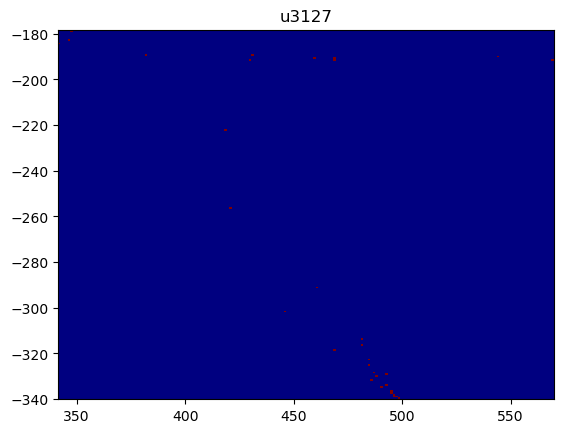

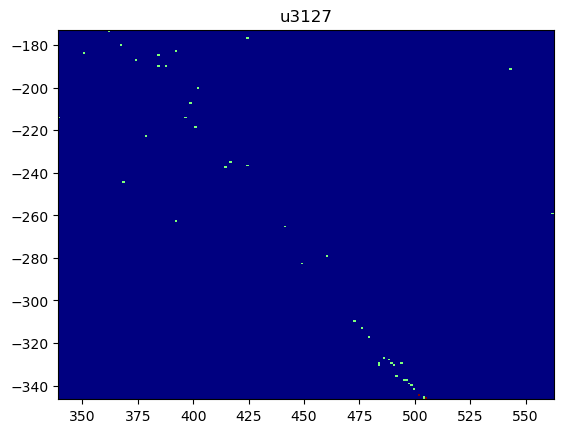

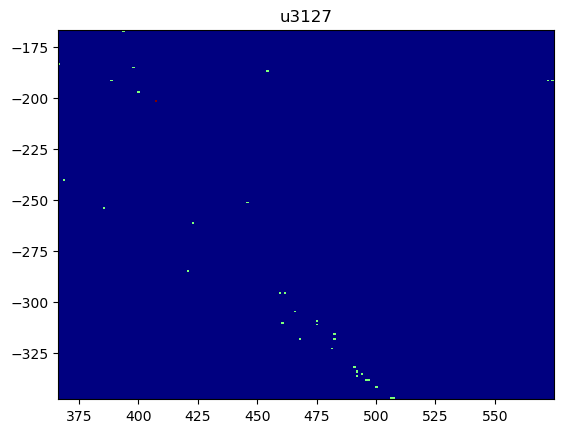

 24%|███████████████████▍                                                             | 24/100 [00:37<01:56,  1.53s/it]

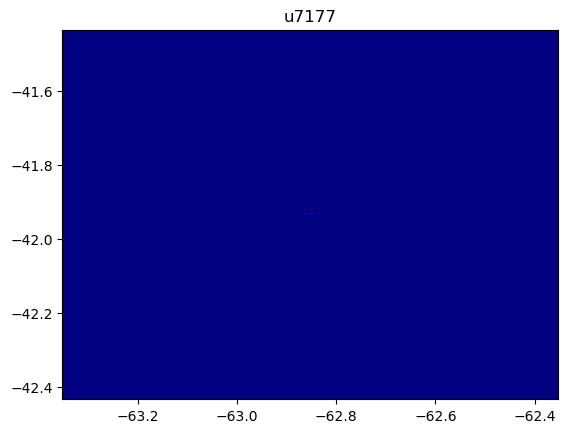

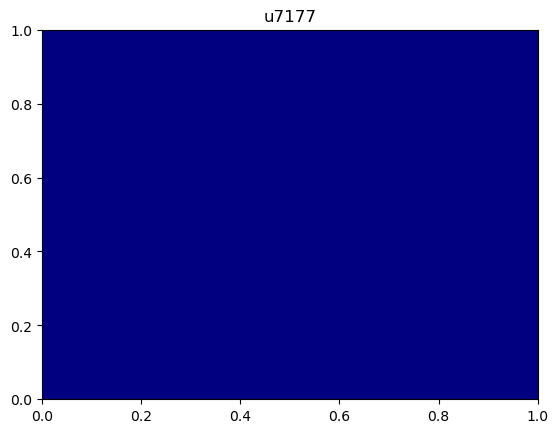

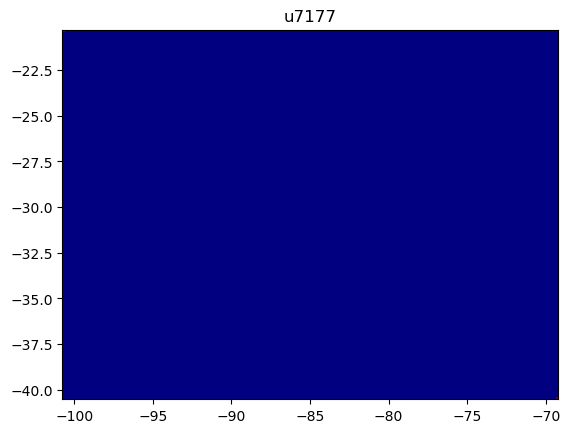

 25%|████████████████████▎                                                            | 25/100 [00:38<01:54,  1.52s/it]

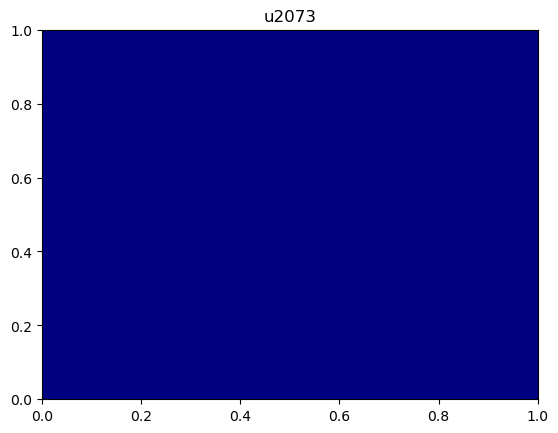

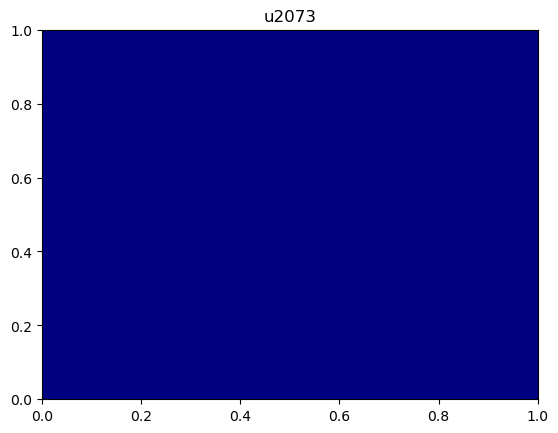

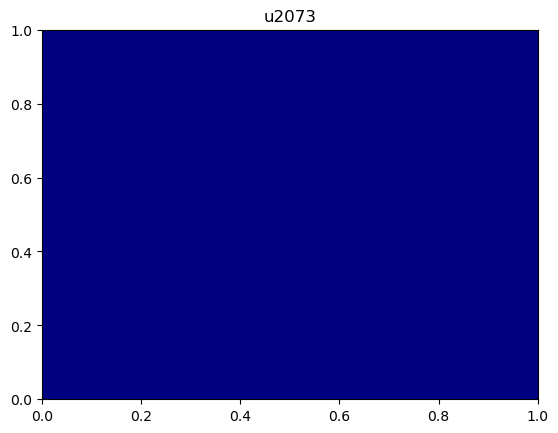

 26%|█████████████████████                                                            | 26/100 [00:40<01:49,  1.48s/it]

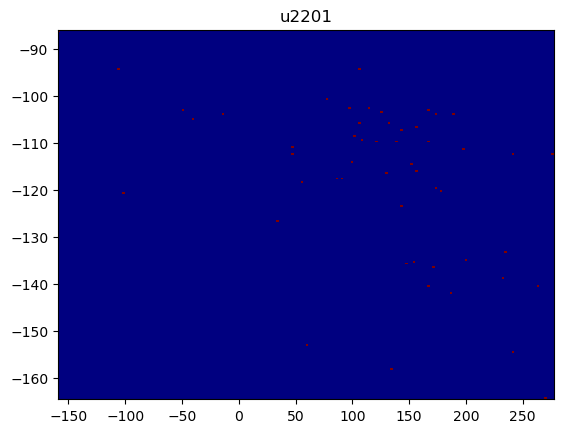

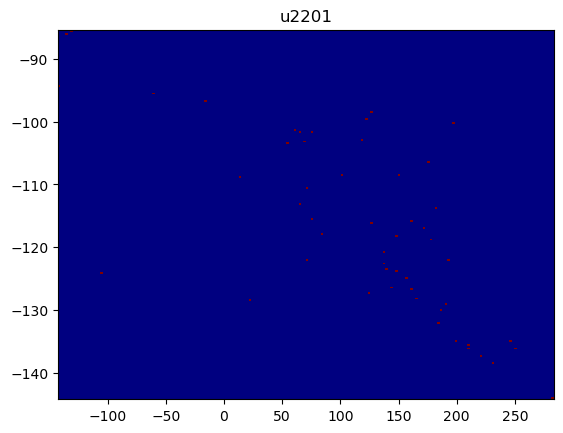

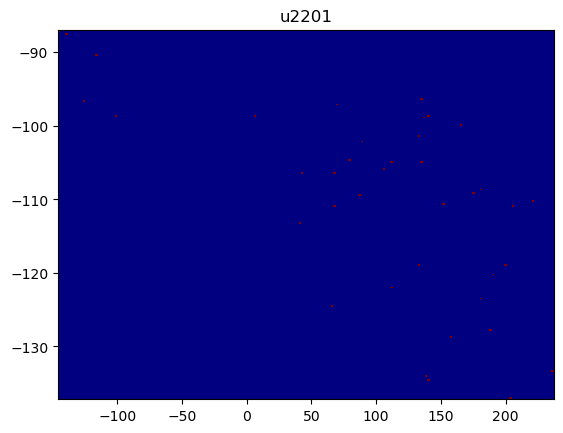

 27%|█████████████████████▊                                                           | 27/100 [00:41<01:48,  1.48s/it]

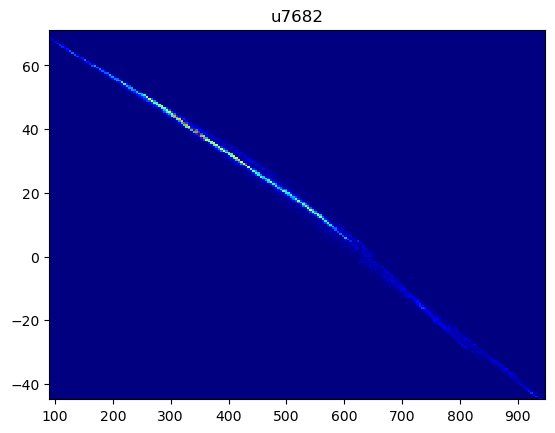

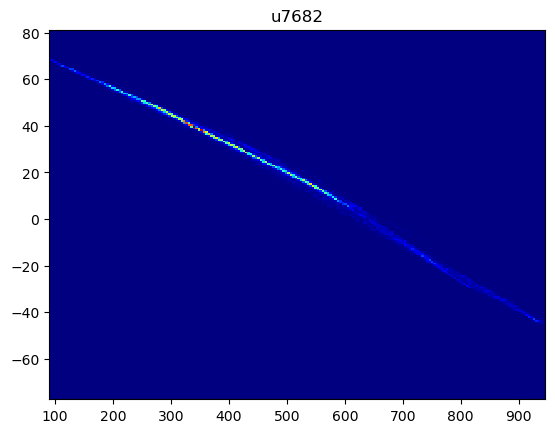

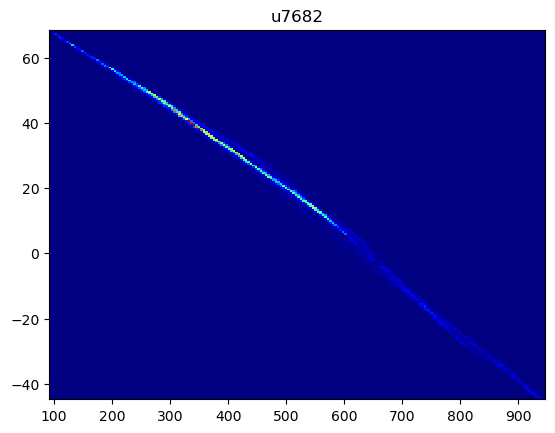

 28%|██████████████████████▋                                                          | 28/100 [00:43<01:49,  1.52s/it]

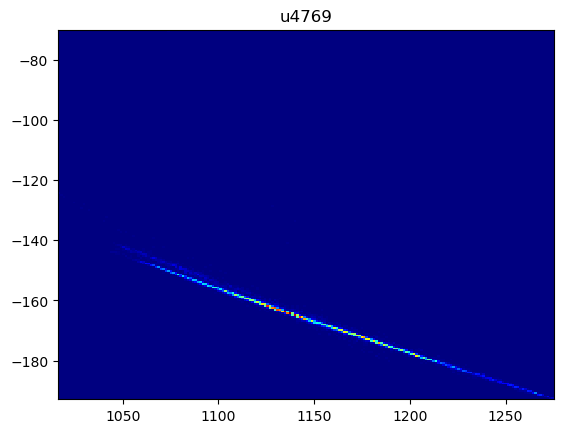

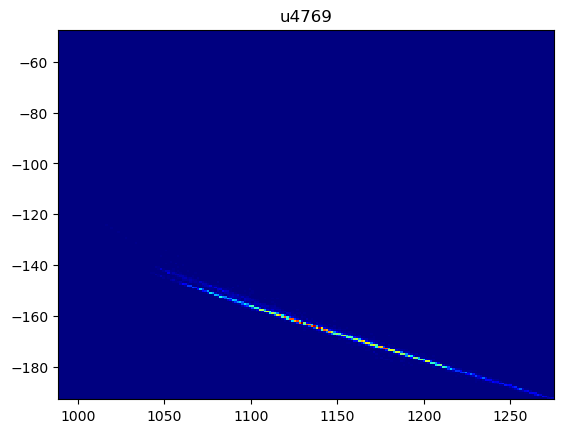

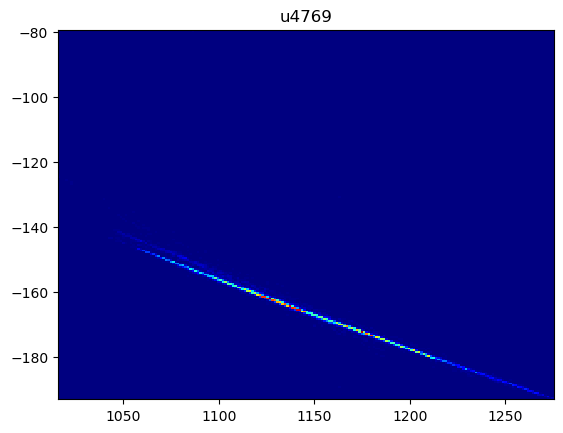

 29%|███████████████████████▍                                                         | 29/100 [00:44<01:47,  1.51s/it]

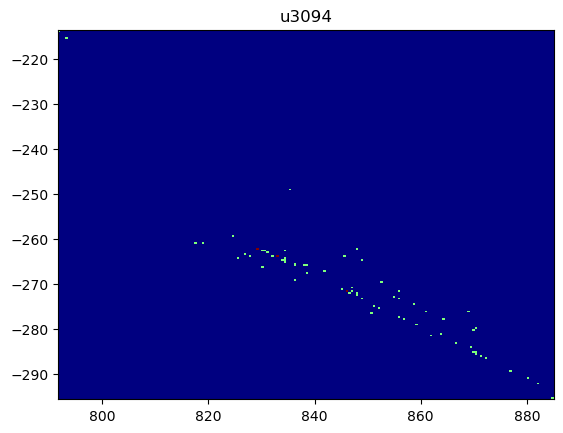

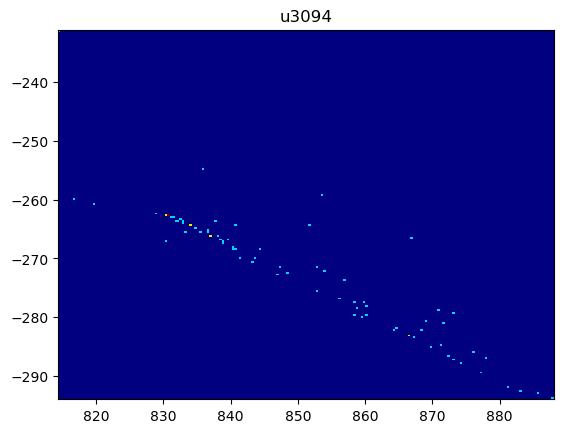

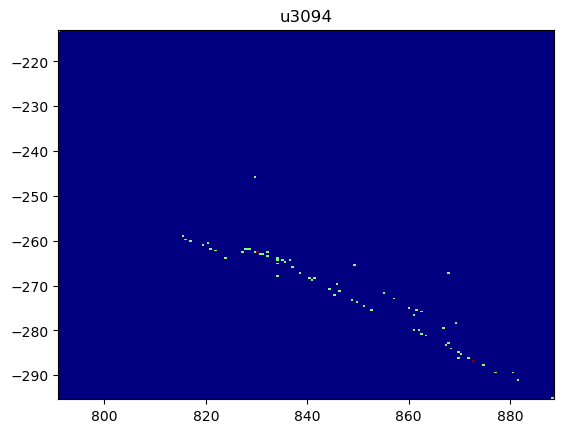

 30%|████████████████████████▎                                                        | 30/100 [00:46<01:44,  1.49s/it]

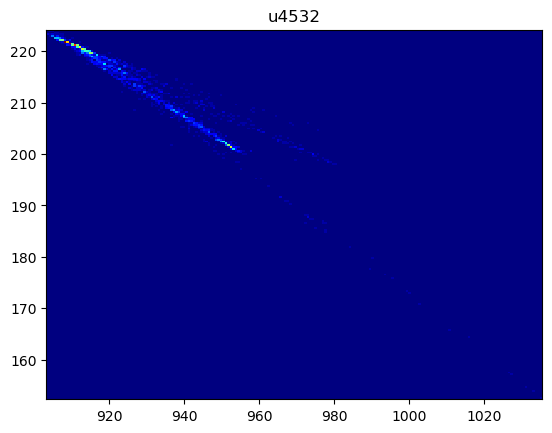

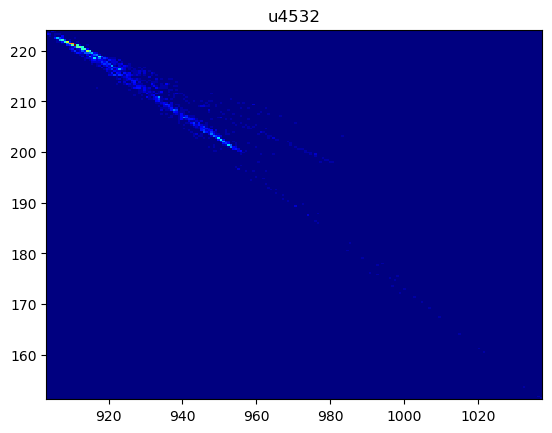

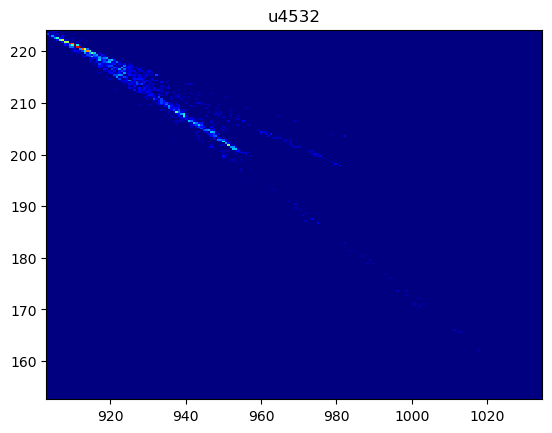

 31%|█████████████████████████                                                        | 31/100 [00:47<01:41,  1.47s/it]

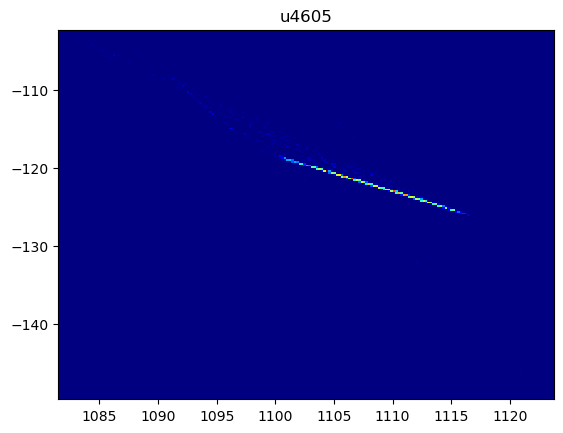

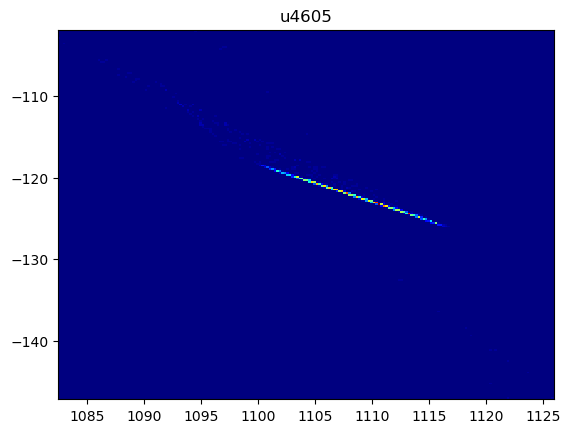

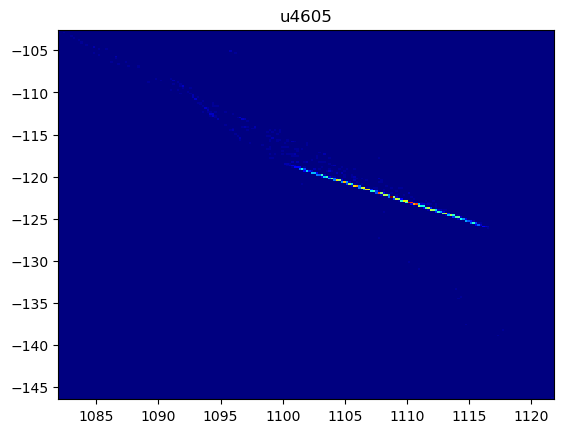

 32%|█████████████████████████▉                                                       | 32/100 [00:49<01:40,  1.47s/it]

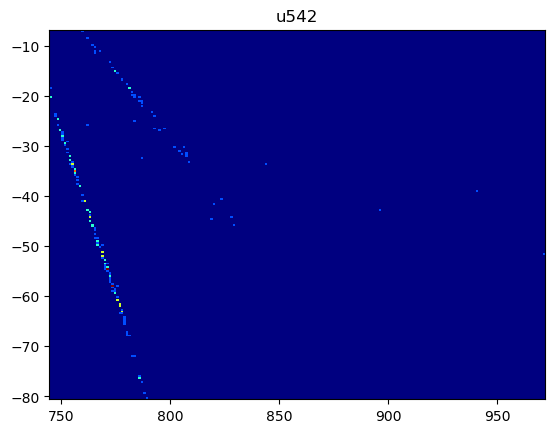

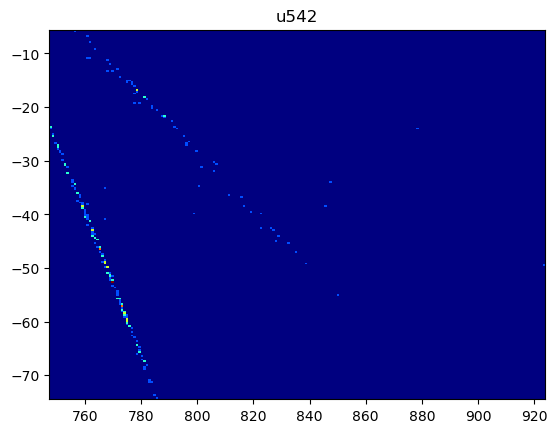

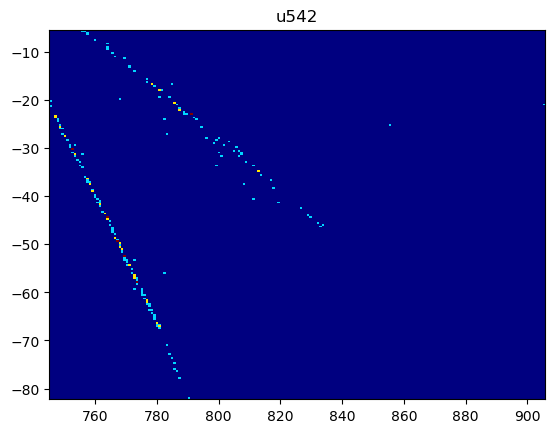

 33%|██████████████████████████▋                                                      | 33/100 [00:50<01:38,  1.48s/it]

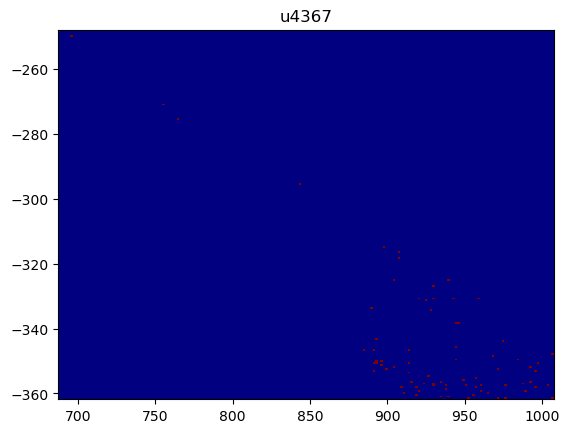

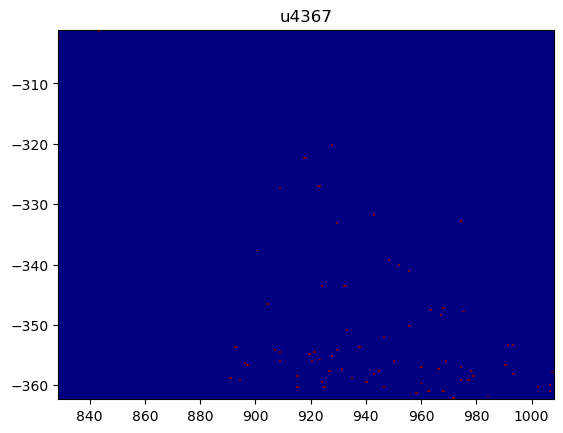

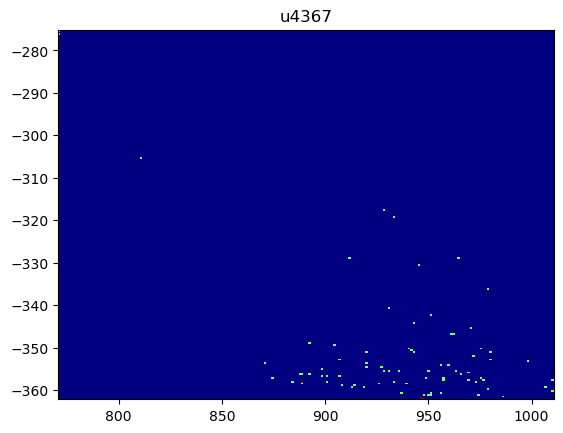

 34%|███████████████████████████▌                                                     | 34/100 [00:52<01:39,  1.51s/it]

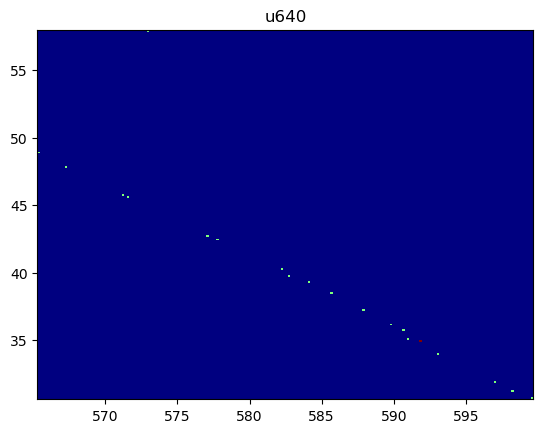

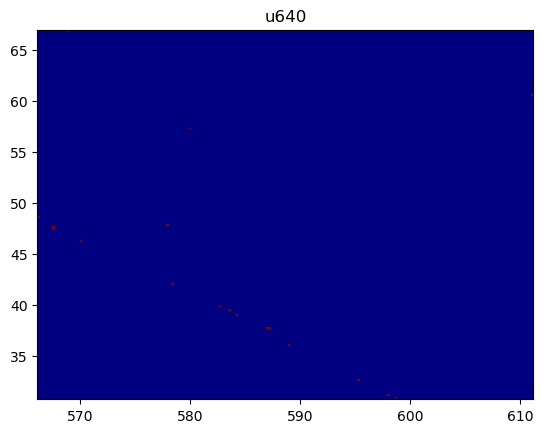

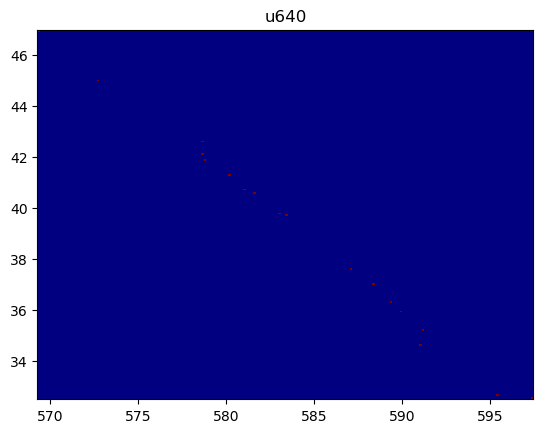

 35%|████████████████████████████▎                                                    | 35/100 [00:53<01:38,  1.51s/it]

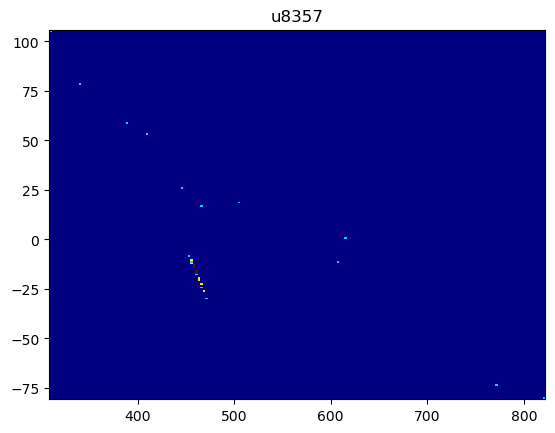

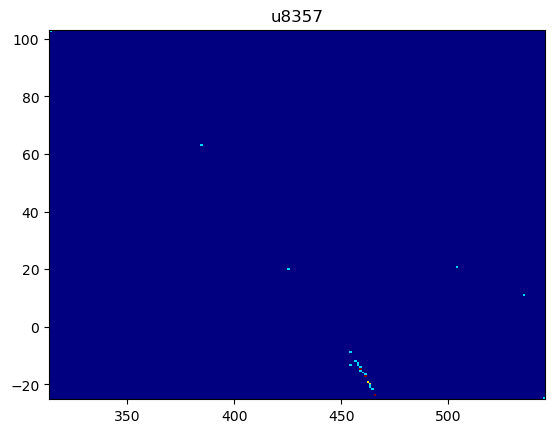

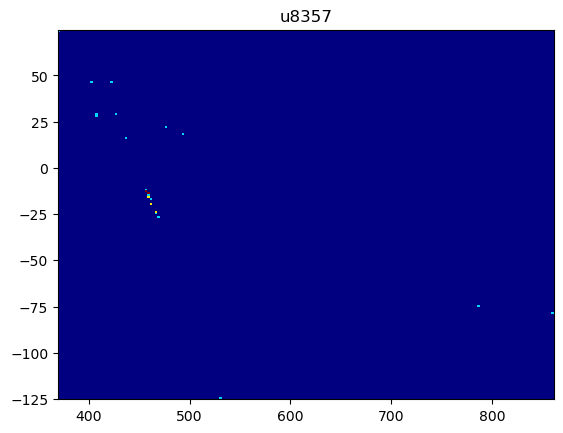

 36%|█████████████████████████████▏                                                   | 36/100 [00:55<01:35,  1.50s/it]

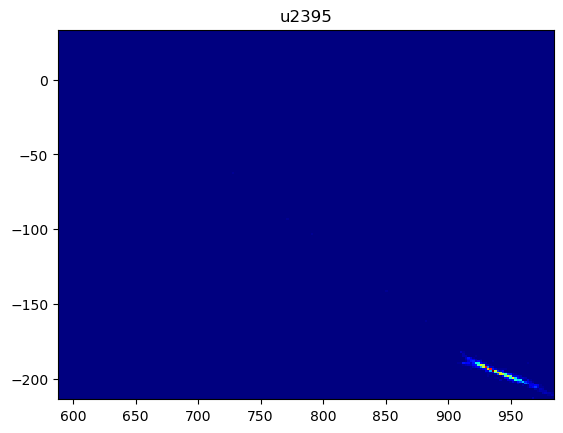

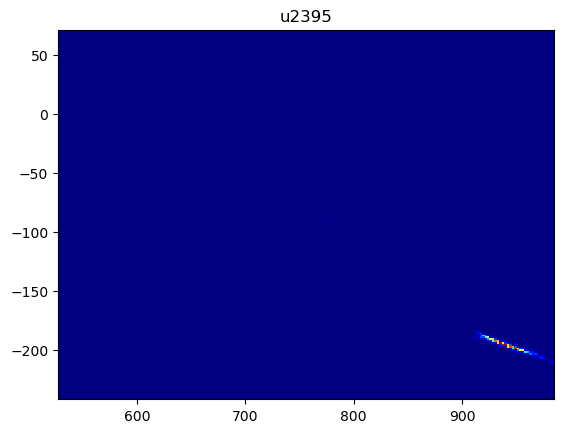

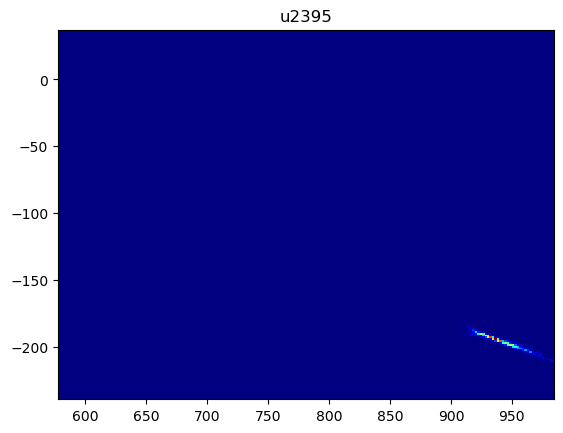

 37%|█████████████████████████████▉                                                   | 37/100 [00:56<01:33,  1.48s/it]

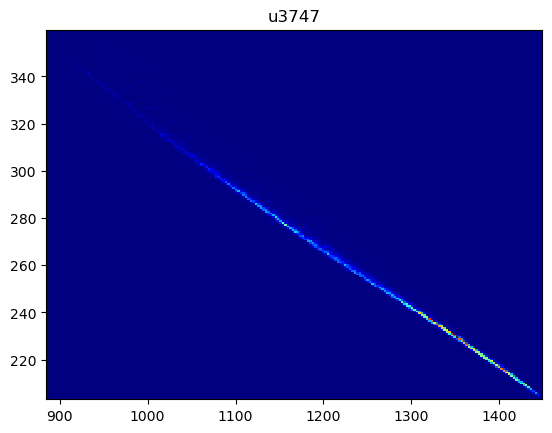

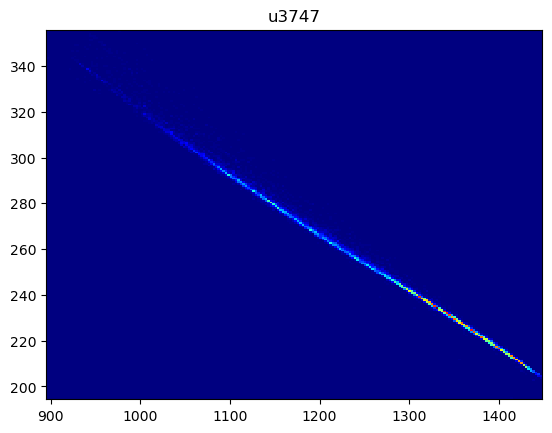

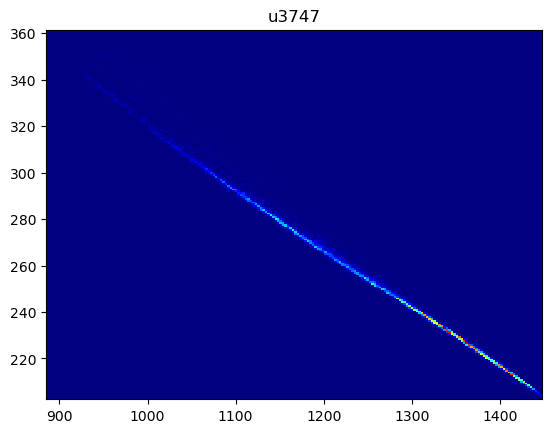

 38%|██████████████████████████████▊                                                  | 38/100 [00:58<01:35,  1.54s/it]

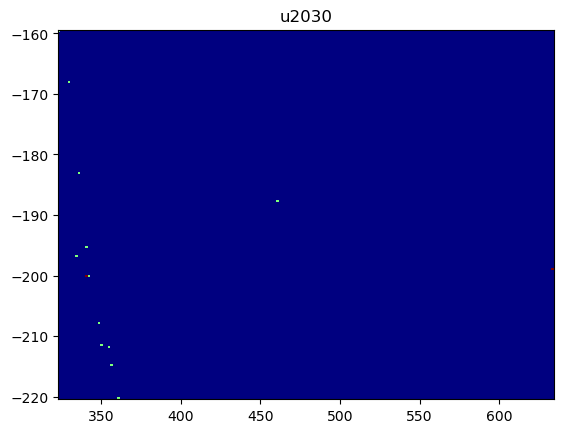

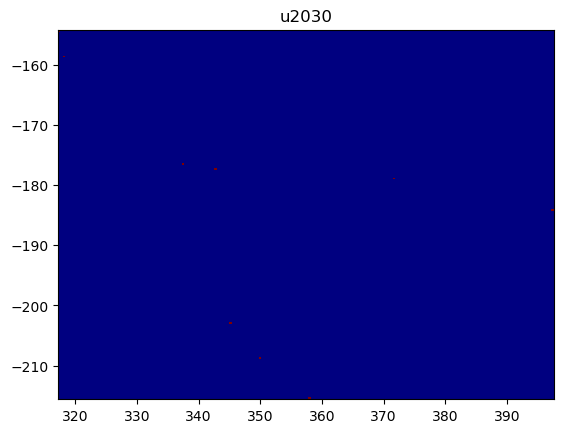

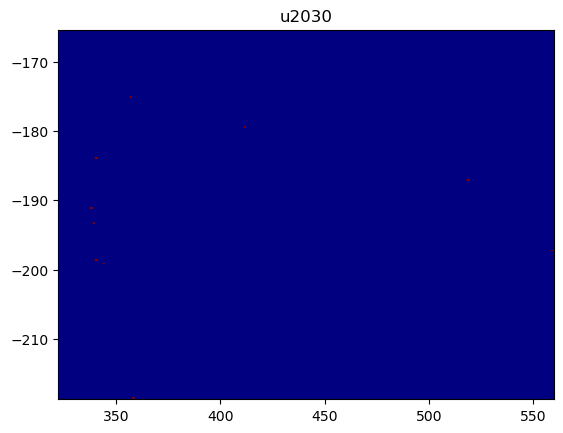

 39%|███████████████████████████████▌                                                 | 39/100 [00:59<01:32,  1.52s/it]

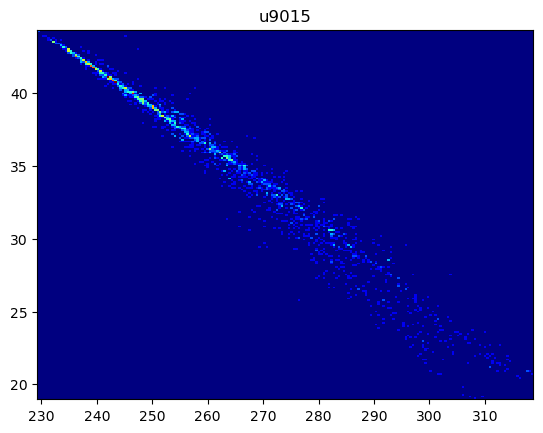

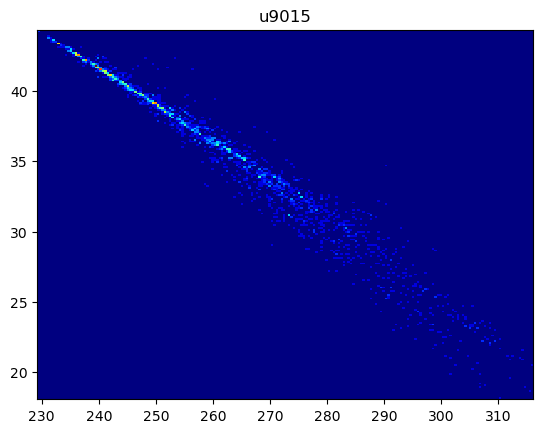

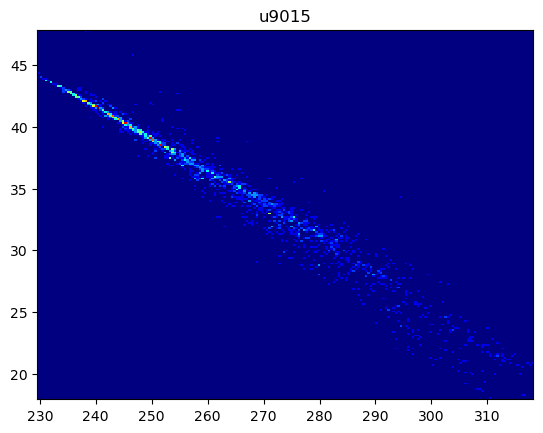

 40%|████████████████████████████████▍                                                | 40/100 [01:01<01:29,  1.50s/it]

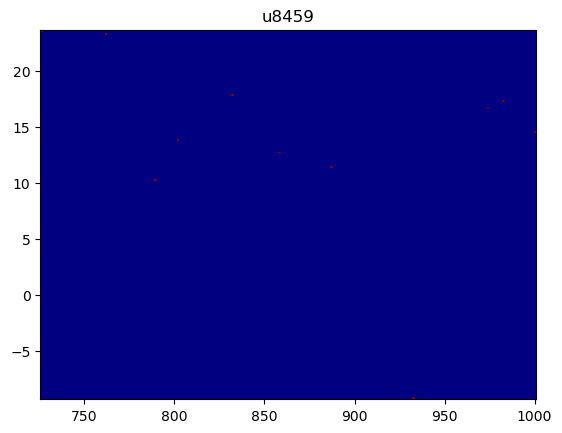

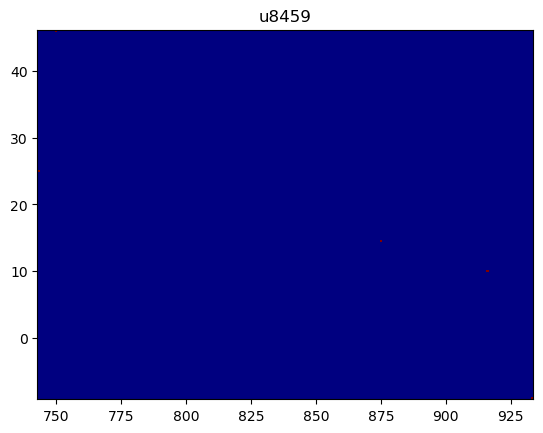

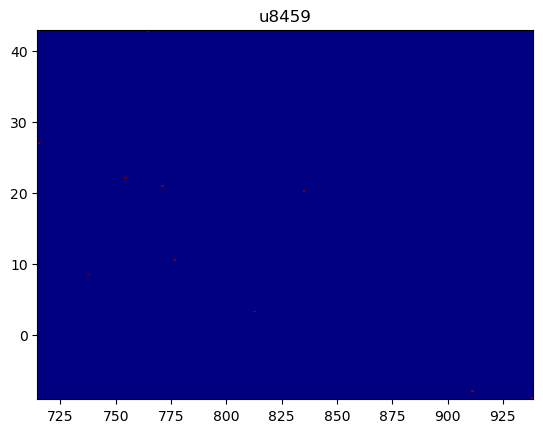

 41%|█████████████████████████████████▏                                               | 41/100 [01:02<01:28,  1.50s/it]

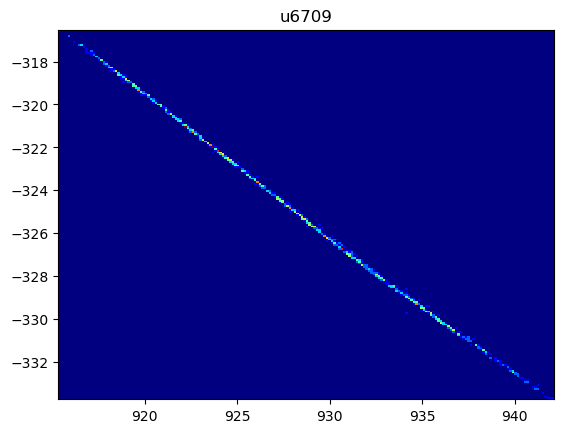

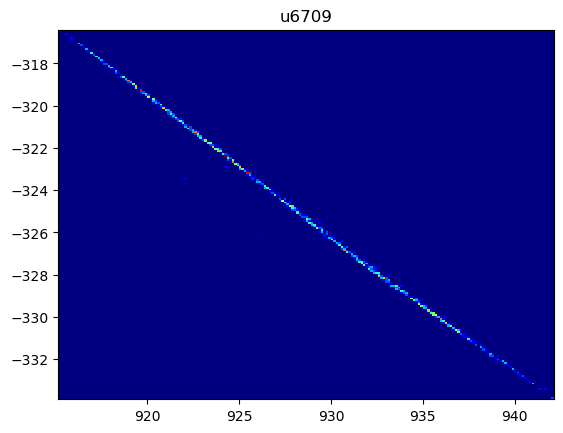

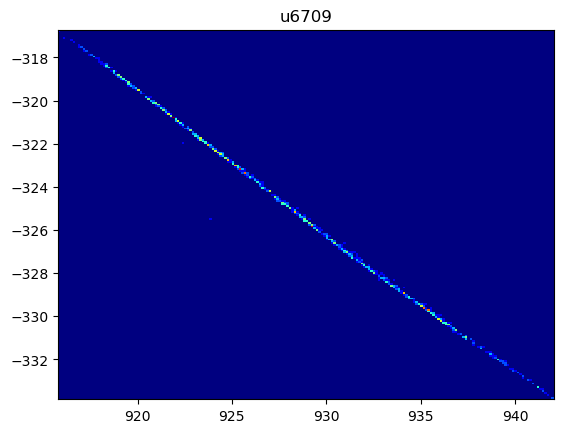

 42%|██████████████████████████████████                                               | 42/100 [01:04<01:25,  1.47s/it]

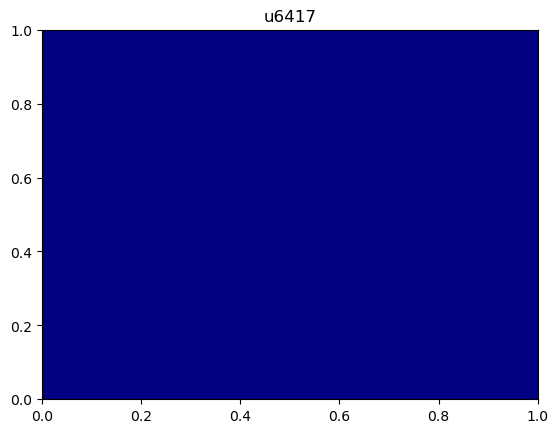

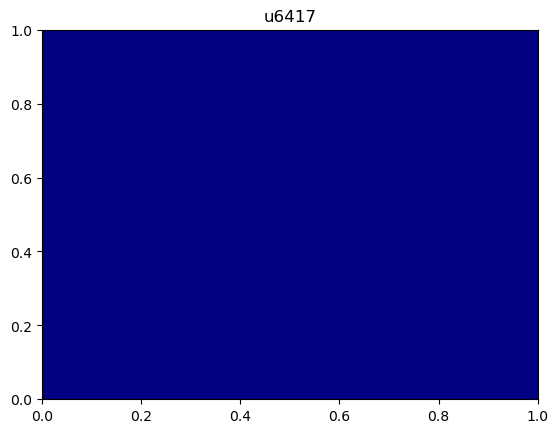

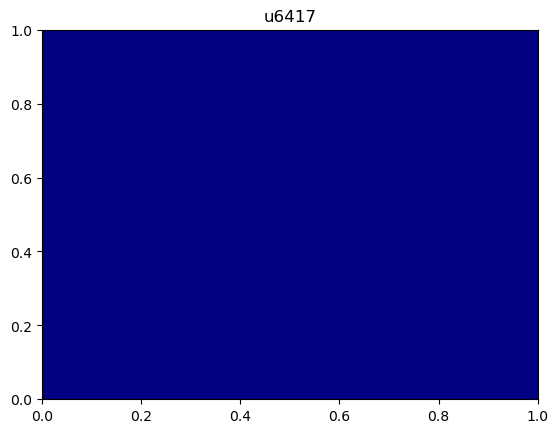

 43%|██████████████████████████████████▊                                              | 43/100 [01:05<01:24,  1.48s/it]

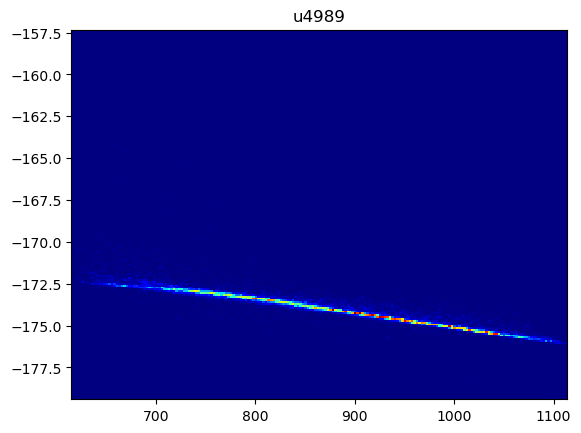

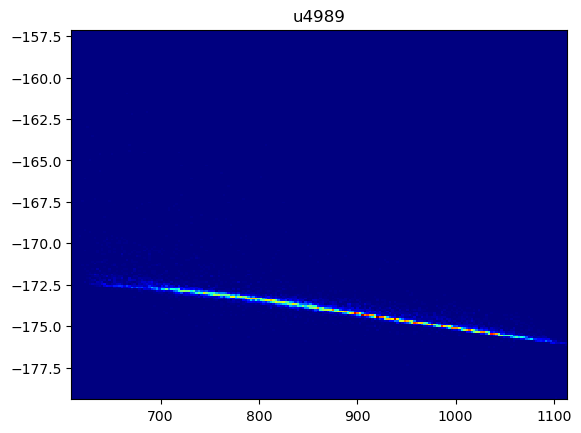

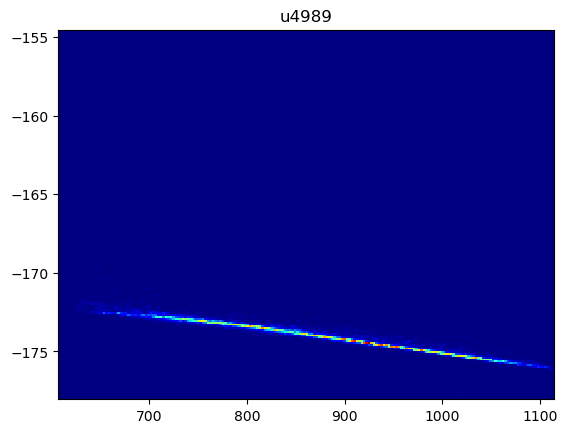

 44%|███████████████████████████████████▋                                             | 44/100 [01:07<01:29,  1.60s/it]

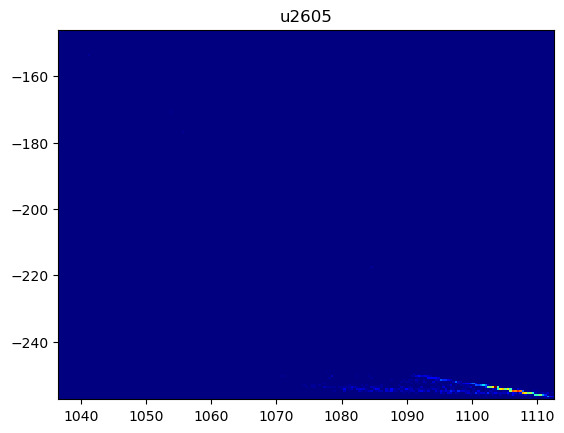

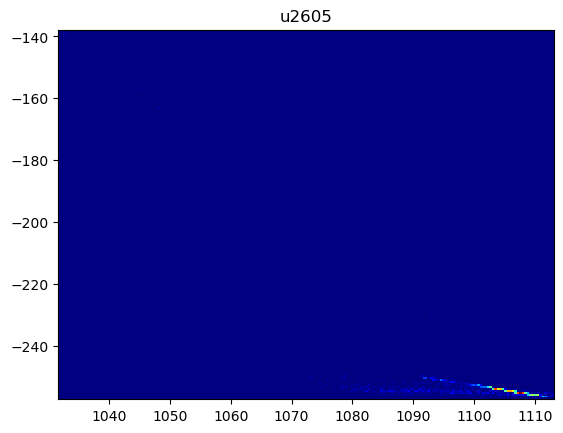

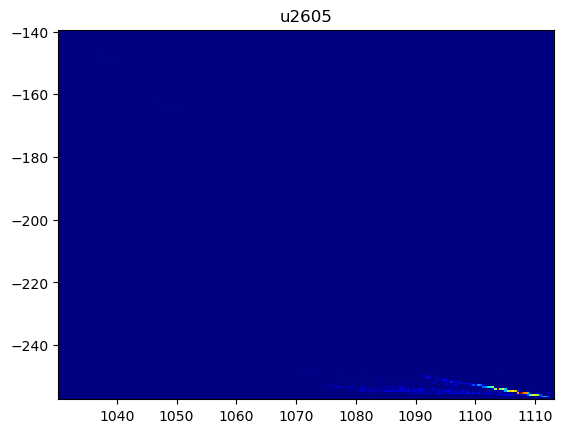

 45%|████████████████████████████████████▍                                            | 45/100 [01:09<01:26,  1.58s/it]

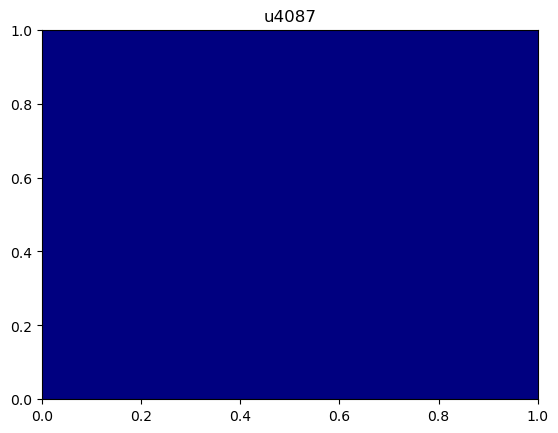

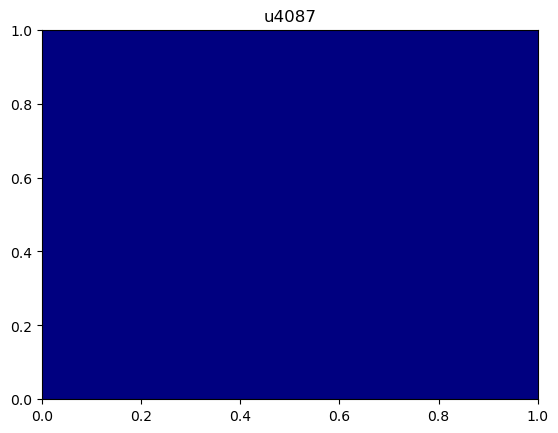

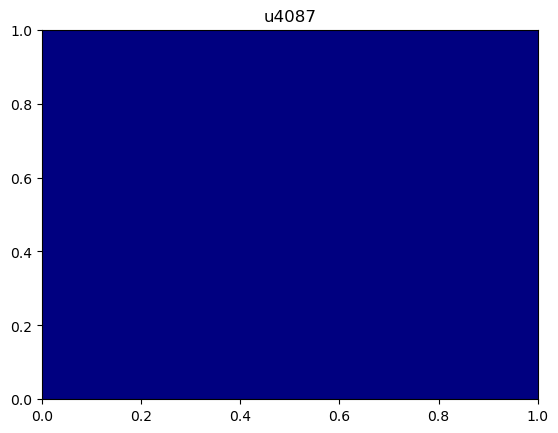

 46%|█████████████████████████████████████▎                                           | 46/100 [01:10<01:29,  1.65s/it]

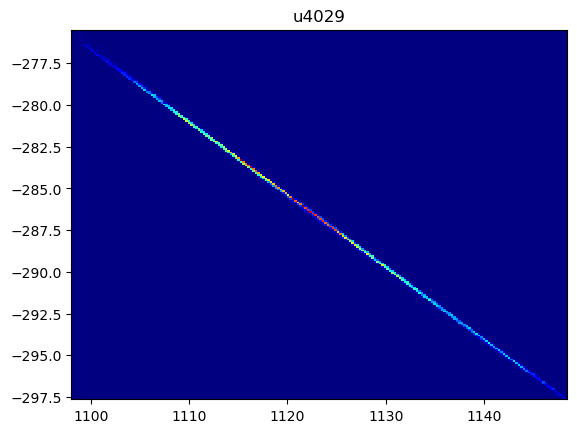

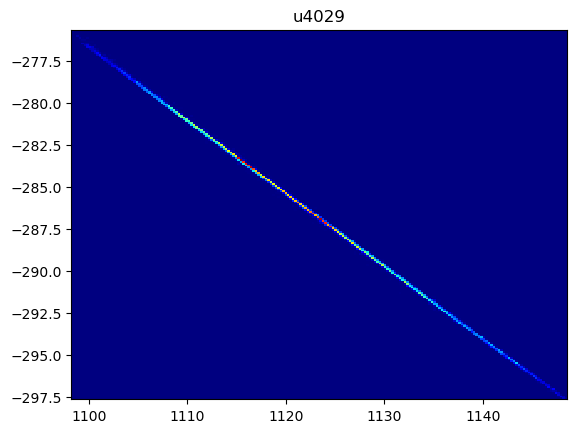

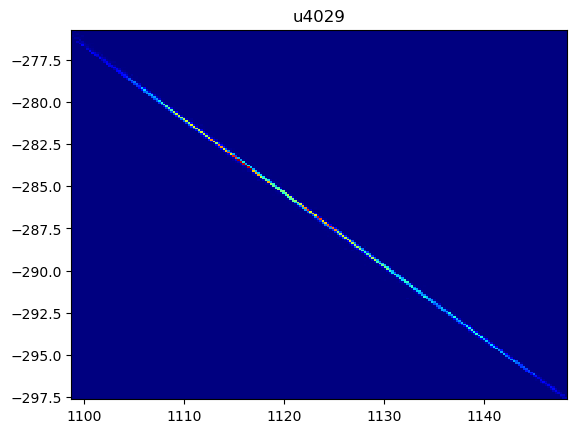

 47%|██████████████████████████████████████                                           | 47/100 [01:12<01:26,  1.63s/it]

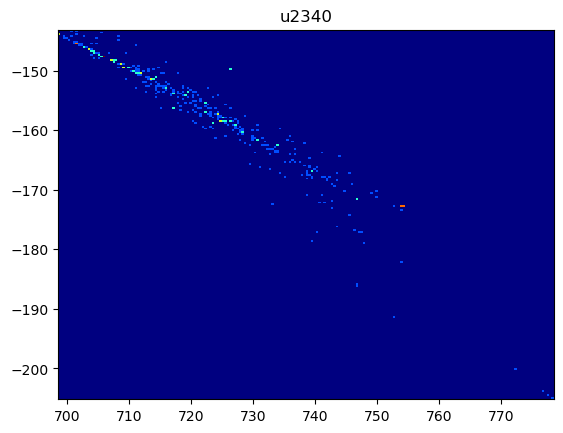

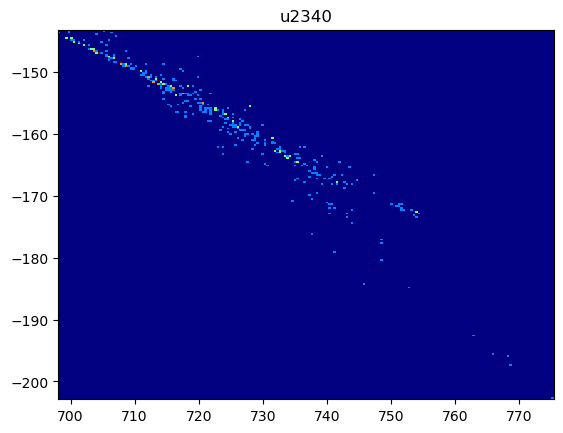

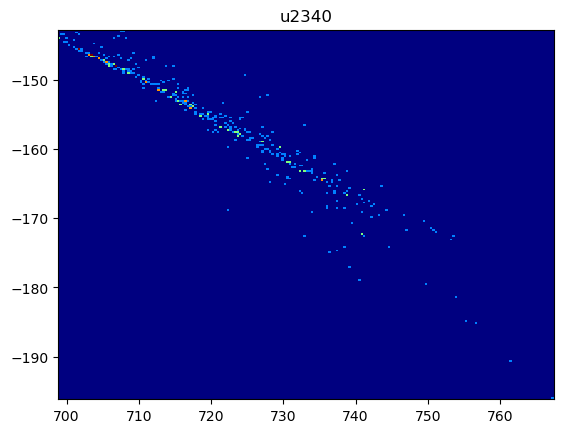

 48%|██████████████████████████████████████▉                                          | 48/100 [01:13<01:22,  1.59s/it]

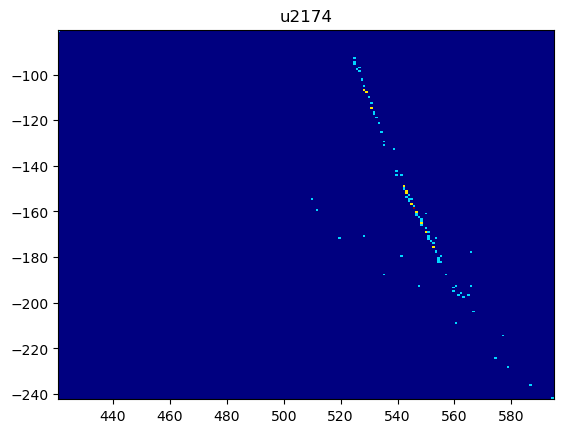

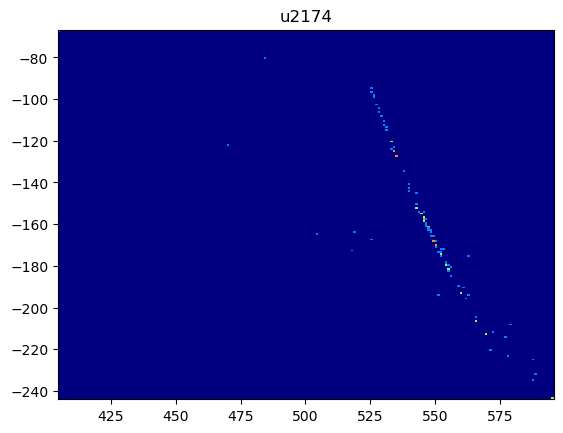

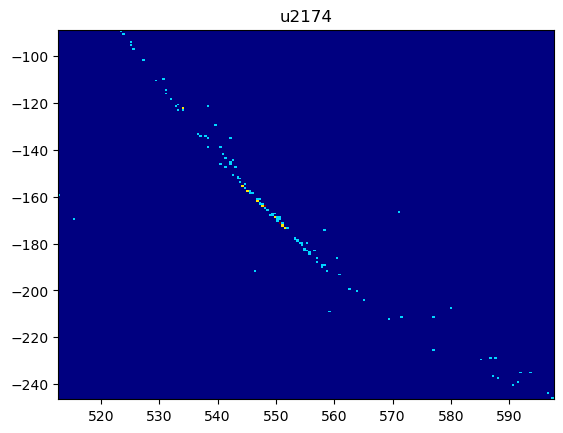

 49%|███████████████████████████████████████▋                                         | 49/100 [01:15<01:19,  1.56s/it]

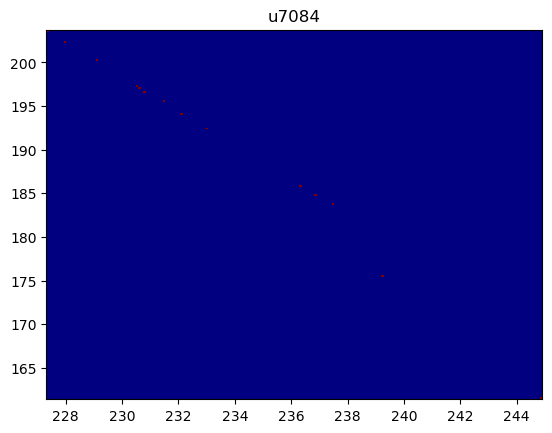

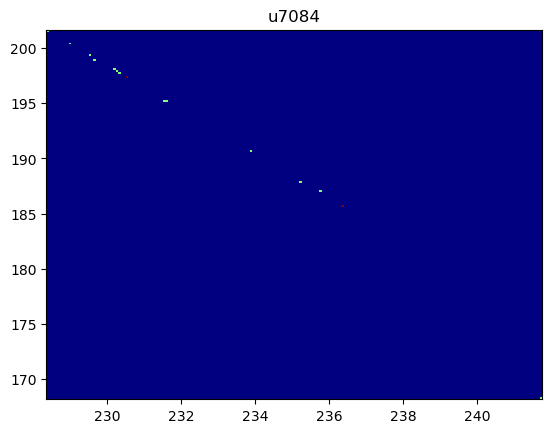

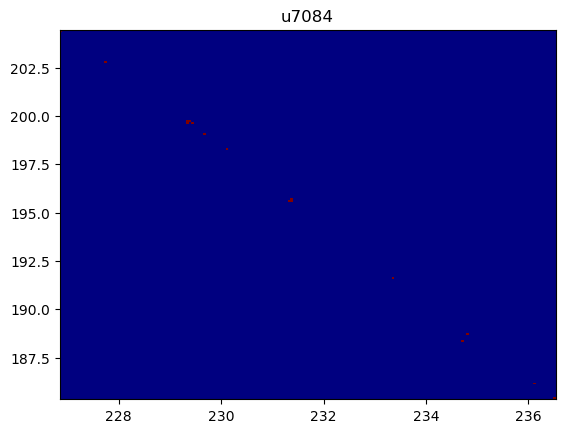

 50%|████████████████████████████████████████▌                                        | 50/100 [01:16<01:16,  1.54s/it]

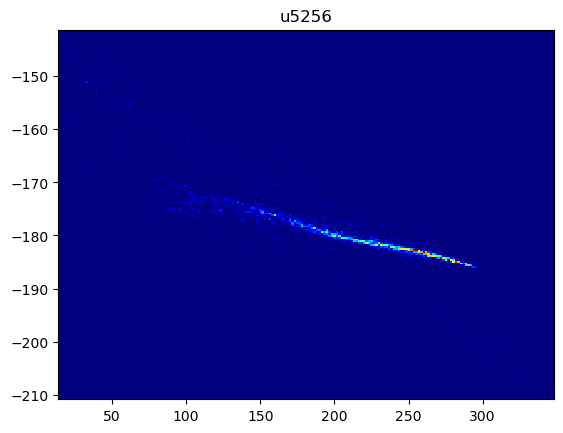

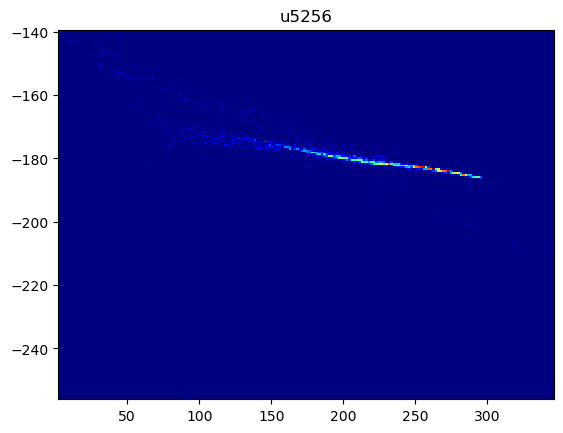

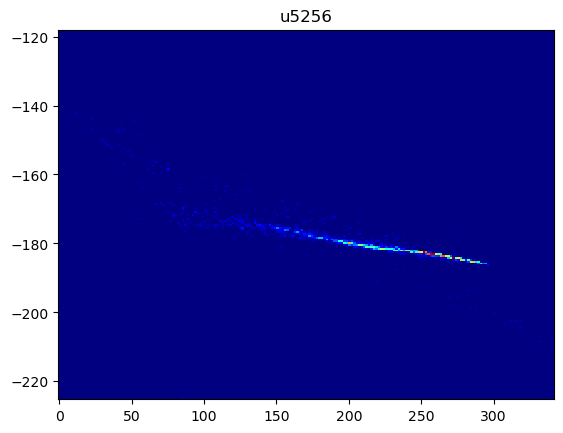

 51%|█████████████████████████████████████████▎                                       | 51/100 [01:18<01:14,  1.52s/it]

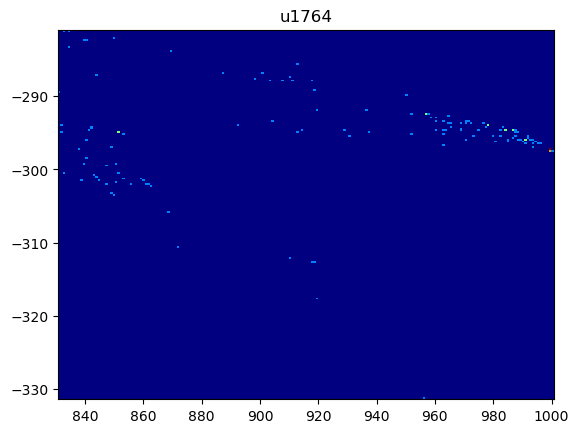

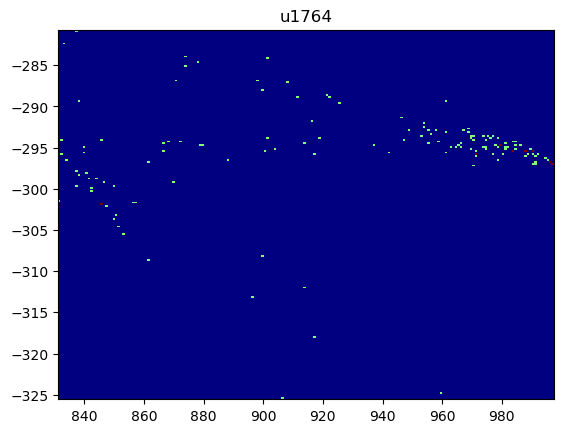

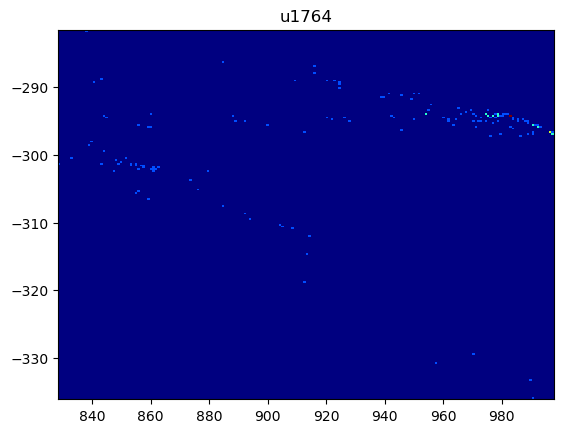

 52%|██████████████████████████████████████████                                       | 52/100 [01:19<01:12,  1.51s/it]

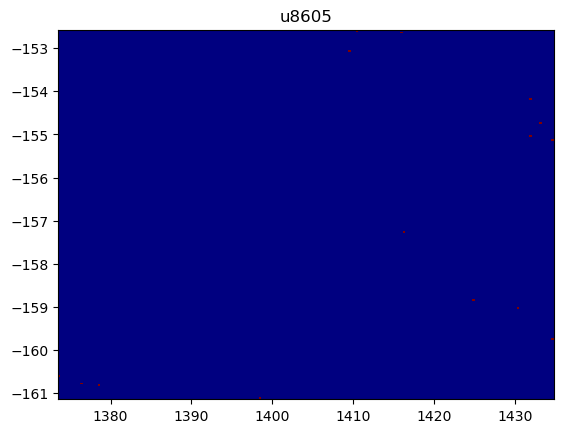

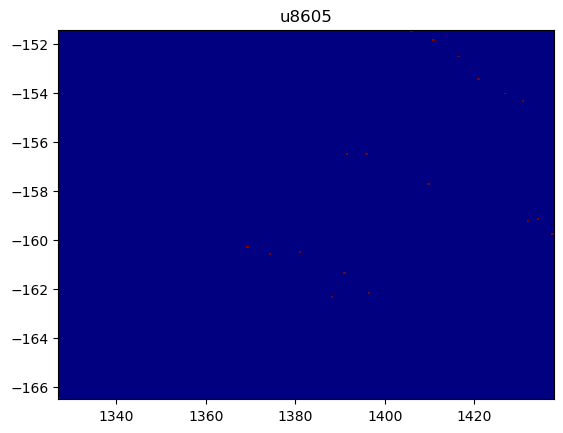

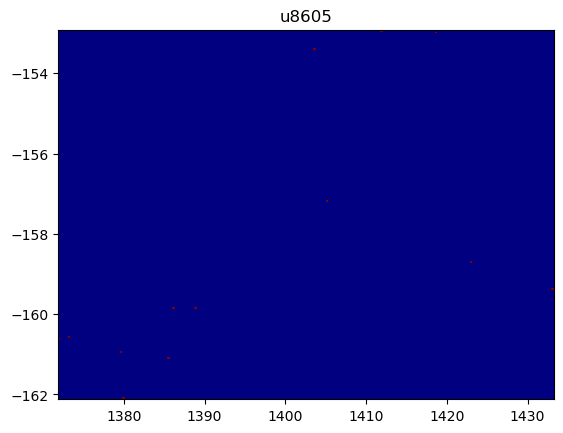

 53%|██████████████████████████████████████████▉                                      | 53/100 [01:21<01:09,  1.48s/it]

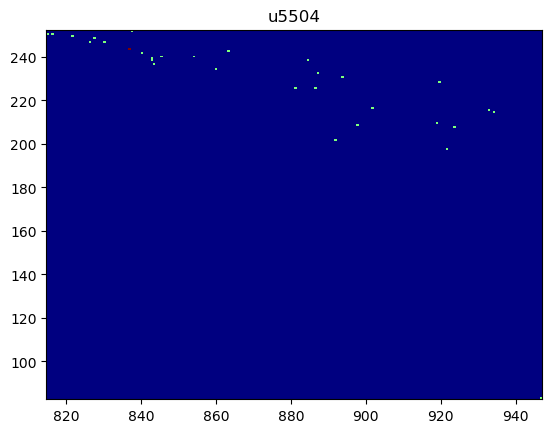

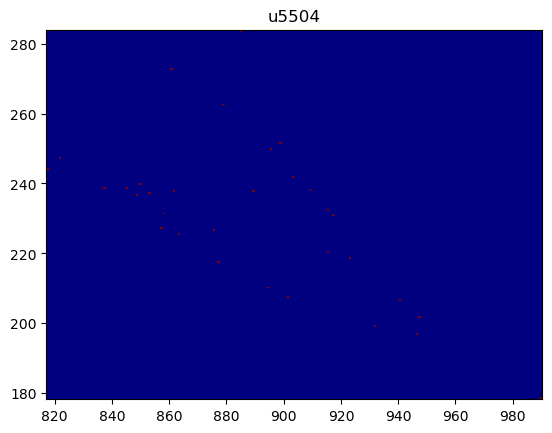

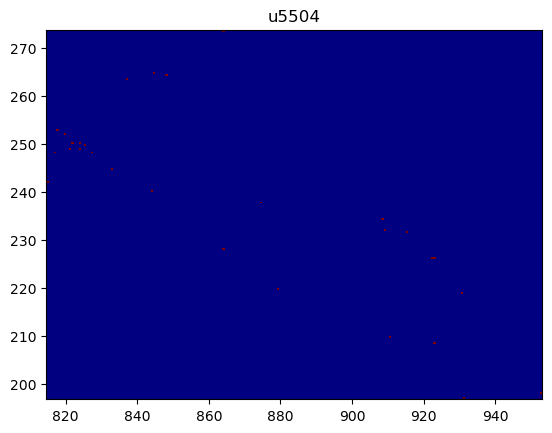

 54%|███████████████████████████████████████████▋                                     | 54/100 [01:22<01:08,  1.50s/it]

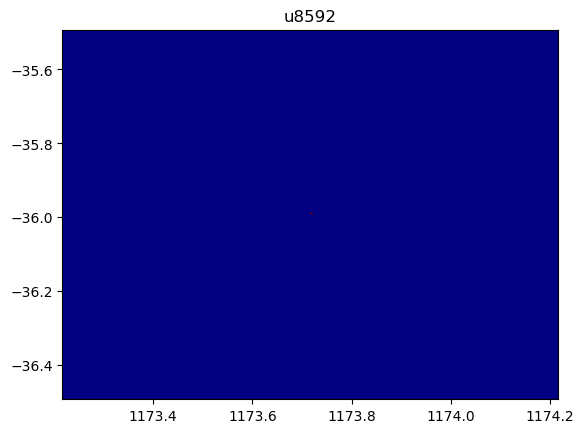

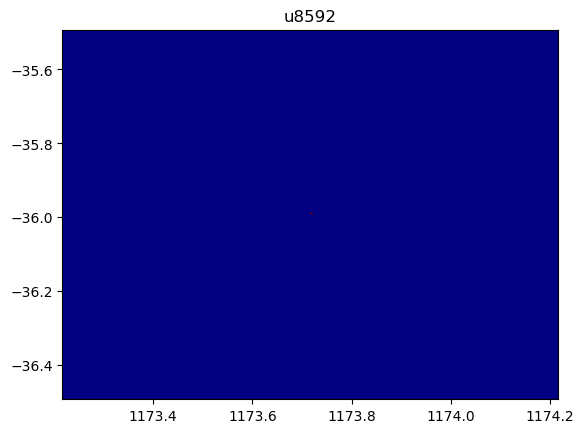

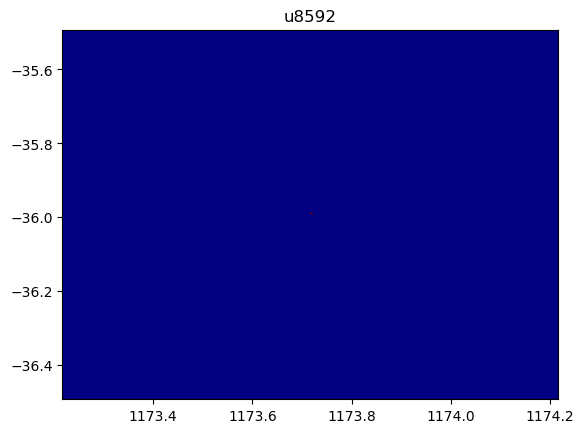

 55%|████████████████████████████████████████████▌                                    | 55/100 [01:24<01:03,  1.41s/it]

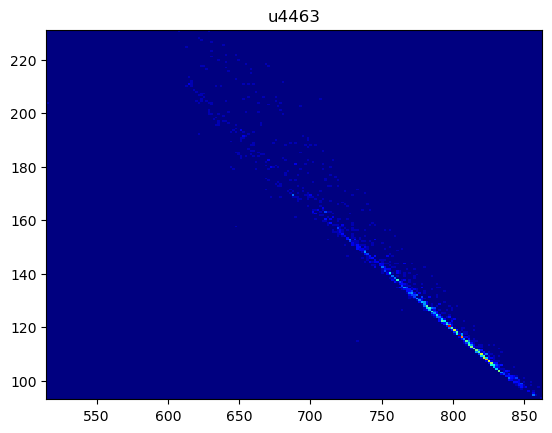

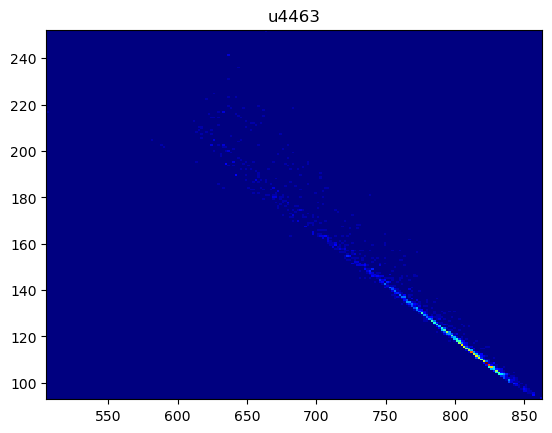

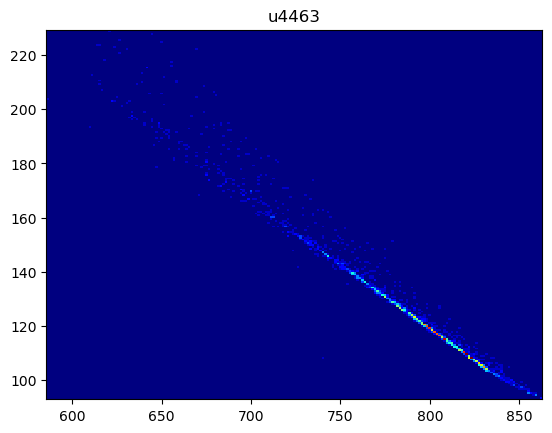

 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:25<01:02,  1.42s/it]

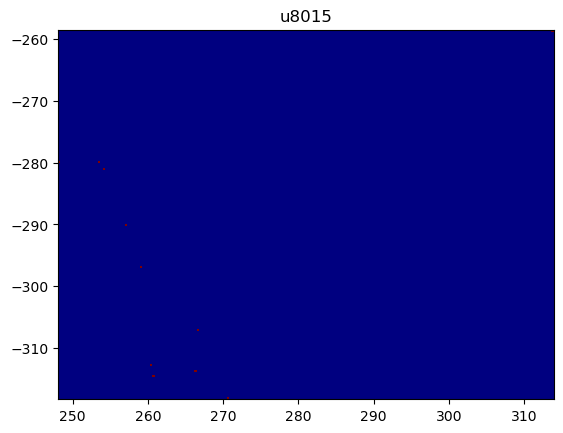

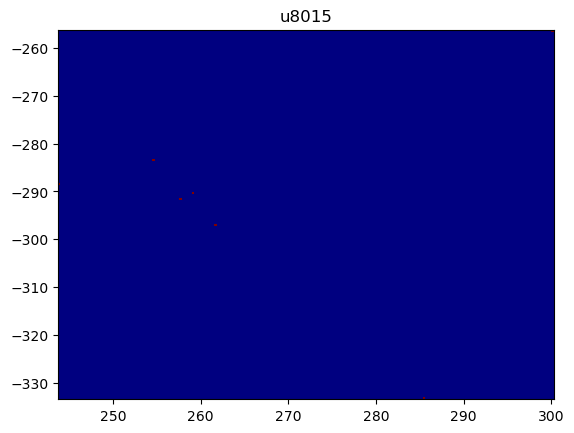

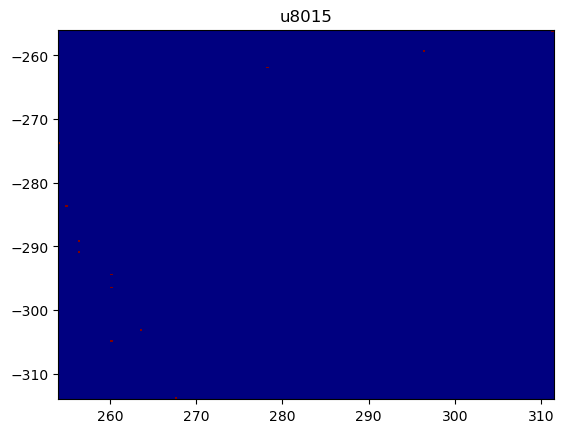

 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:26<01:00,  1.40s/it]

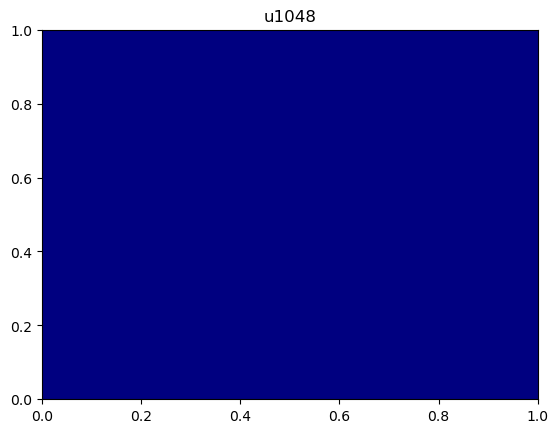

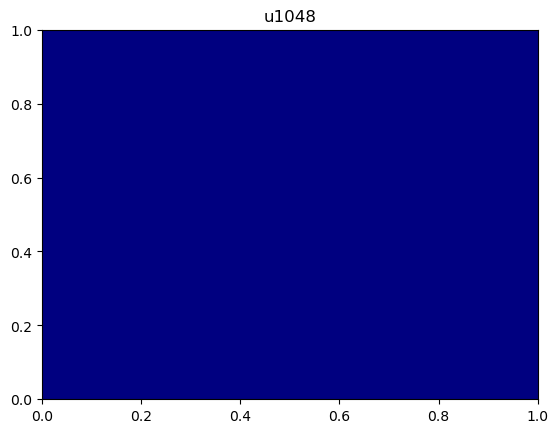

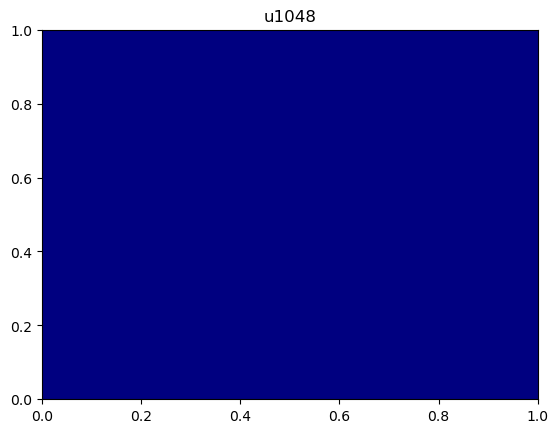

 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:28<00:58,  1.38s/it]

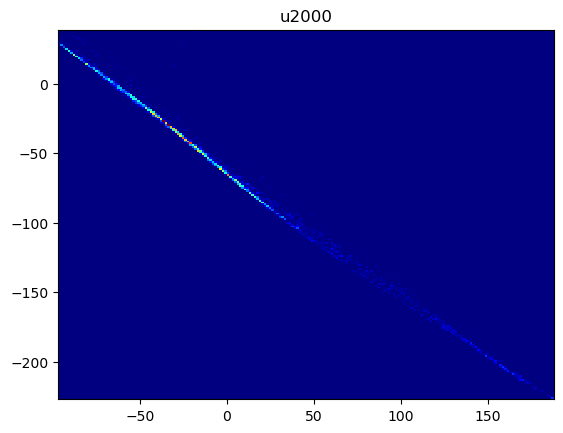

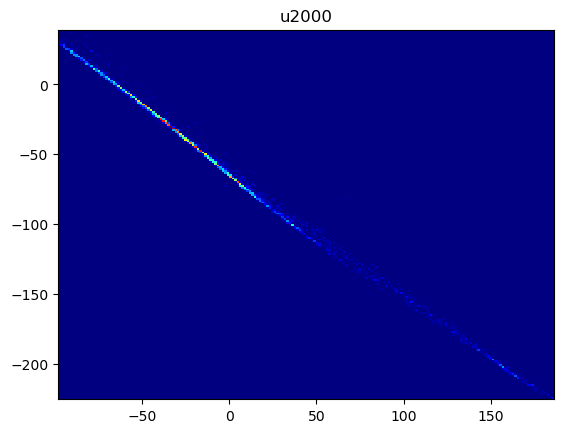

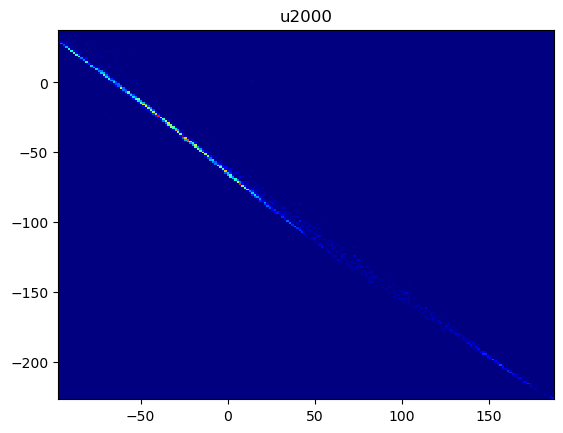

 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:29<00:56,  1.38s/it]

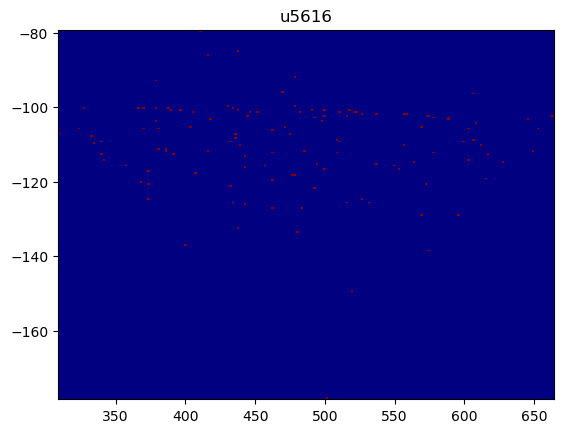

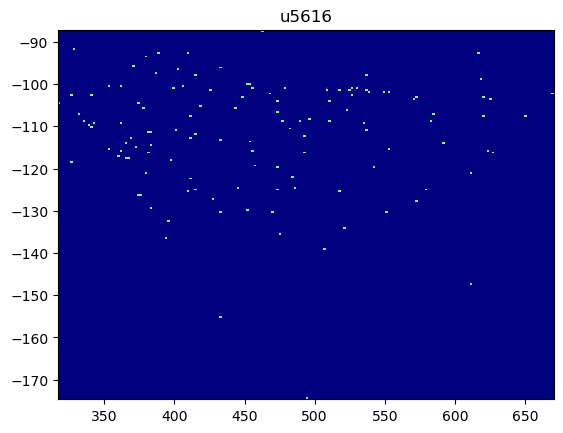

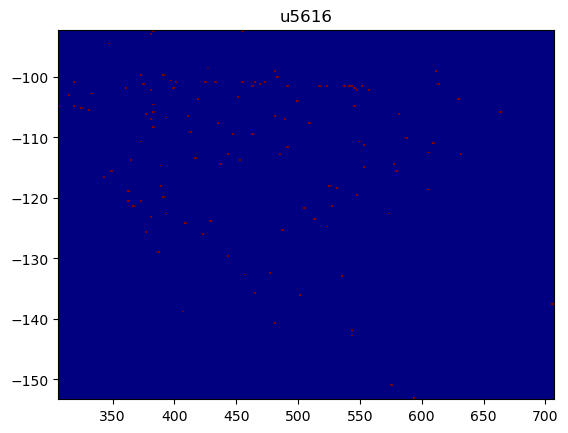

 60%|████████████████████████████████████████████████▌                                | 60/100 [01:31<01:00,  1.52s/it]

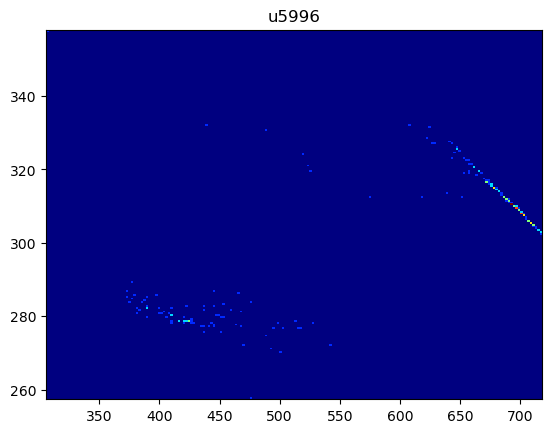

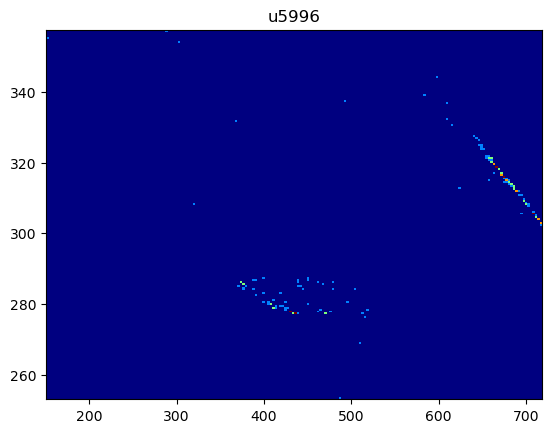

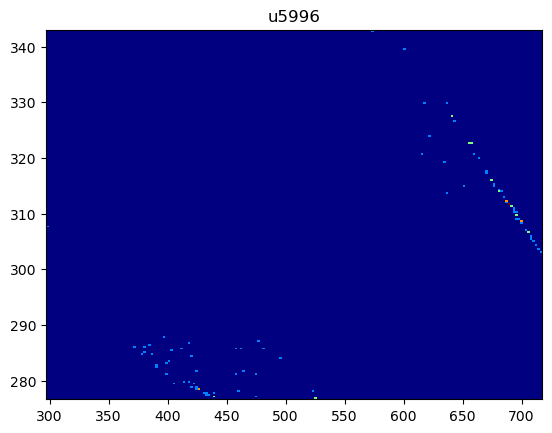

 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:32<00:59,  1.51s/it]

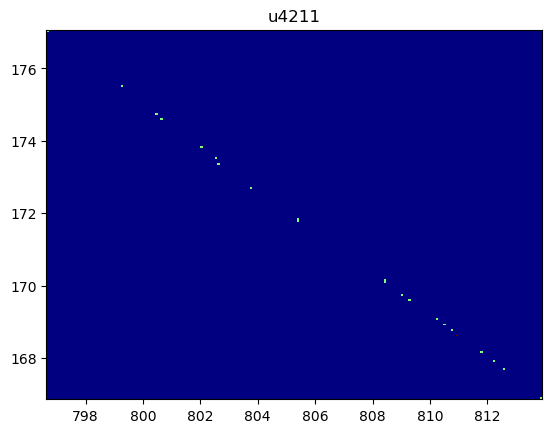

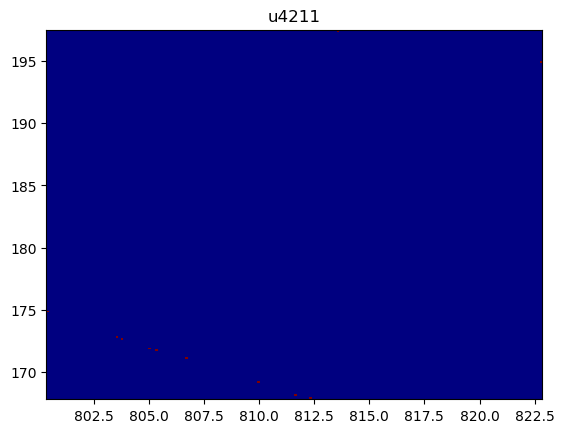

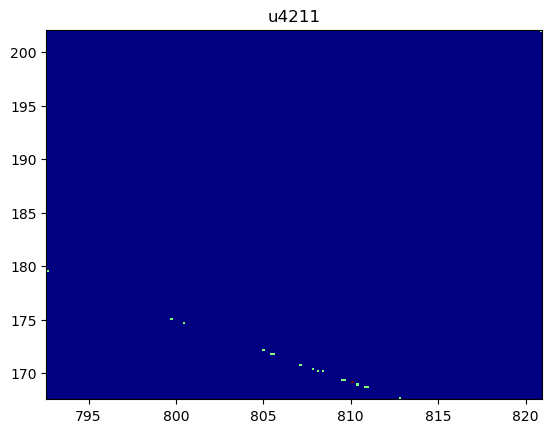

 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:34<00:57,  1.51s/it]

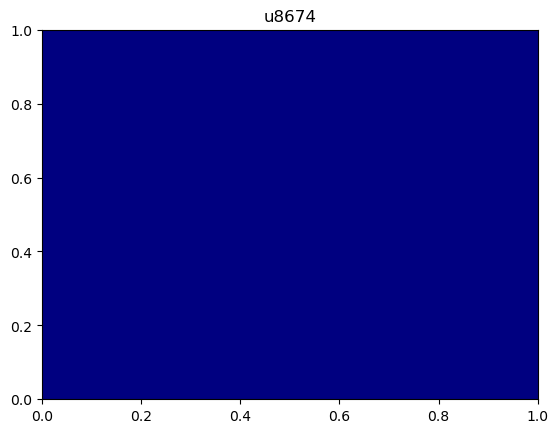

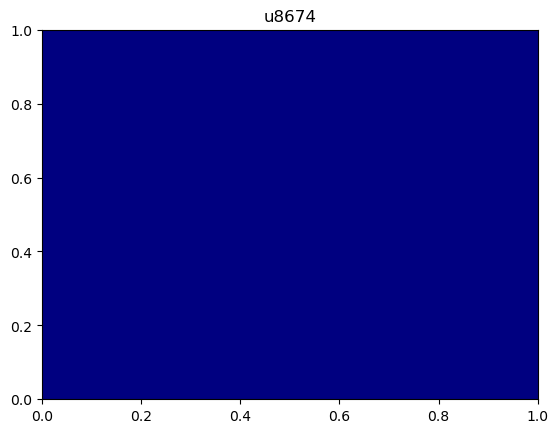

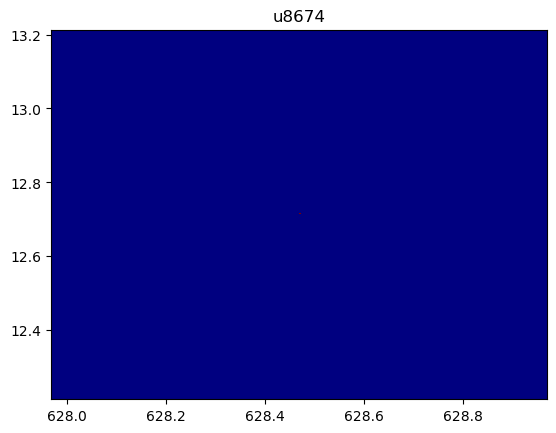

 63%|███████████████████████████████████████████████████                              | 63/100 [01:36<00:57,  1.56s/it]

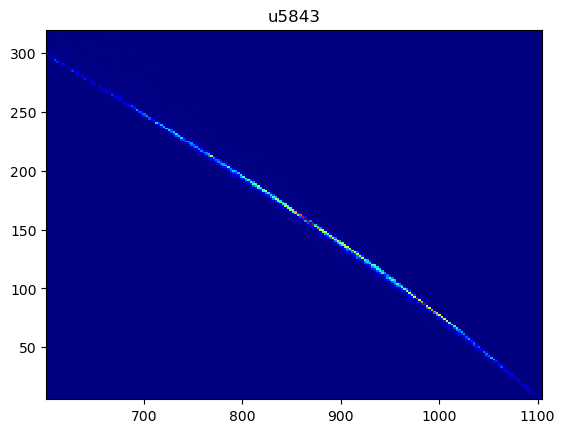

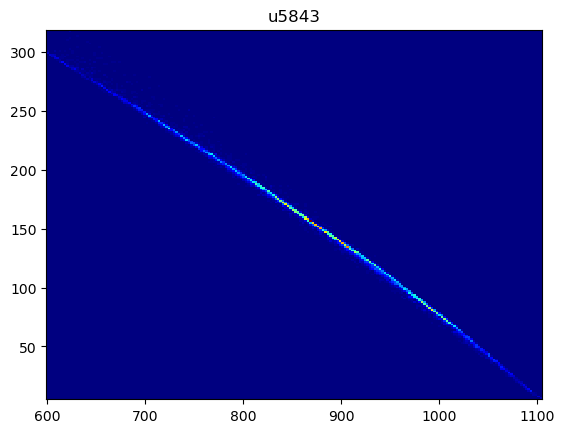

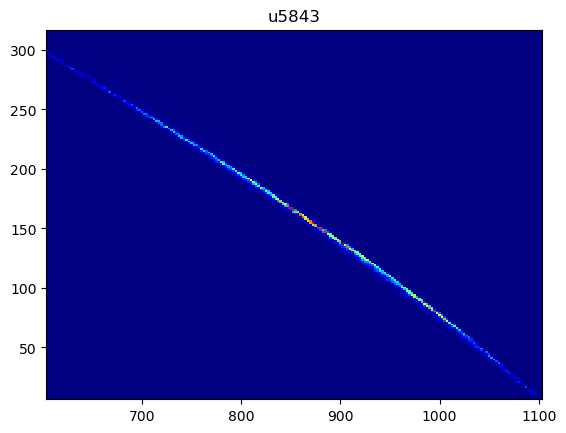

 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:37<00:56,  1.56s/it]

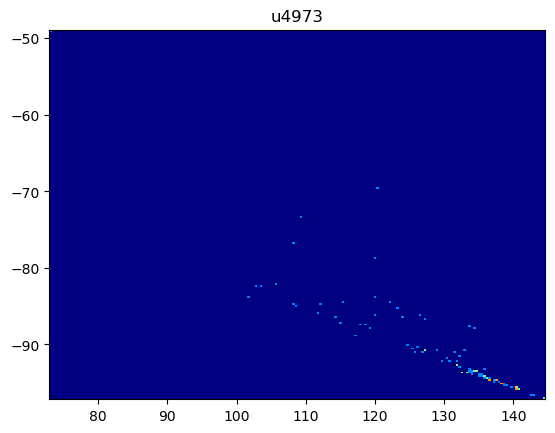

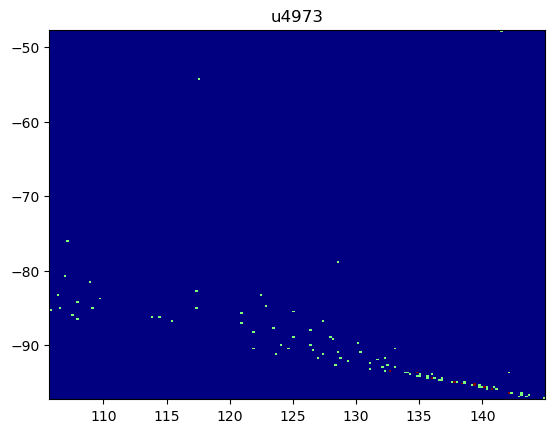

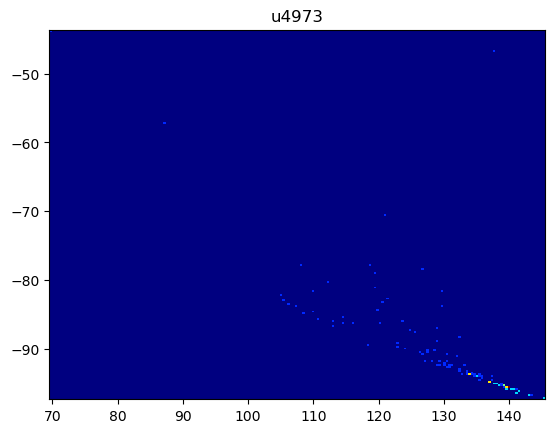

 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:38<00:51,  1.48s/it]

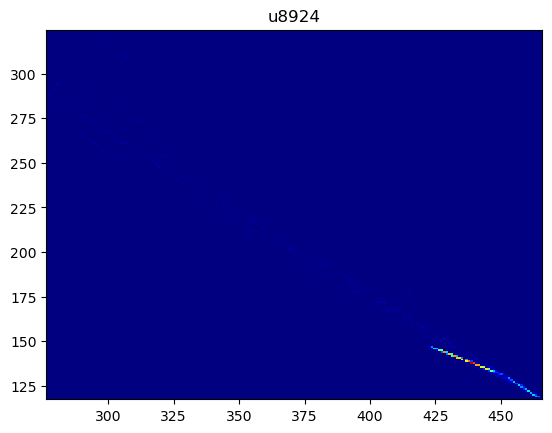

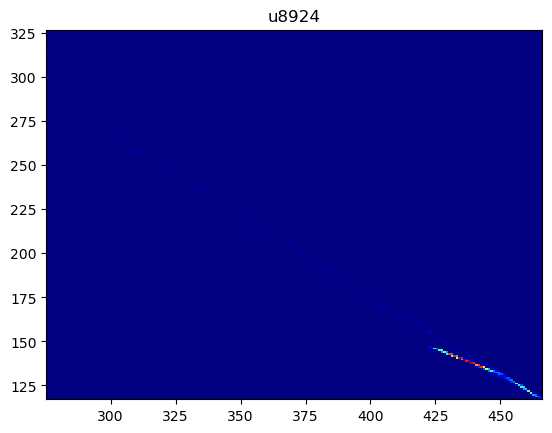

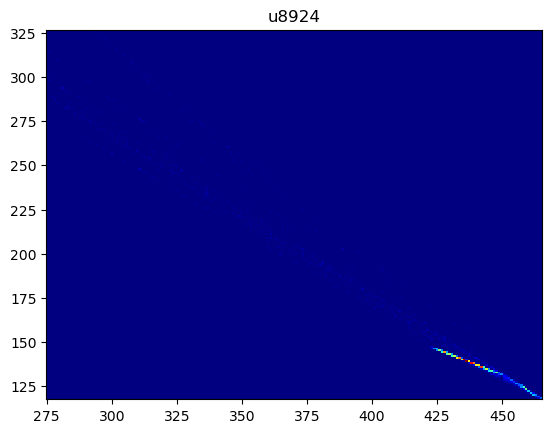

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:40<00:49,  1.47s/it]

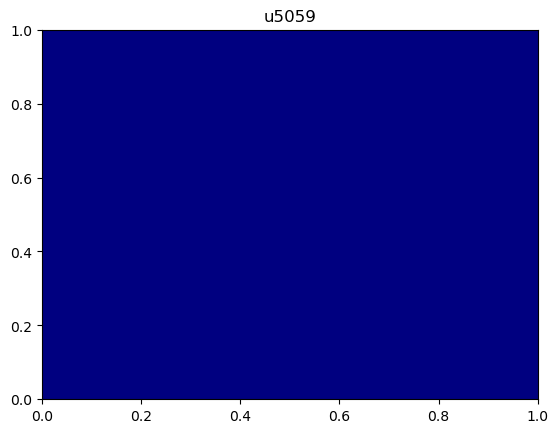

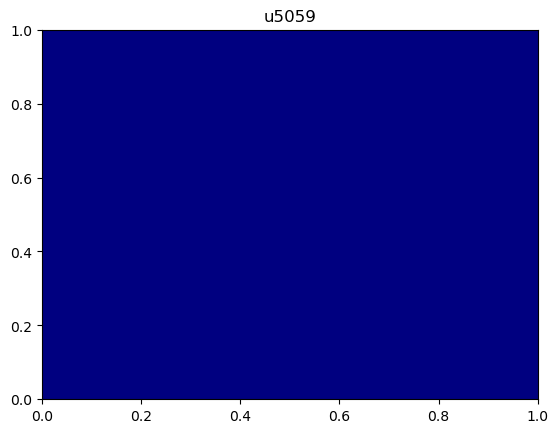

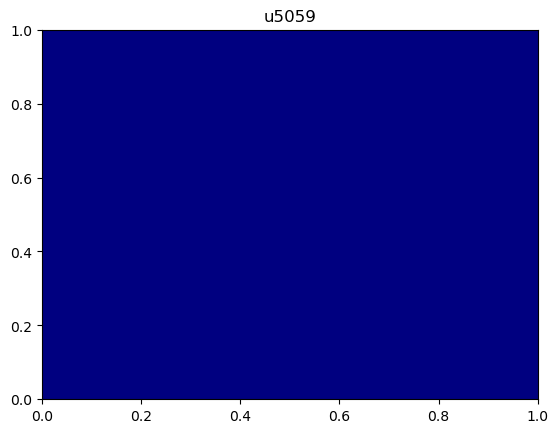

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:40<00:37,  1.13s/it]

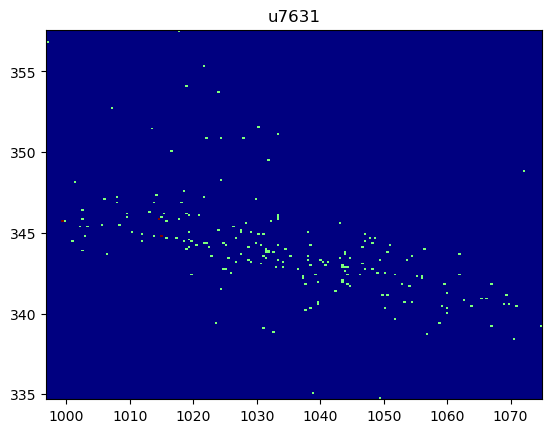

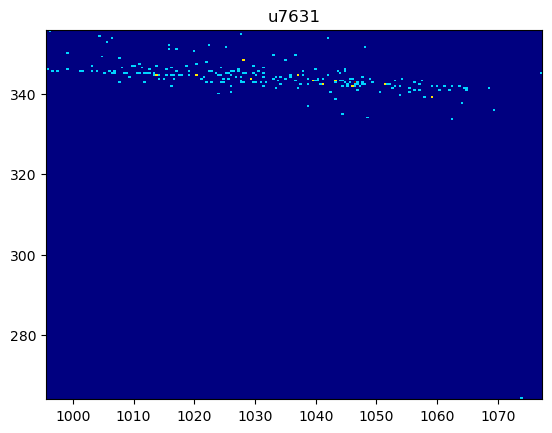

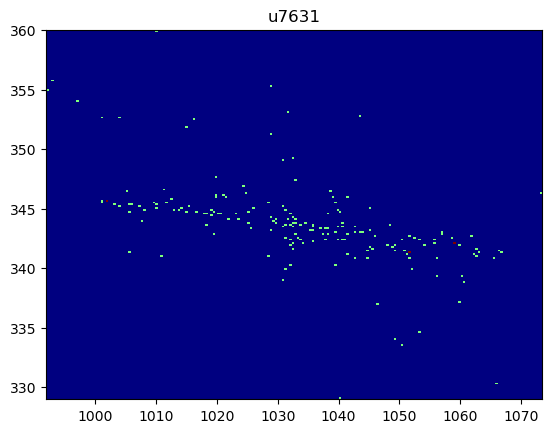

 68%|███████████████████████████████████████████████████████                          | 68/100 [01:42<00:39,  1.25s/it]

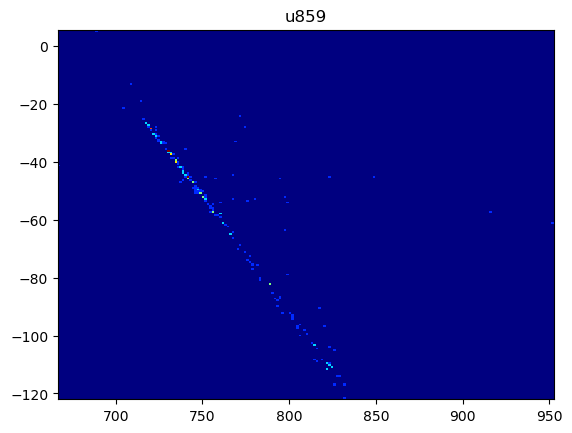

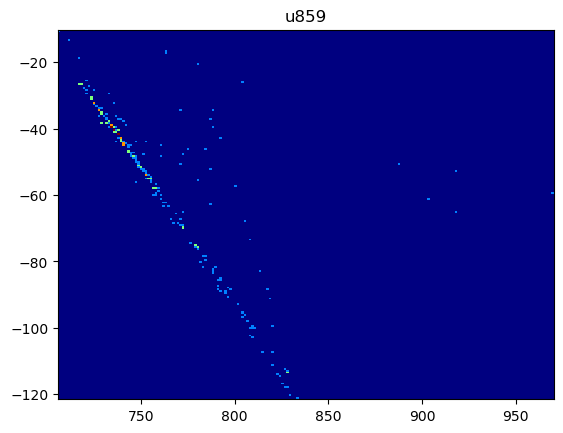

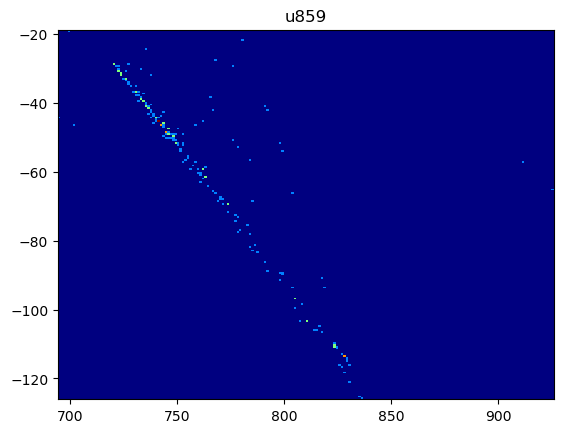

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:43<00:39,  1.28s/it]

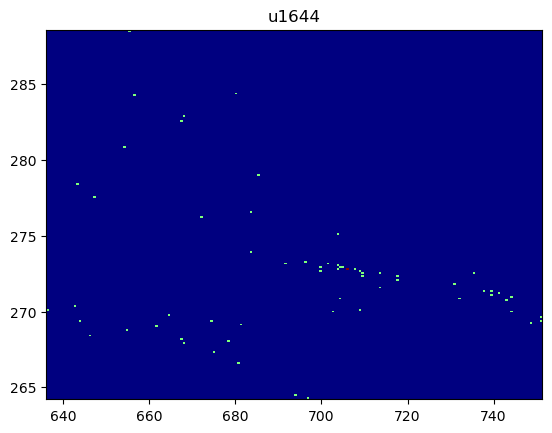

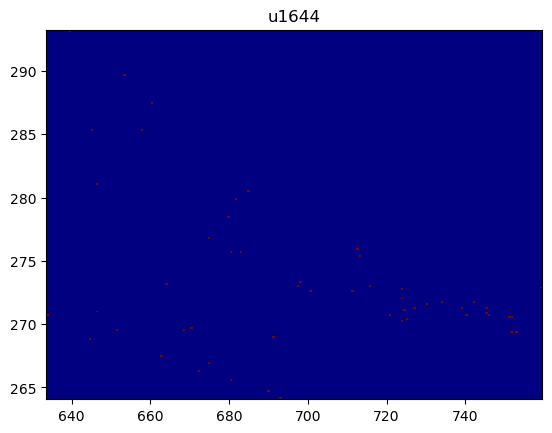

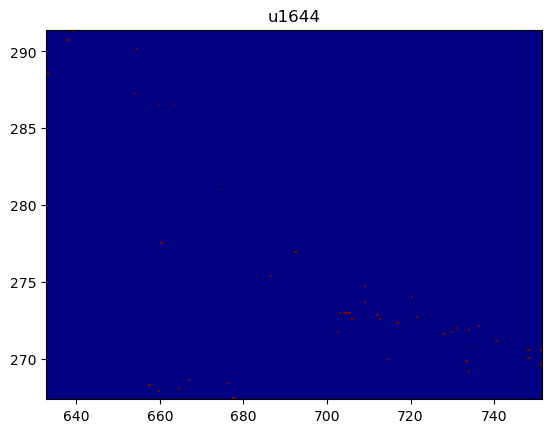

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:45<00:39,  1.31s/it]

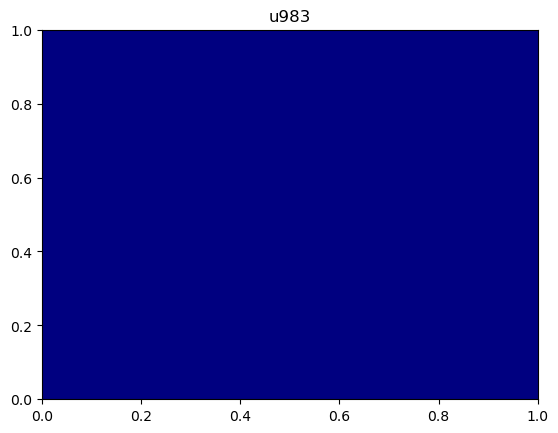

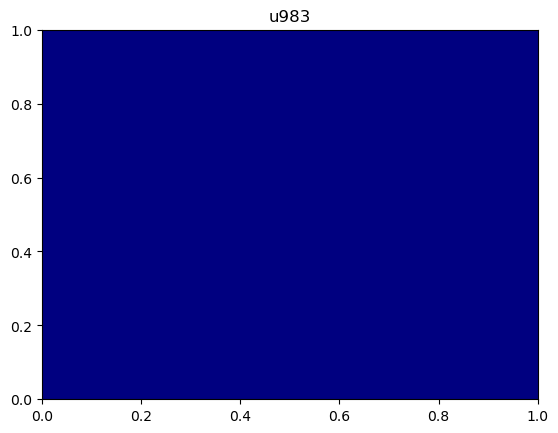

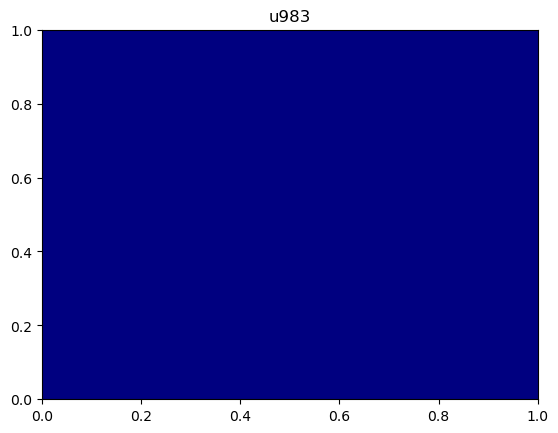

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:46<00:38,  1.32s/it]

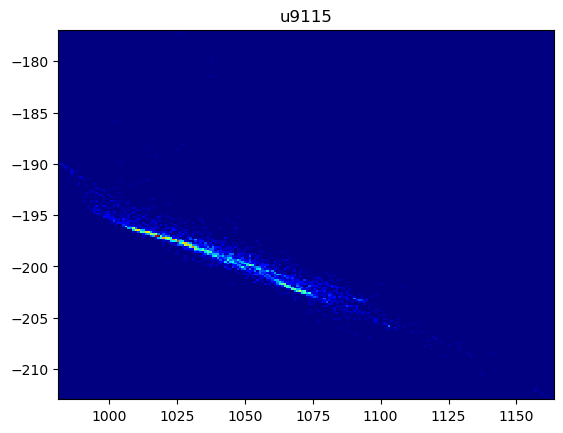

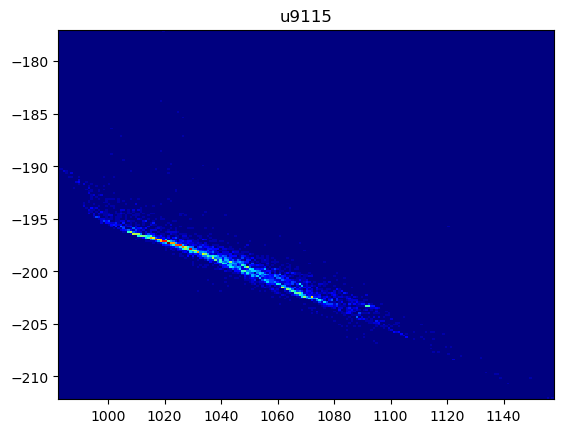

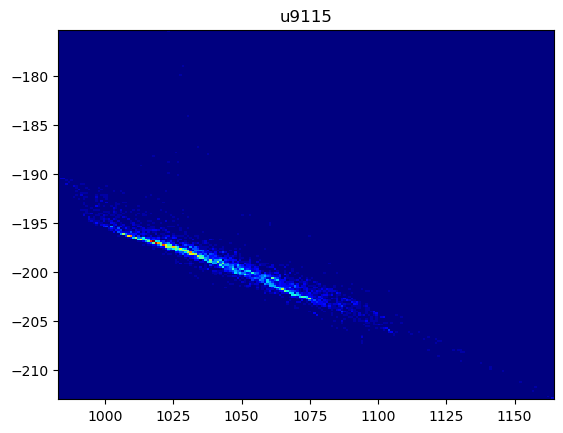

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:47<00:37,  1.35s/it]

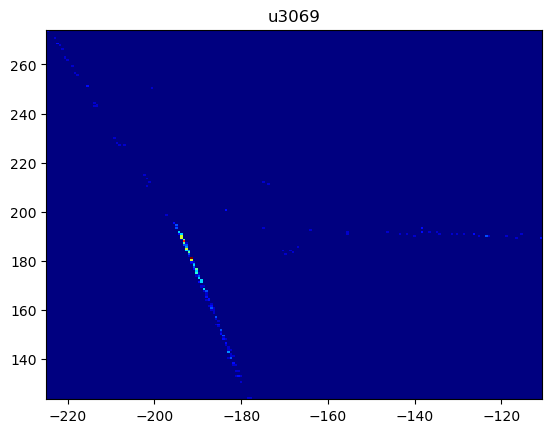

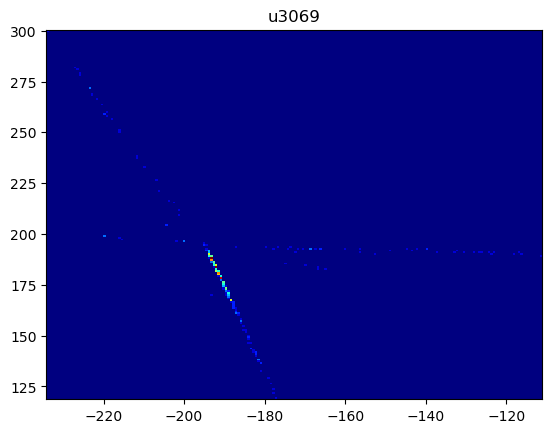

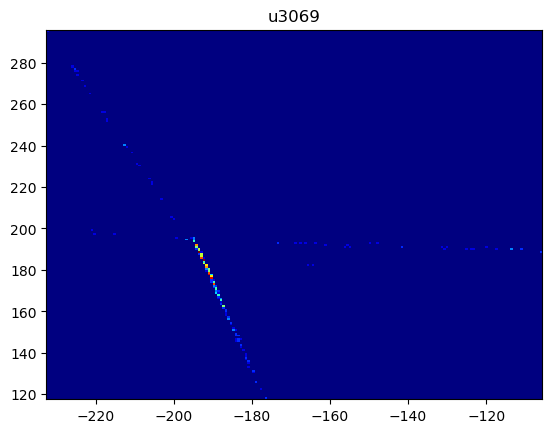

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:49<00:36,  1.35s/it]

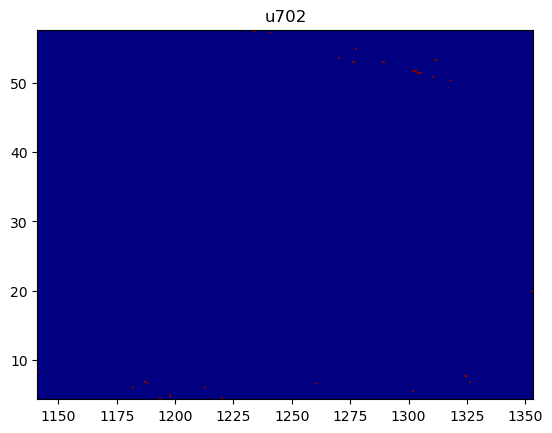

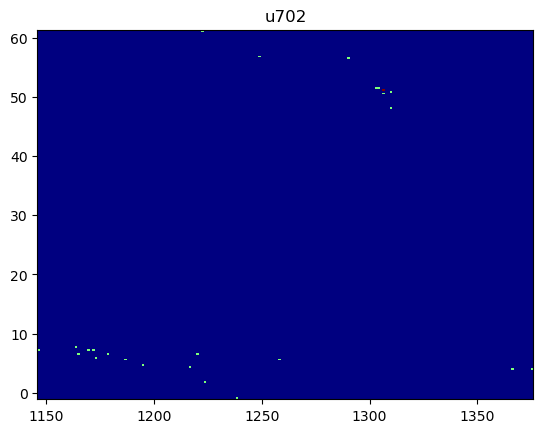

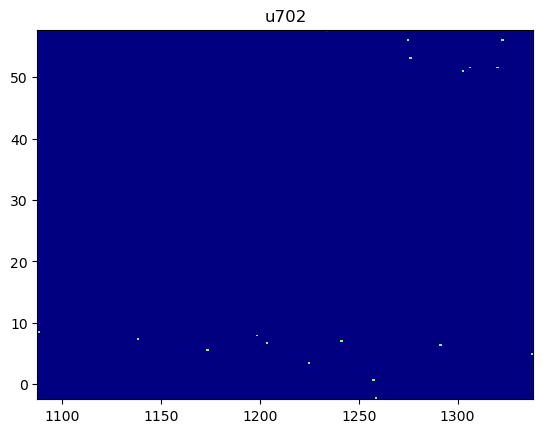

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:50<00:34,  1.34s/it]

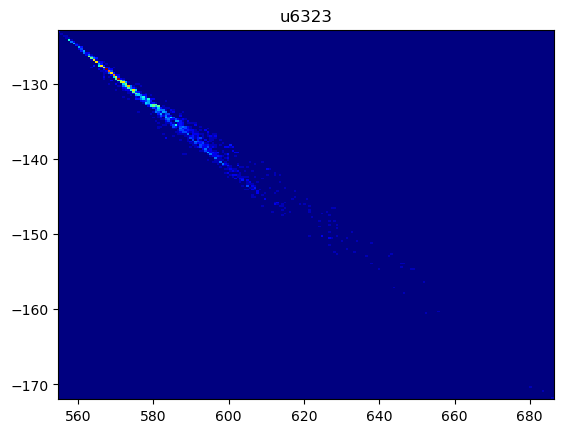

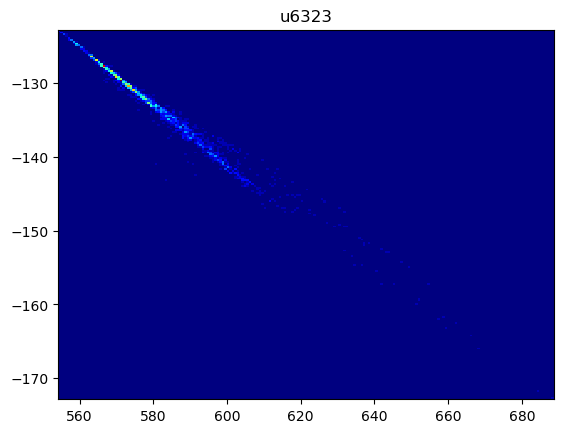

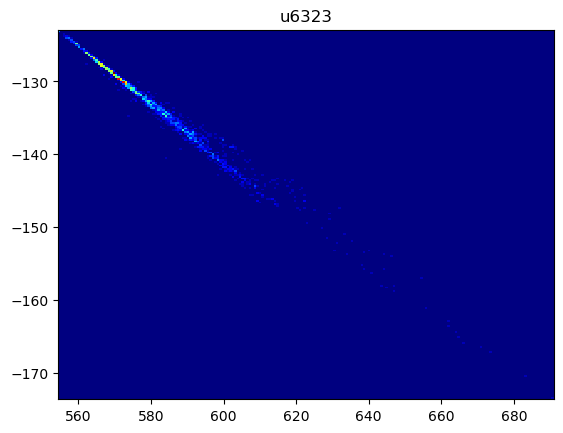

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:51<00:33,  1.35s/it]

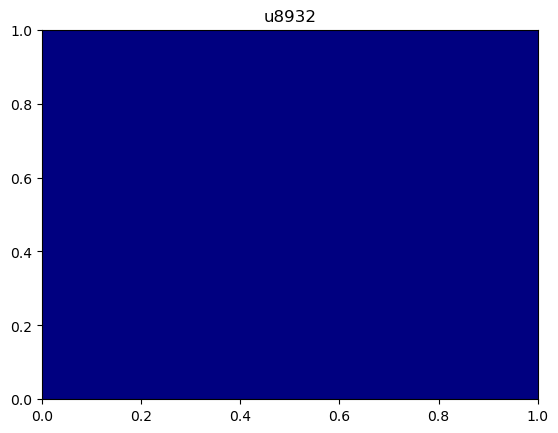

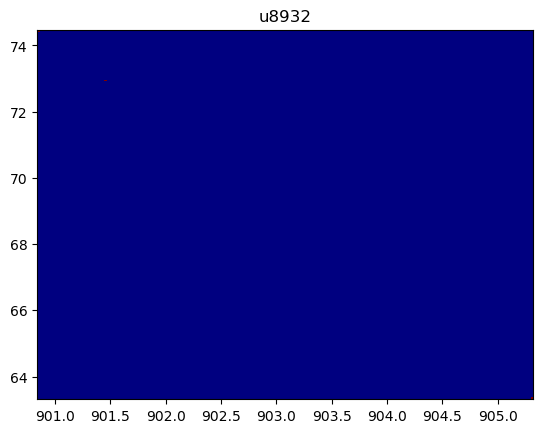

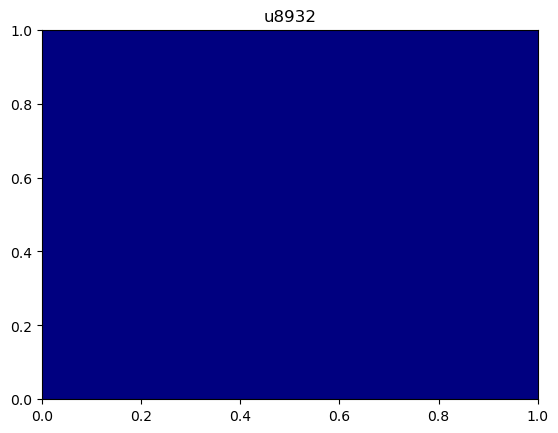

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:53<00:32,  1.36s/it]

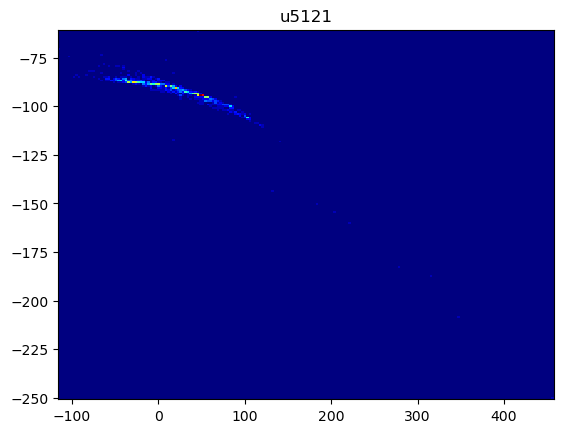

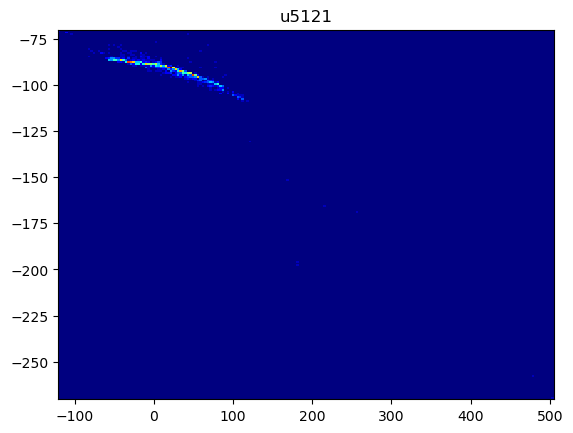

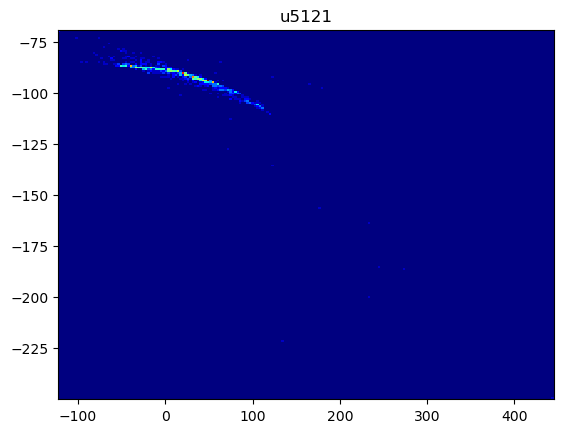

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:54<00:31,  1.38s/it]

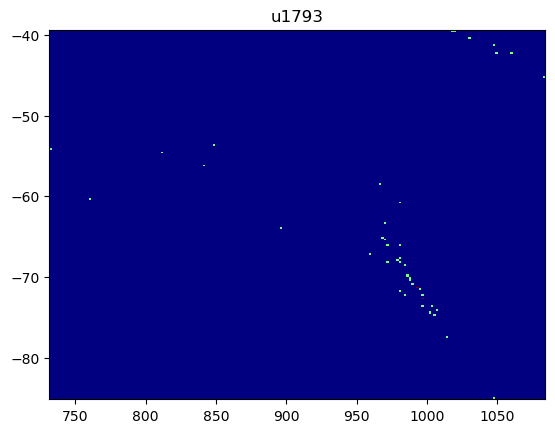

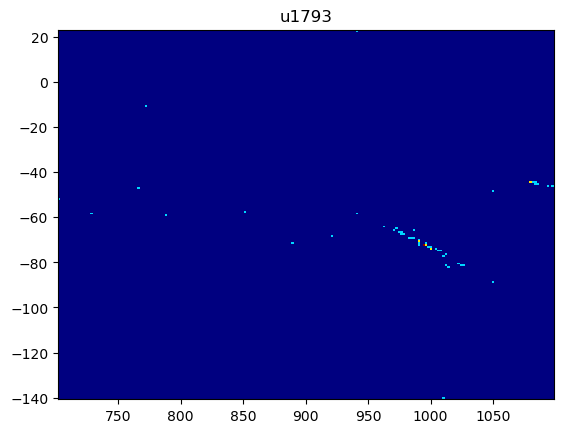

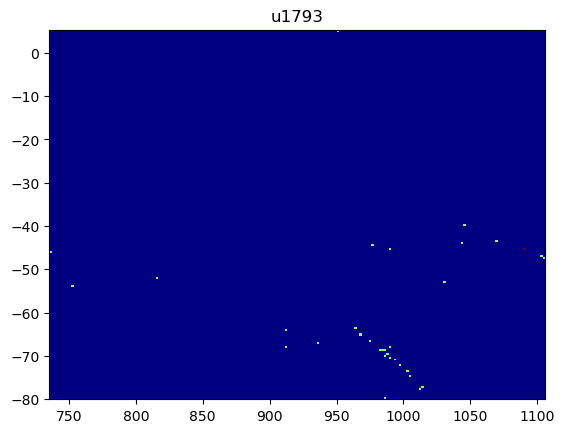

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:56<00:31,  1.45s/it]

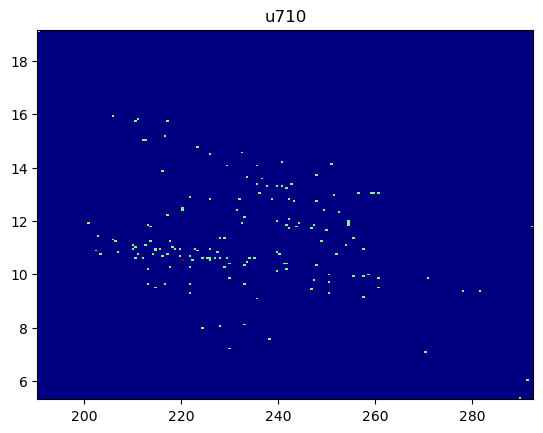

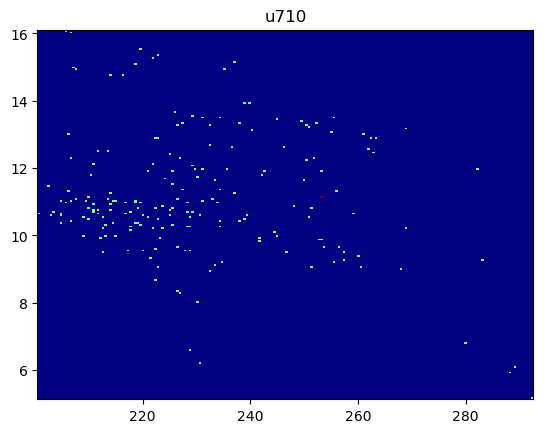

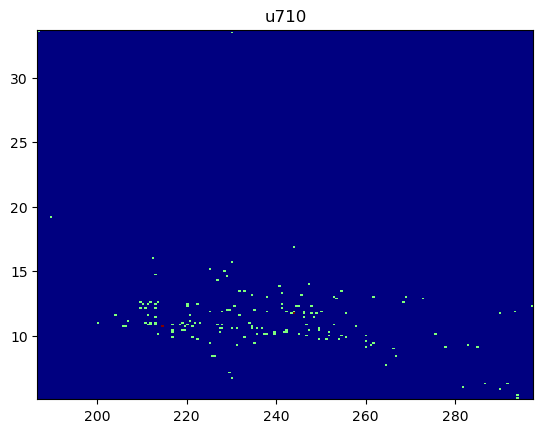

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:57<00:29,  1.43s/it]

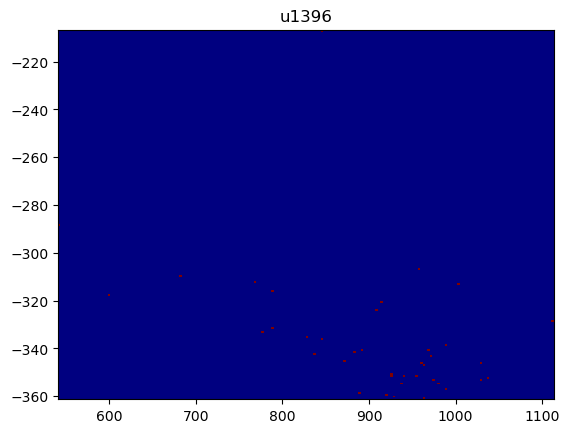

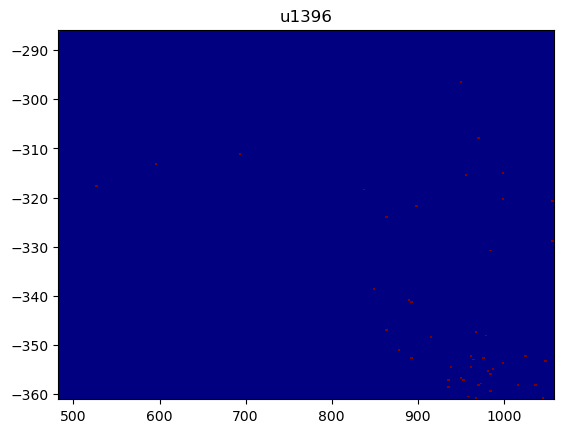

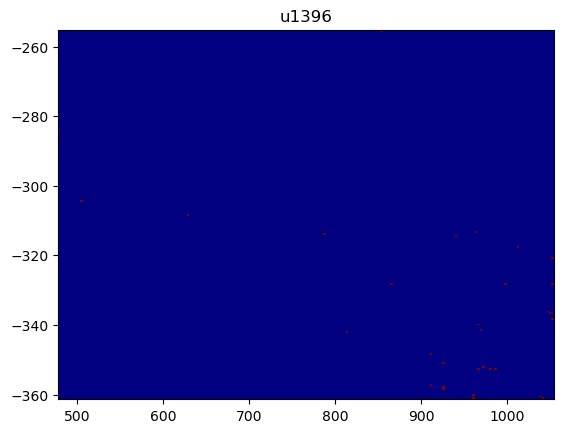

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:59<00:29,  1.48s/it]

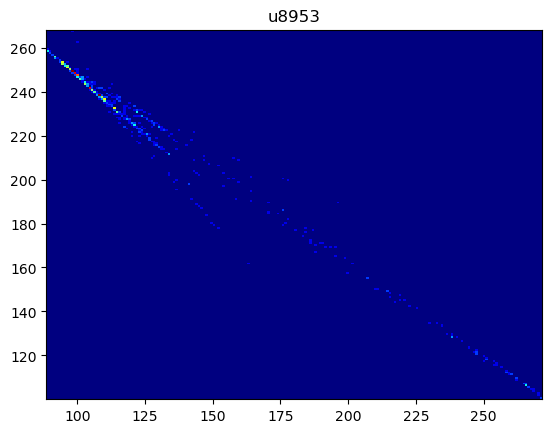

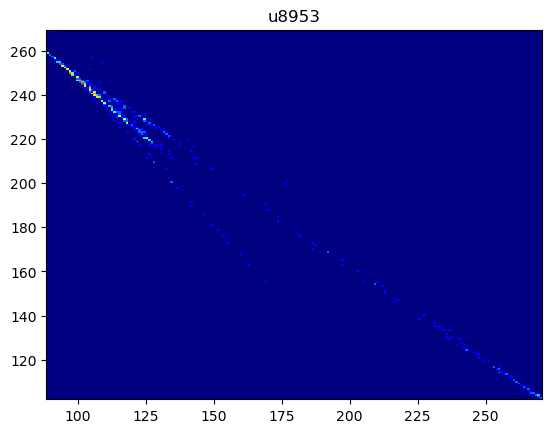

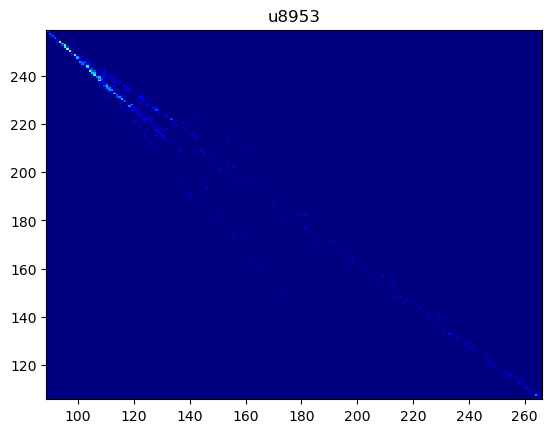

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:00<00:28,  1.50s/it]

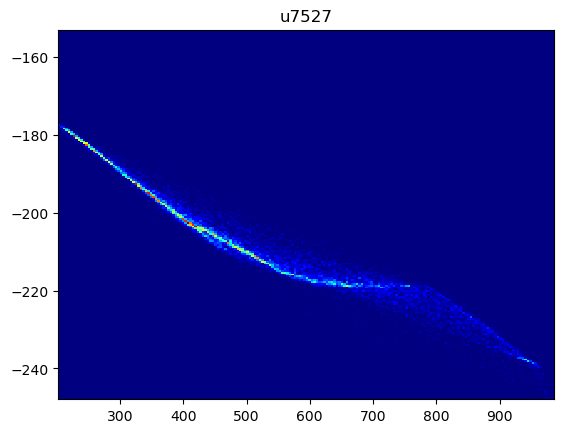

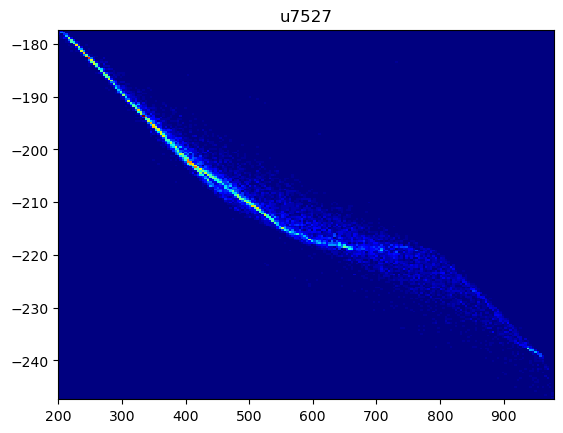

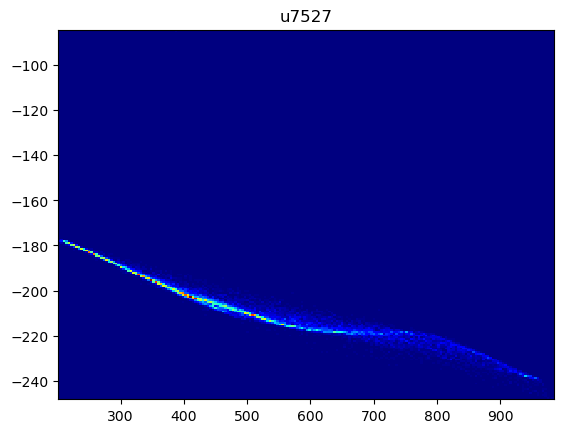

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [02:02<00:27,  1.54s/it]

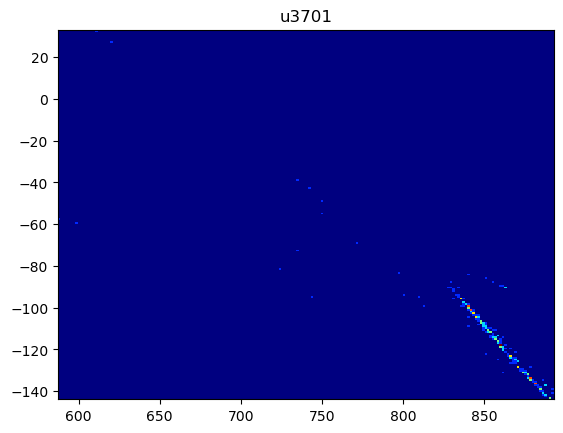

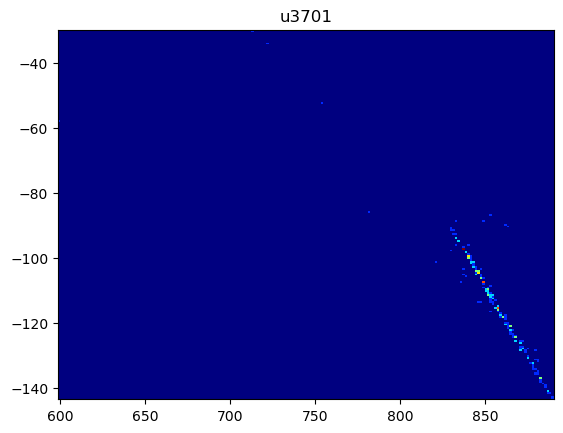

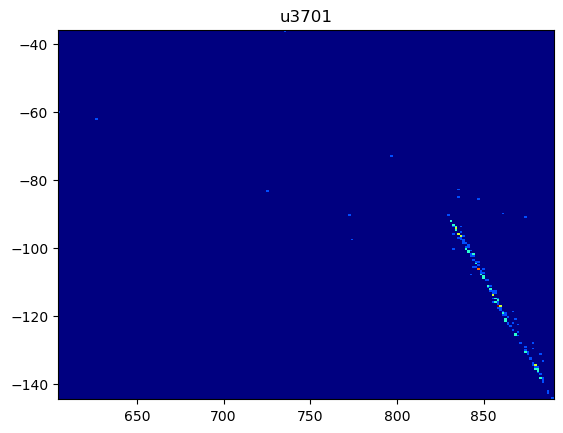

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [02:03<00:26,  1.55s/it]

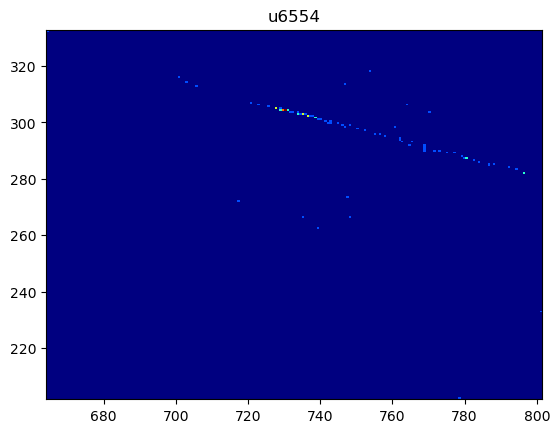

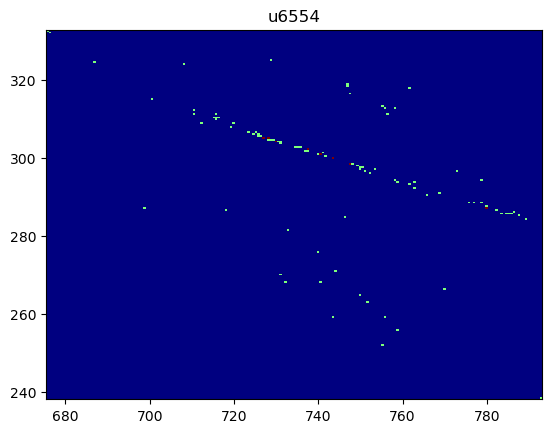

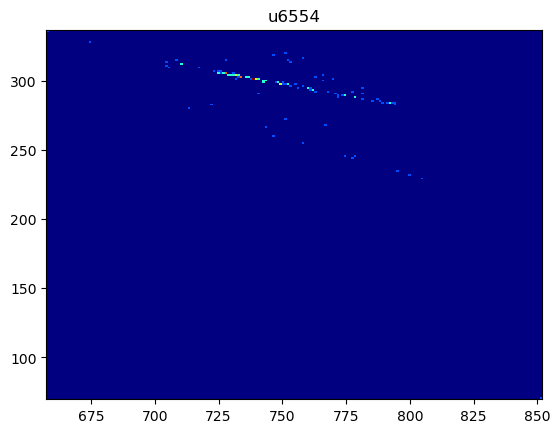

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:05<00:24,  1.52s/it]

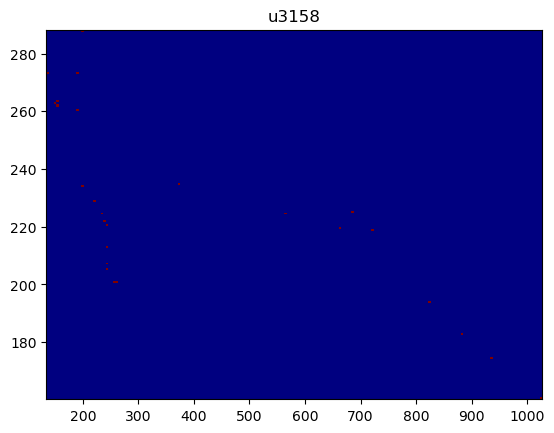

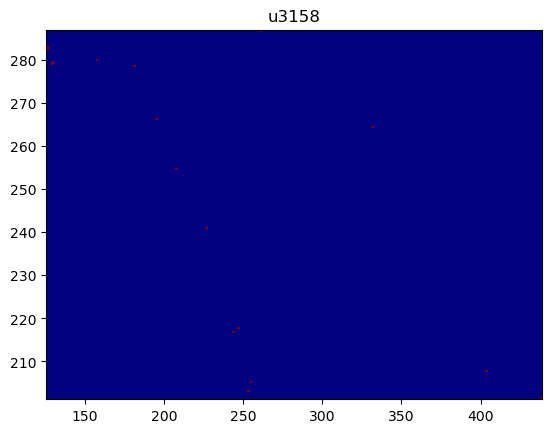

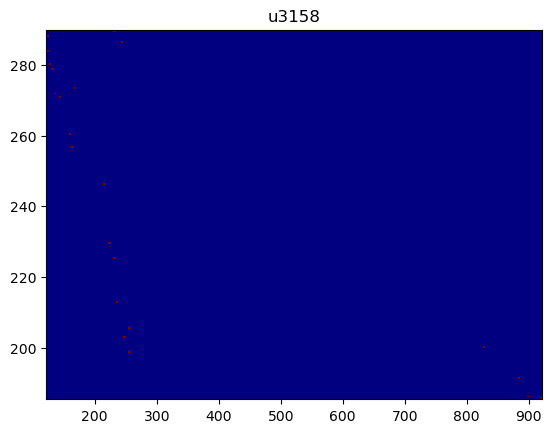

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:06<00:22,  1.51s/it]

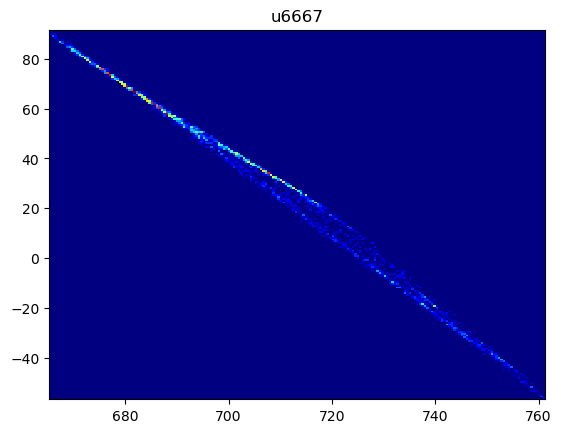

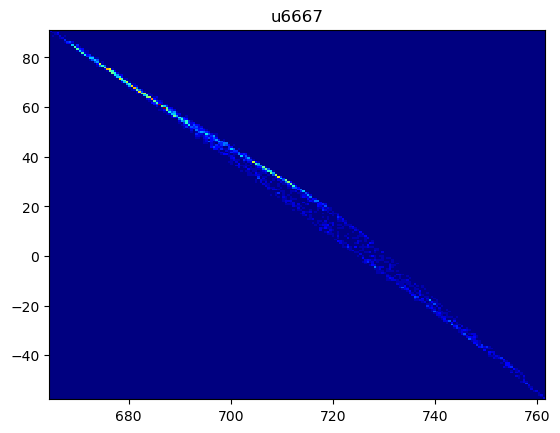

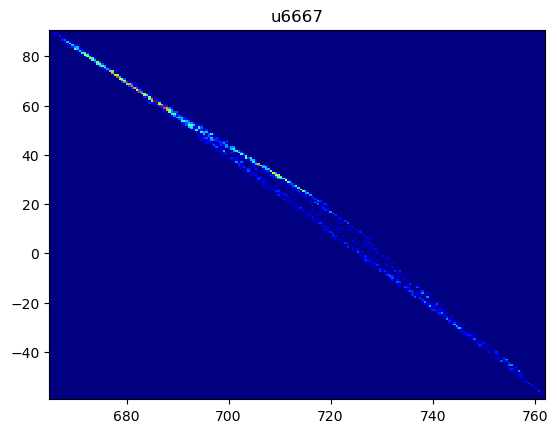

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:08<00:21,  1.51s/it]

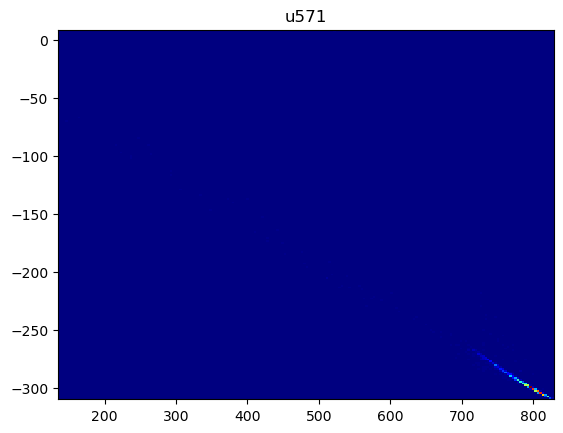

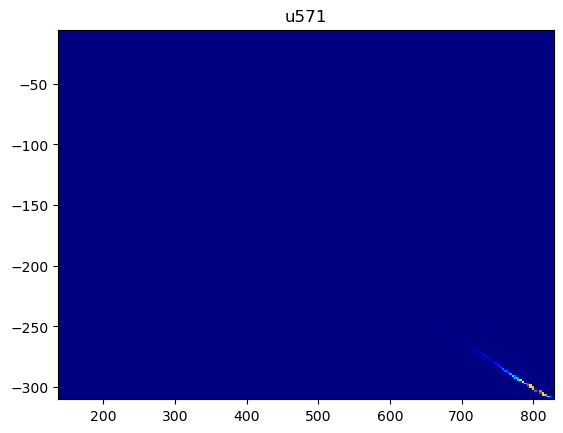

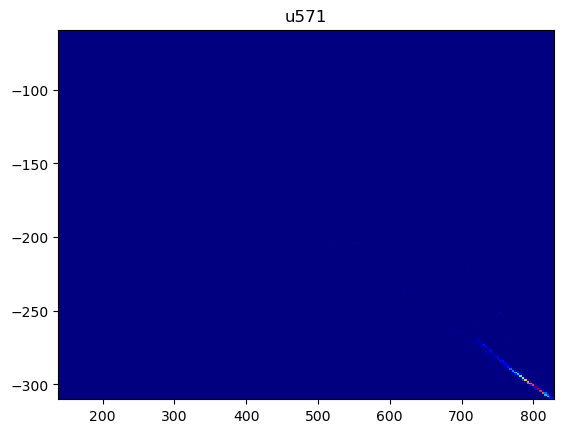

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [02:09<00:19,  1.49s/it]

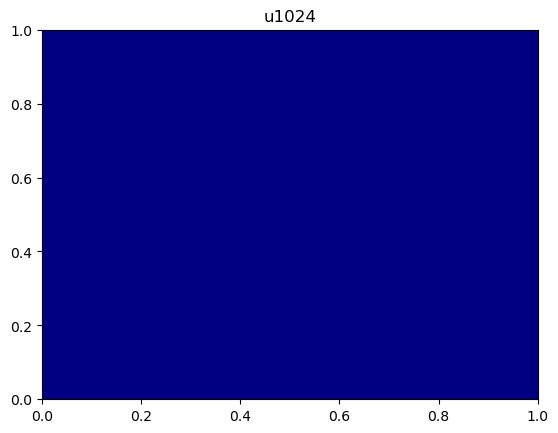

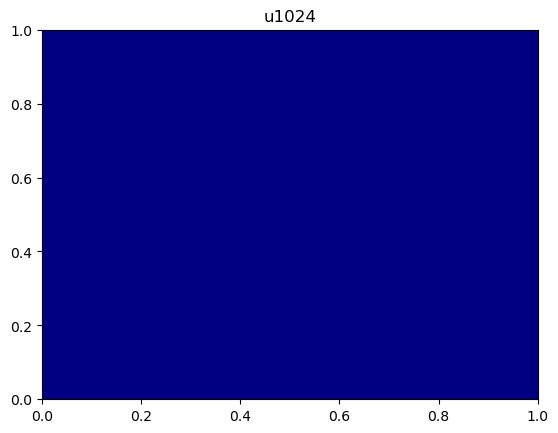

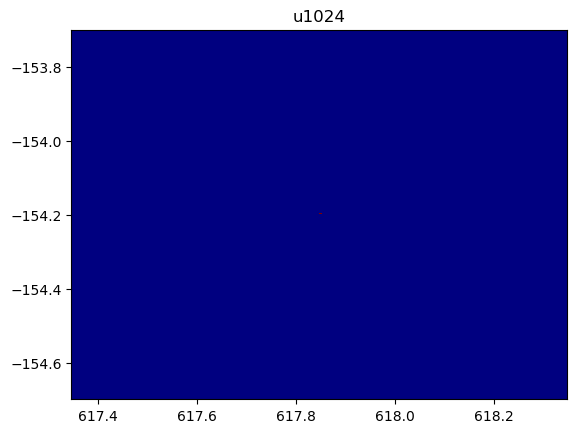

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [02:11<00:18,  1.51s/it]

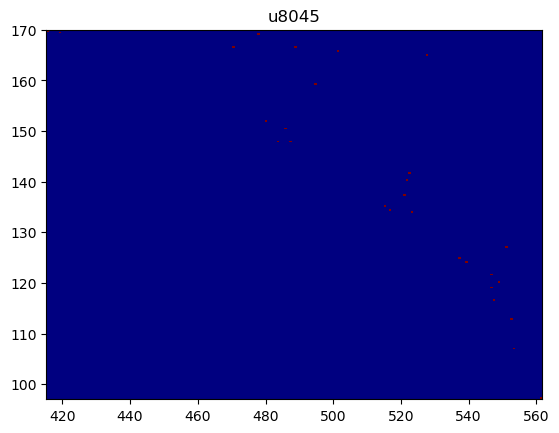

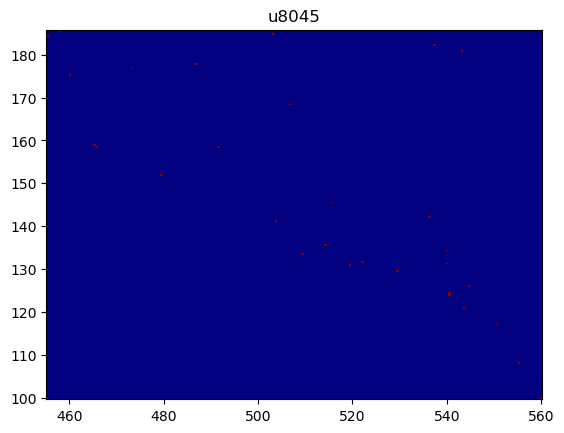

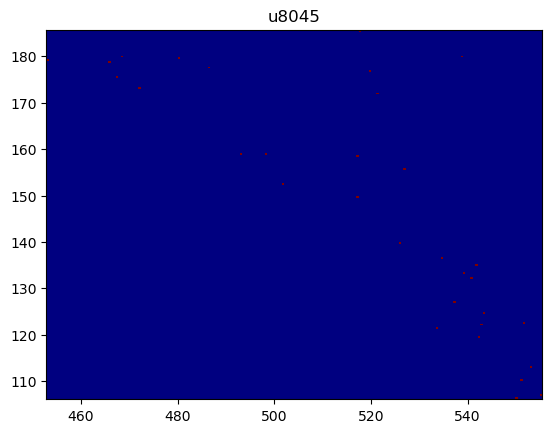

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [02:12<00:16,  1.52s/it]

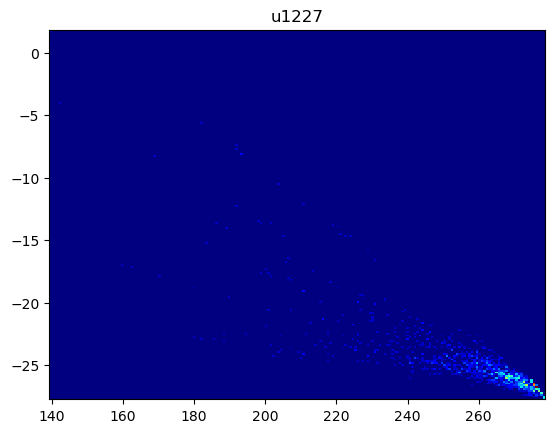

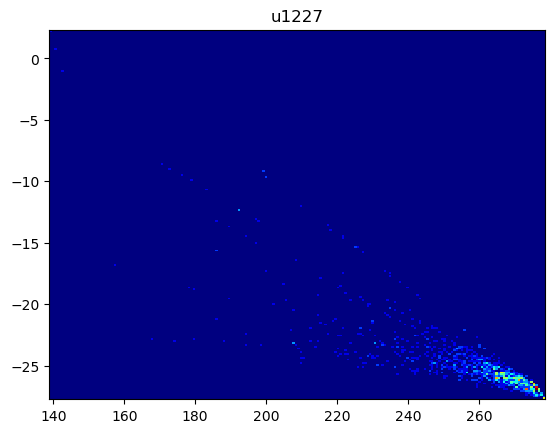

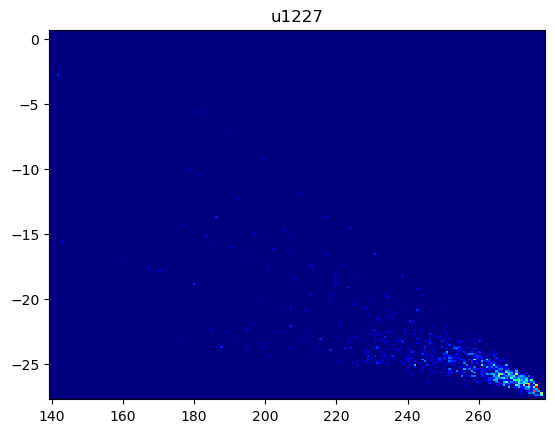

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [02:14<00:14,  1.47s/it]

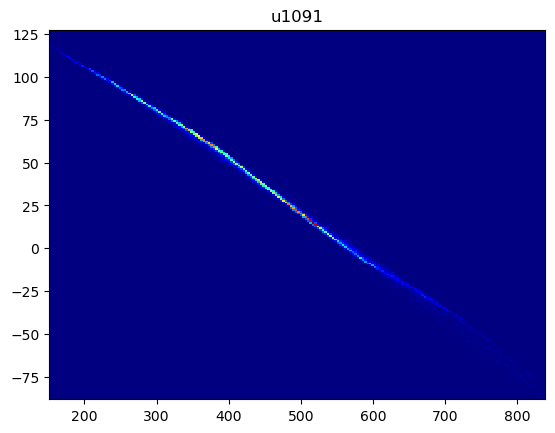

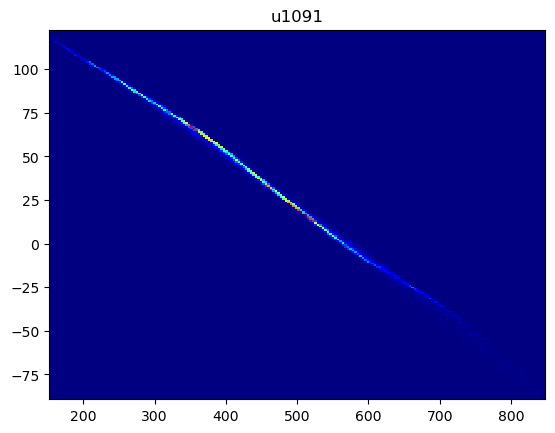

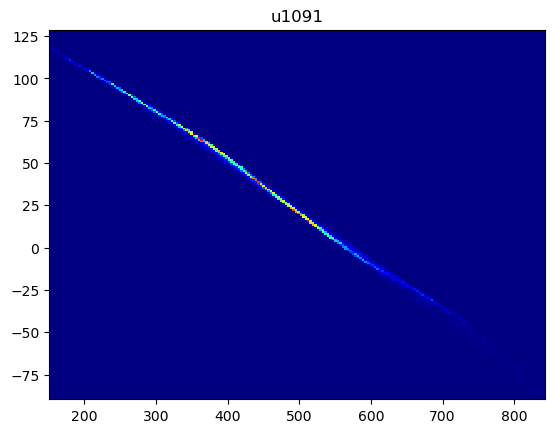

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [02:15<00:13,  1.53s/it]

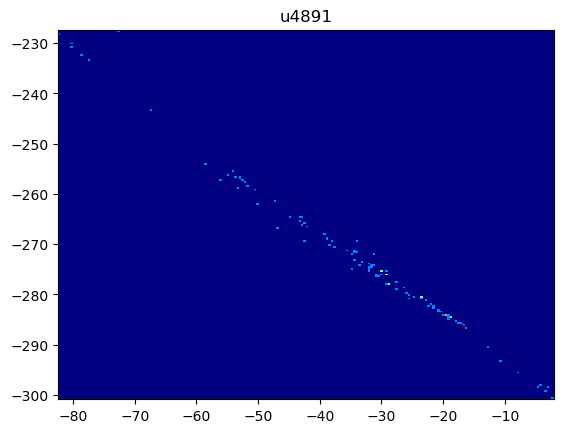

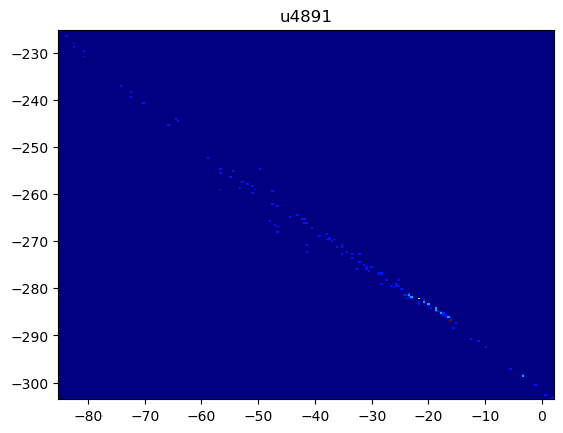

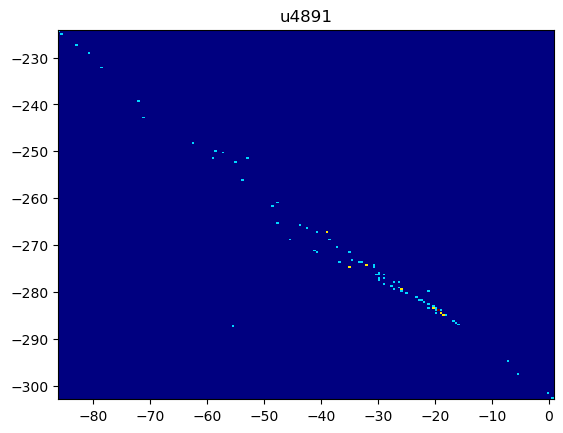

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [02:17<00:12,  1.55s/it]

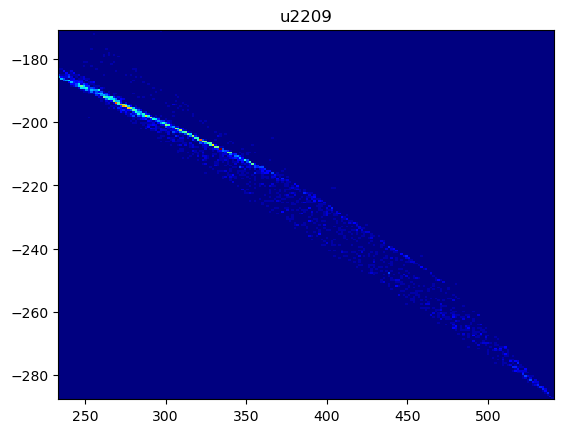

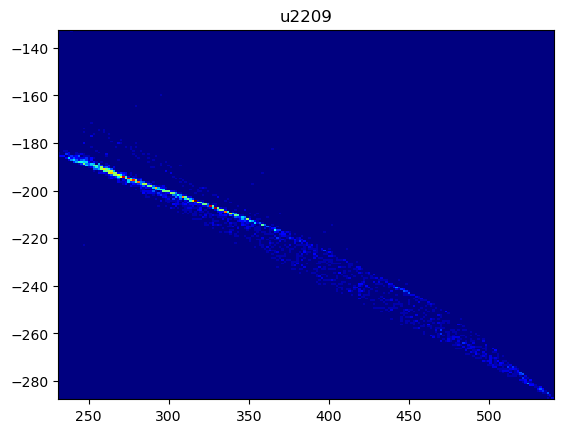

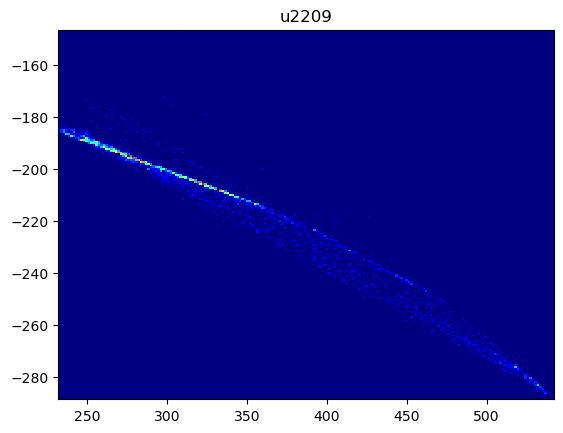

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:19<00:10,  1.55s/it]

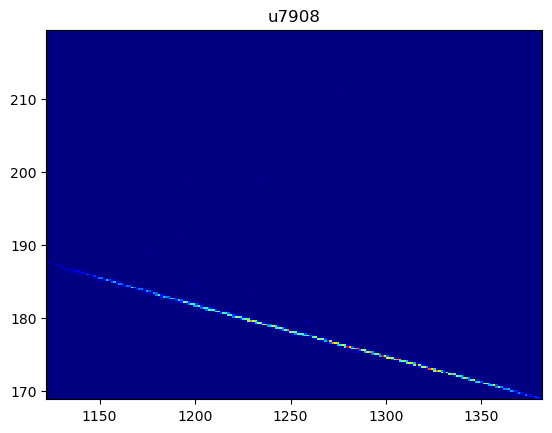

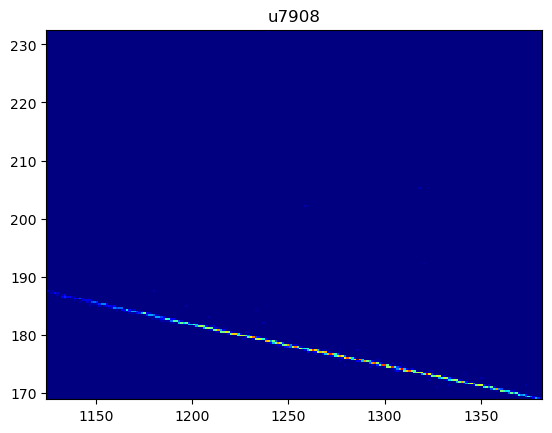

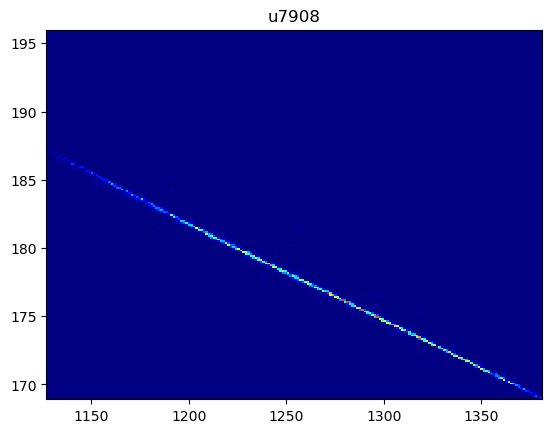

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [02:20<00:09,  1.51s/it]

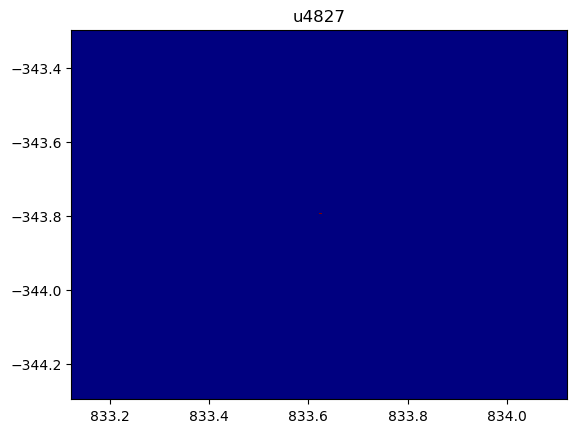

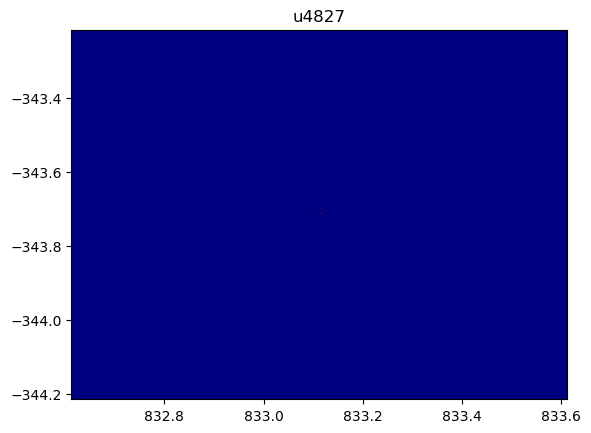

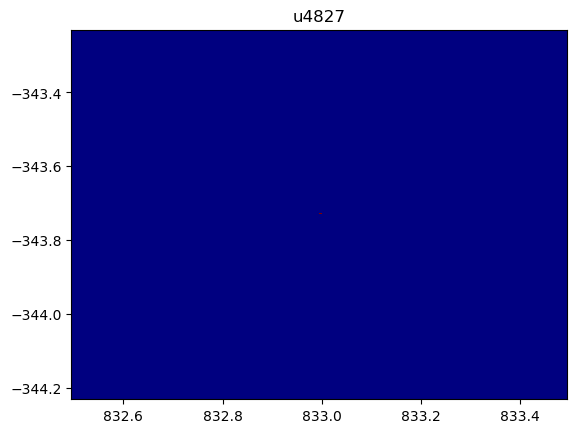

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:22<00:07,  1.50s/it]

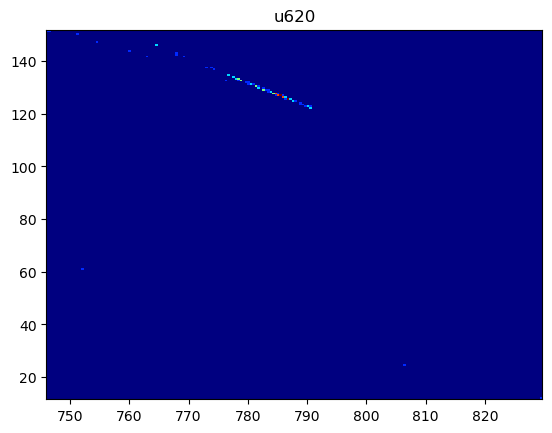

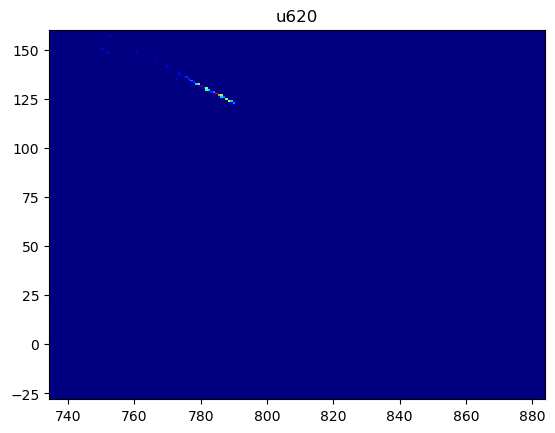

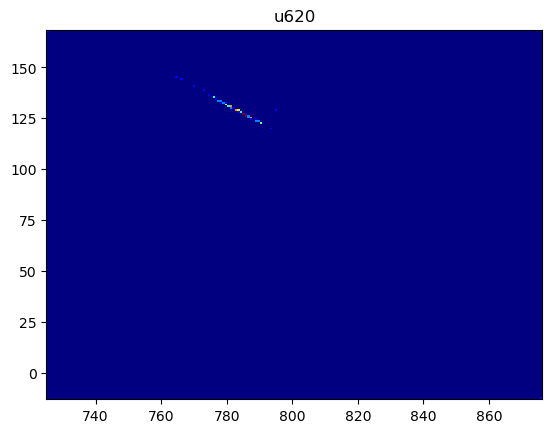

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [02:23<00:05,  1.50s/it]

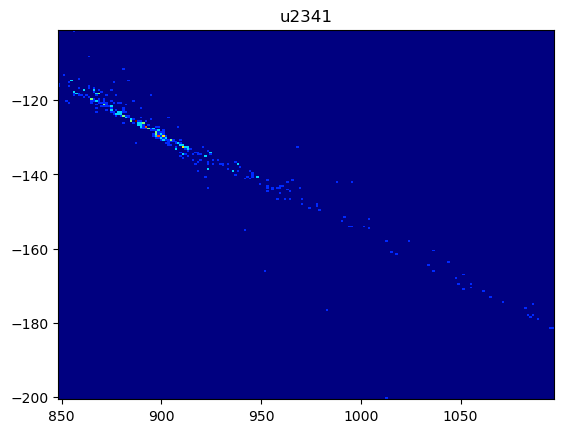

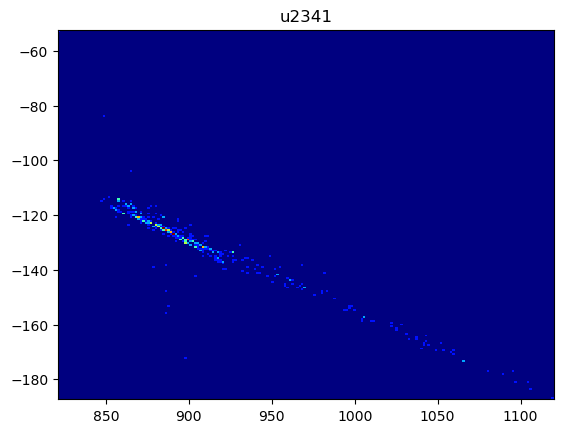

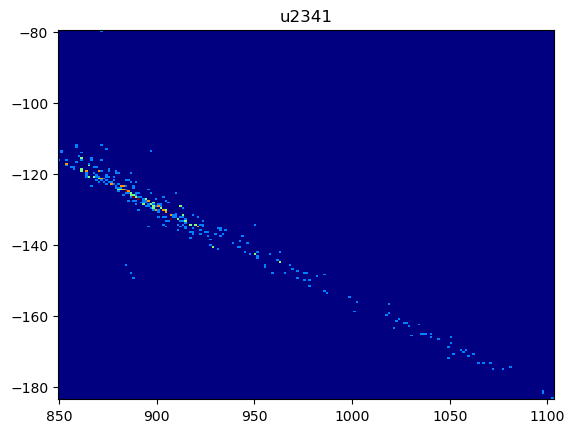

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:25<00:04,  1.53s/it]

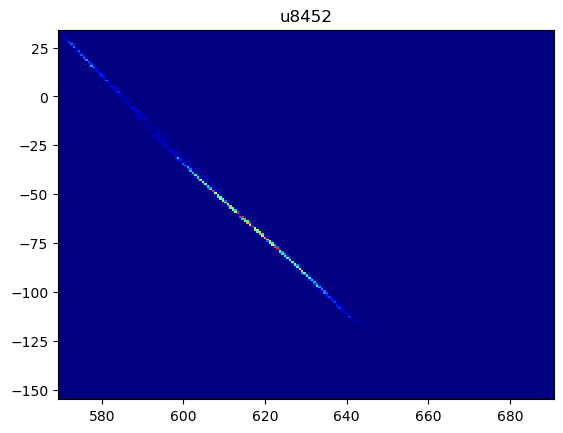

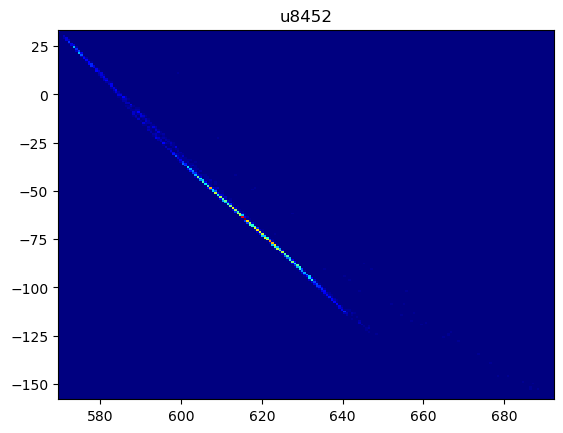

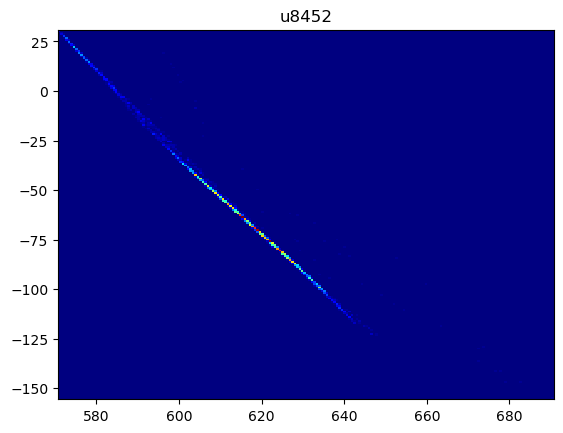

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [02:26<00:03,  1.52s/it]

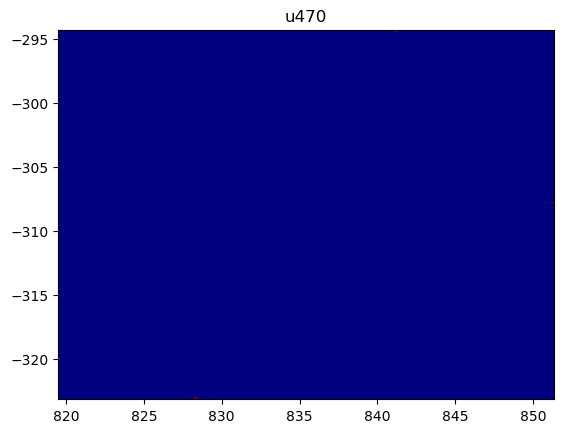

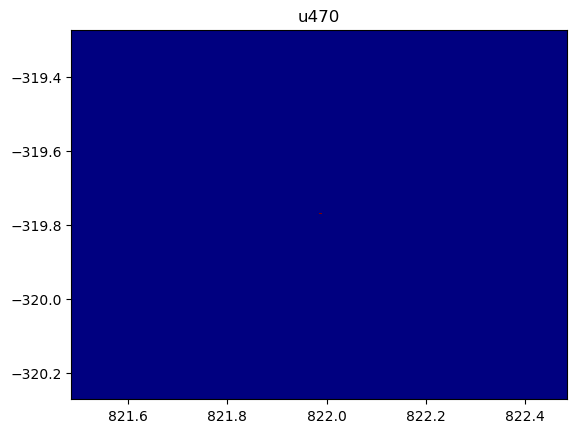

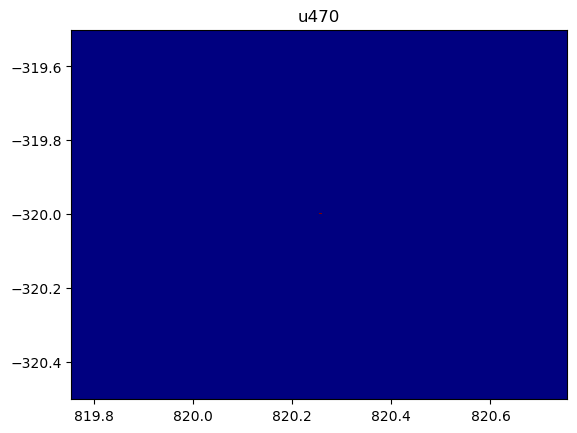

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:28<00:01,  1.50s/it]

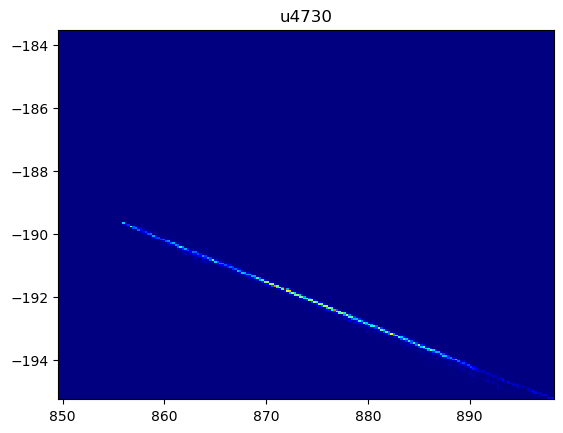

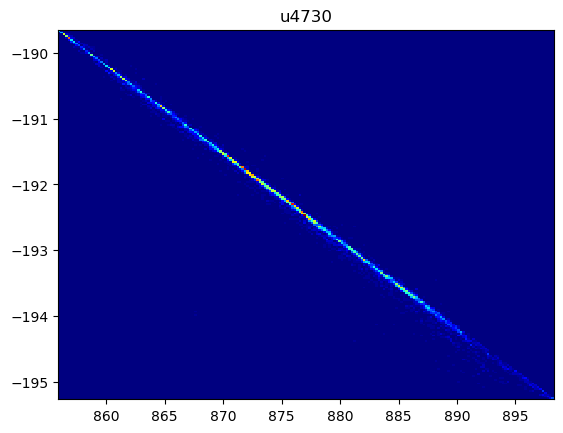

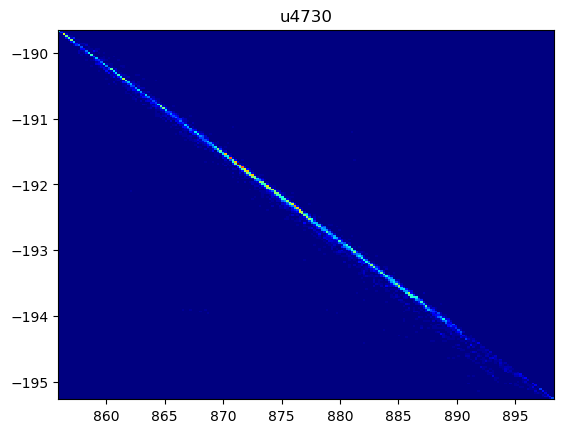

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


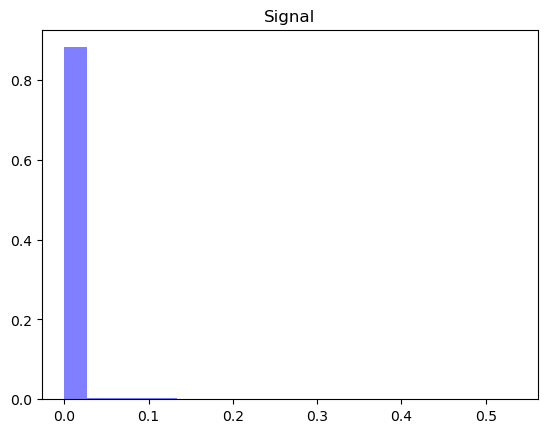

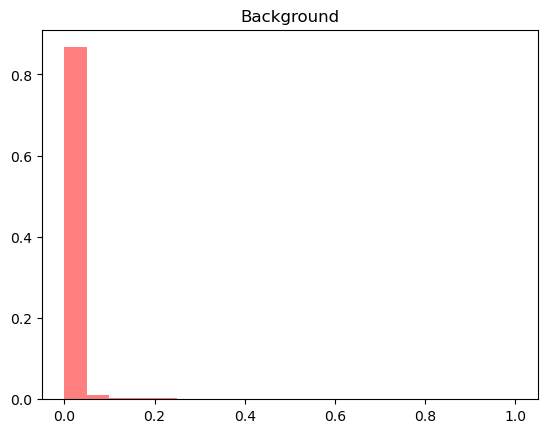

In [53]:
sample = random.sample(range(0, len(u_x)), 100)

signal, back, x, y = findfourpointpdf("u", sample, plot=True)

In [54]:
import pandas as pd
pd.DataFrame(signal).to_csv("signal_4point_raw.csv")
pd.DataFrame(back).to_csv("back_4point_raw.csv")
pd.DataFrame(x).to_csv("signal_4point_hist.csv")
pd.DataFrame(y).to_csv("back_4point_hist.csv")

In [76]:
'''
def check_valid_intersection(point1, point2, point3, point4, range_x, range_z):
    slope1, intercept1 = line_finder(point1, point2)
    slope2, intercept2 = line_finder(point3, point4)
    x_point, y_point = line_intersect(slope1, intercept1, slope2, intercept2)
    x_vertices = [point1[0], point2[0], point3[0], point4[0]]
    z_vertices = [point1[1], point2[1], point3[1], point4[1]]
    x_max, x_min = max(x_vertices), min(x_vertices)
    z_max, z_min = max(z_vertices), min(z_vertices)
    angle1, angle2 = np.arctan(slope1), np.arctan(slope2)
    if x_point > x_min and x_point < x_max:
        if y_point > z_min and y_point < z_max:
            if x_point > (range_x[0] - 100) and x_point < range_x[1]:
                if y_point > (range_z[0] - 100) and y_point < range_z[1]:
                    if angle1 < 0.95*angle2 and angle1 > 1.05*angle2: 
                        return x_point, y_point
                    else:
                        return 0, 0
                else:
                    return 0, 0
            else:
                return 0, 0
        else:
            return 0, 0
    else:
        return 0, 0
'''

In [63]:
point1, point2, point3, point4 = (1, 1), (5, 8), (0, 0), (4, -1)
range_x, range_z = (-100, 100), (-100, 100)

print(check_valid_intersection(point1, point2, point3, point4, range_x, range_z))

(0.375, -0.09375)
